# Arima

In [ ]:
#devtools::install_github("r-lib/rlang", build_vignettes = TRUE)

#library(utils)
#remove.packages("forecast")
install.packages("forecast")
#, repos = "http://cran.us.r-project.org")
library("forecast")
library("ggplot2")
#remove.packages("tidyverse")
#install.packages('tidyverse', repos = "http://cran.us.r-project.org")
install.packages('KFAS', repos = "http://cran.us.r-project.org")
library("tidyverse")
library("KFAS")
#setwd("C:/Users/abdel/Desktop/streaming data")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



ERROR: ignored

In [ ]:
df <- read.csv2("/content/time_series_dataset.csv", dec = ".")
df$Data <- as.Date(df$Data)
print(head(df))

        Data     value
1 2010-01-01  41.65104
2 2010-01-02 131.28660
3 2010-01-03 117.38812
4 2010-01-04 116.46128
5 2010-01-05 123.82376
6 2010-01-06 104.28556


In [ ]:
library("lubridate")
train_data = df[year(df$Data) <= 2017,]
test_data = df[year(df$Data) > 2017,]
#divido il data set tra 2010 e 2017 come train set e 2018 come test set


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




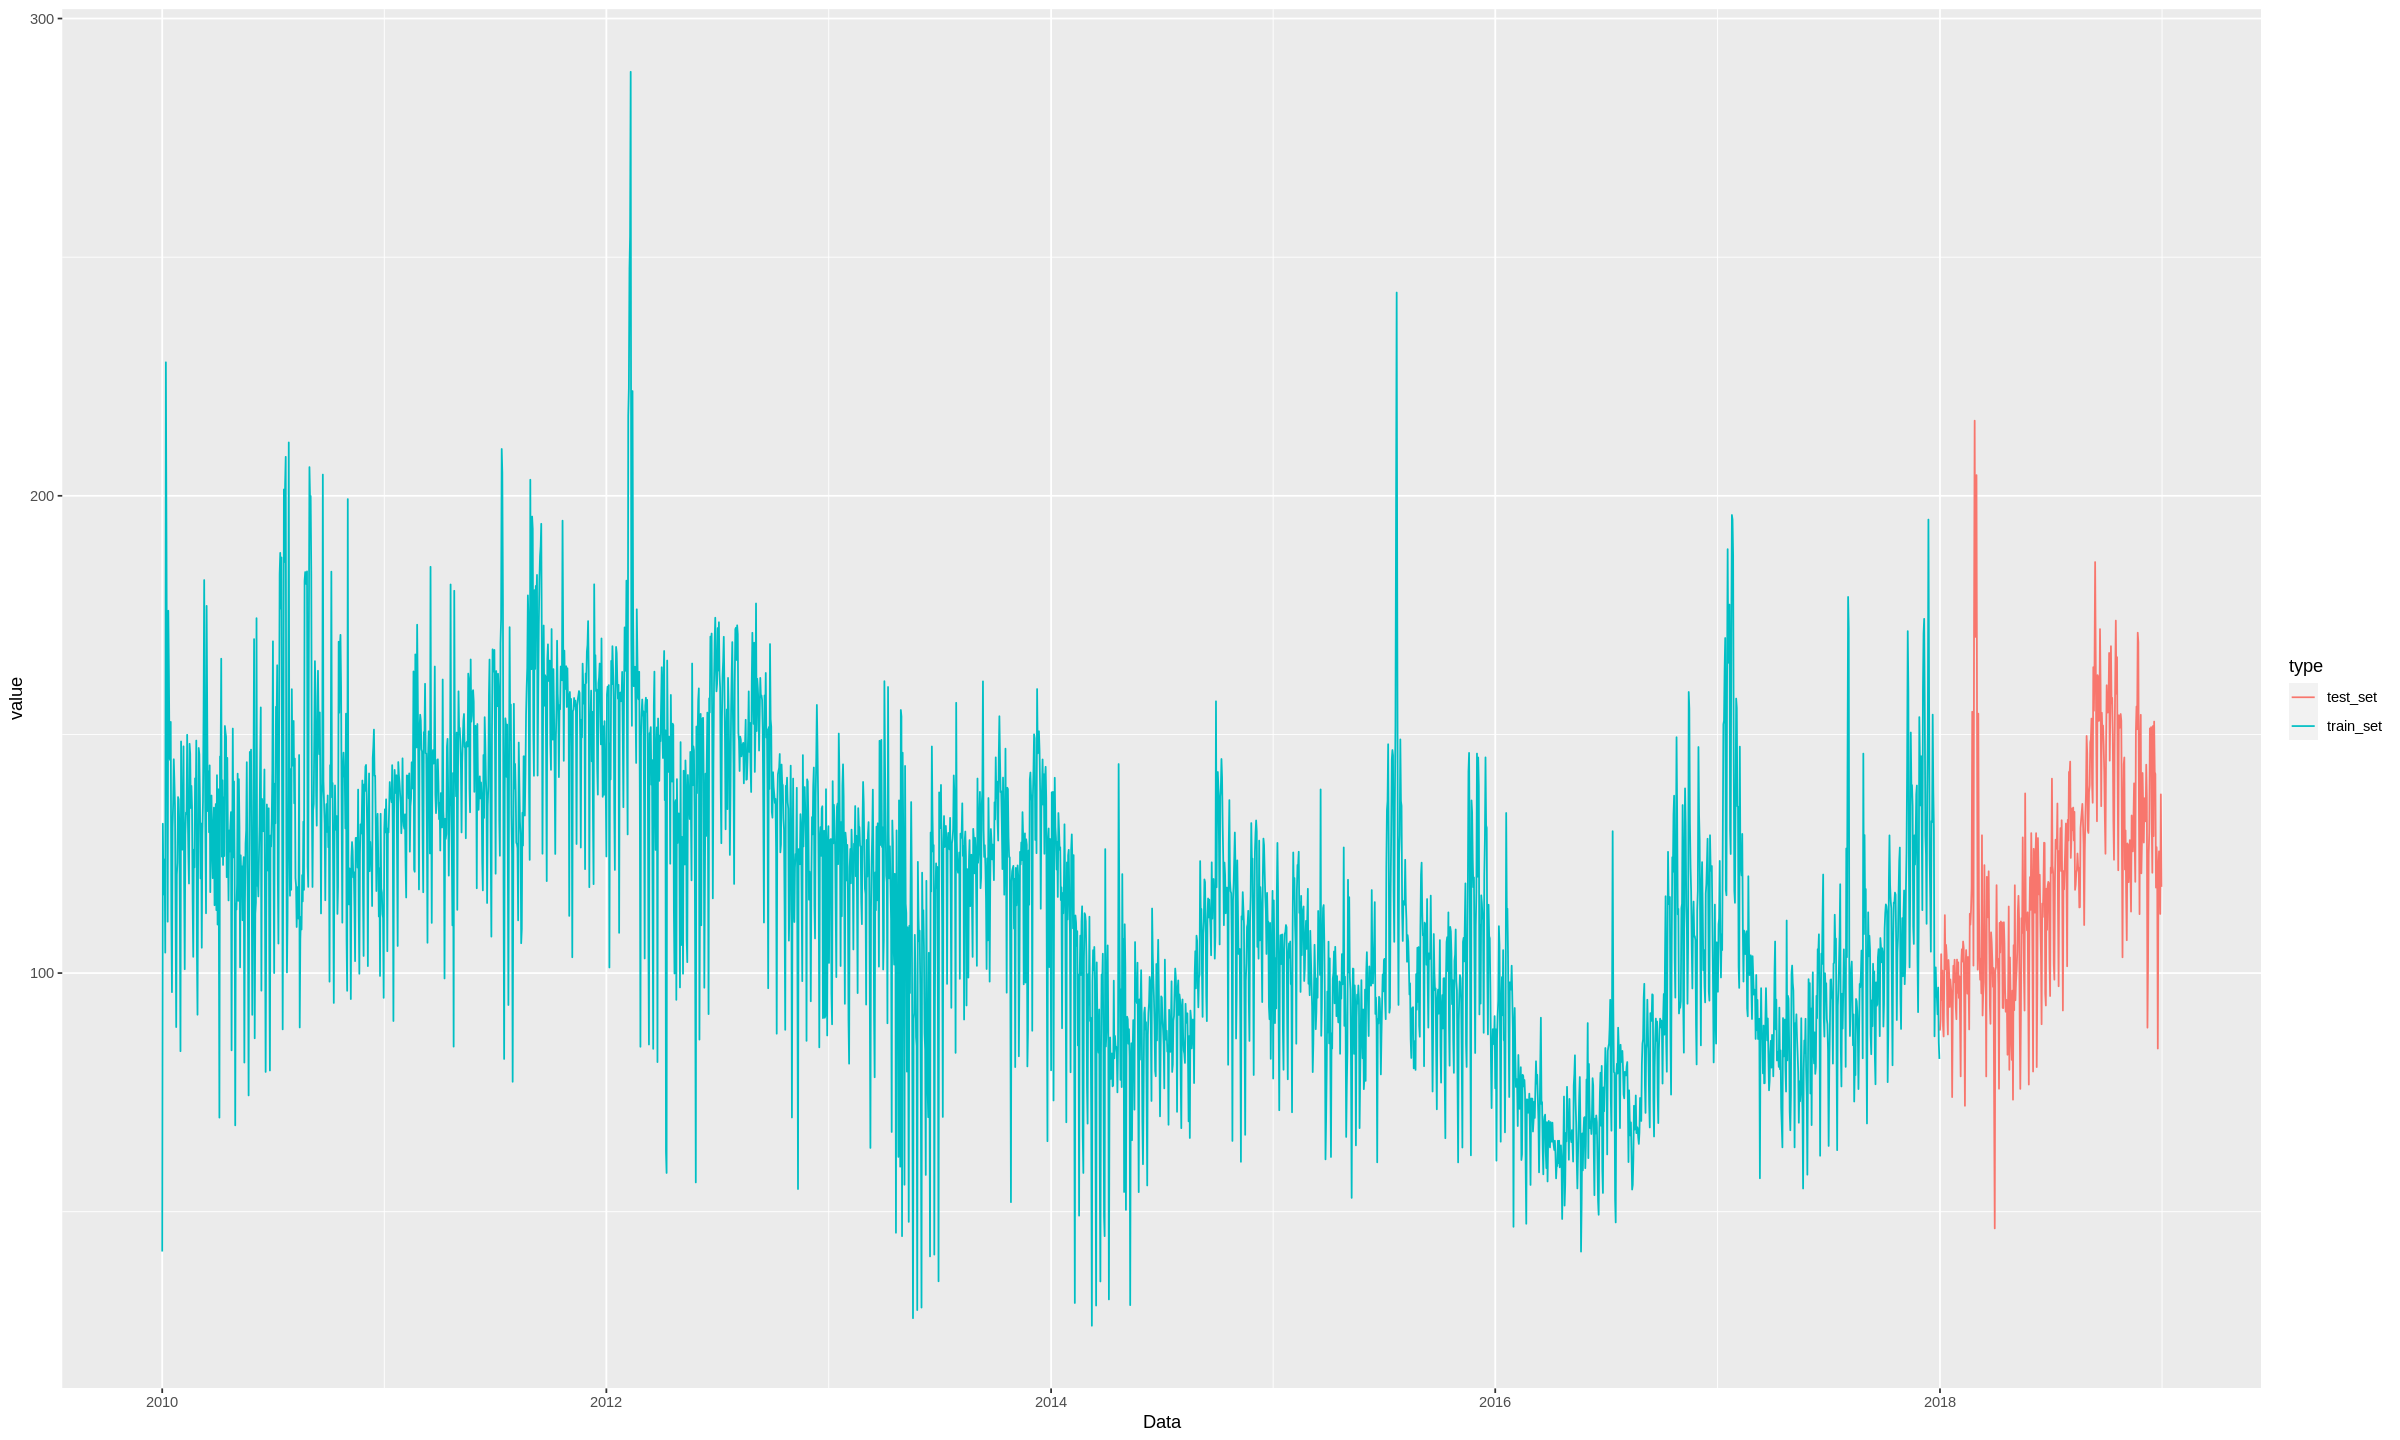

In [ ]:
train_data$type <- 'train_set'
test_data$type <- 'test_set'
dat <- rbind(train_data,test_data)

ggplot(dat,aes(x=Data,y=value))+
  geom_line(aes(color=type))
options(repr.plot.width=20, repr.plot.height=12)

Noto un leggero trend discendente e varianze non costanti, per decidere i prossimi passi osservo i grafici della serie storica in caso di varie trasformazioni (differenza di primo grado, logaritmo e diff+ logaritmo, e poi procedo con un test statistico per verificare la stazionarietà

Loading required package: gridExtra



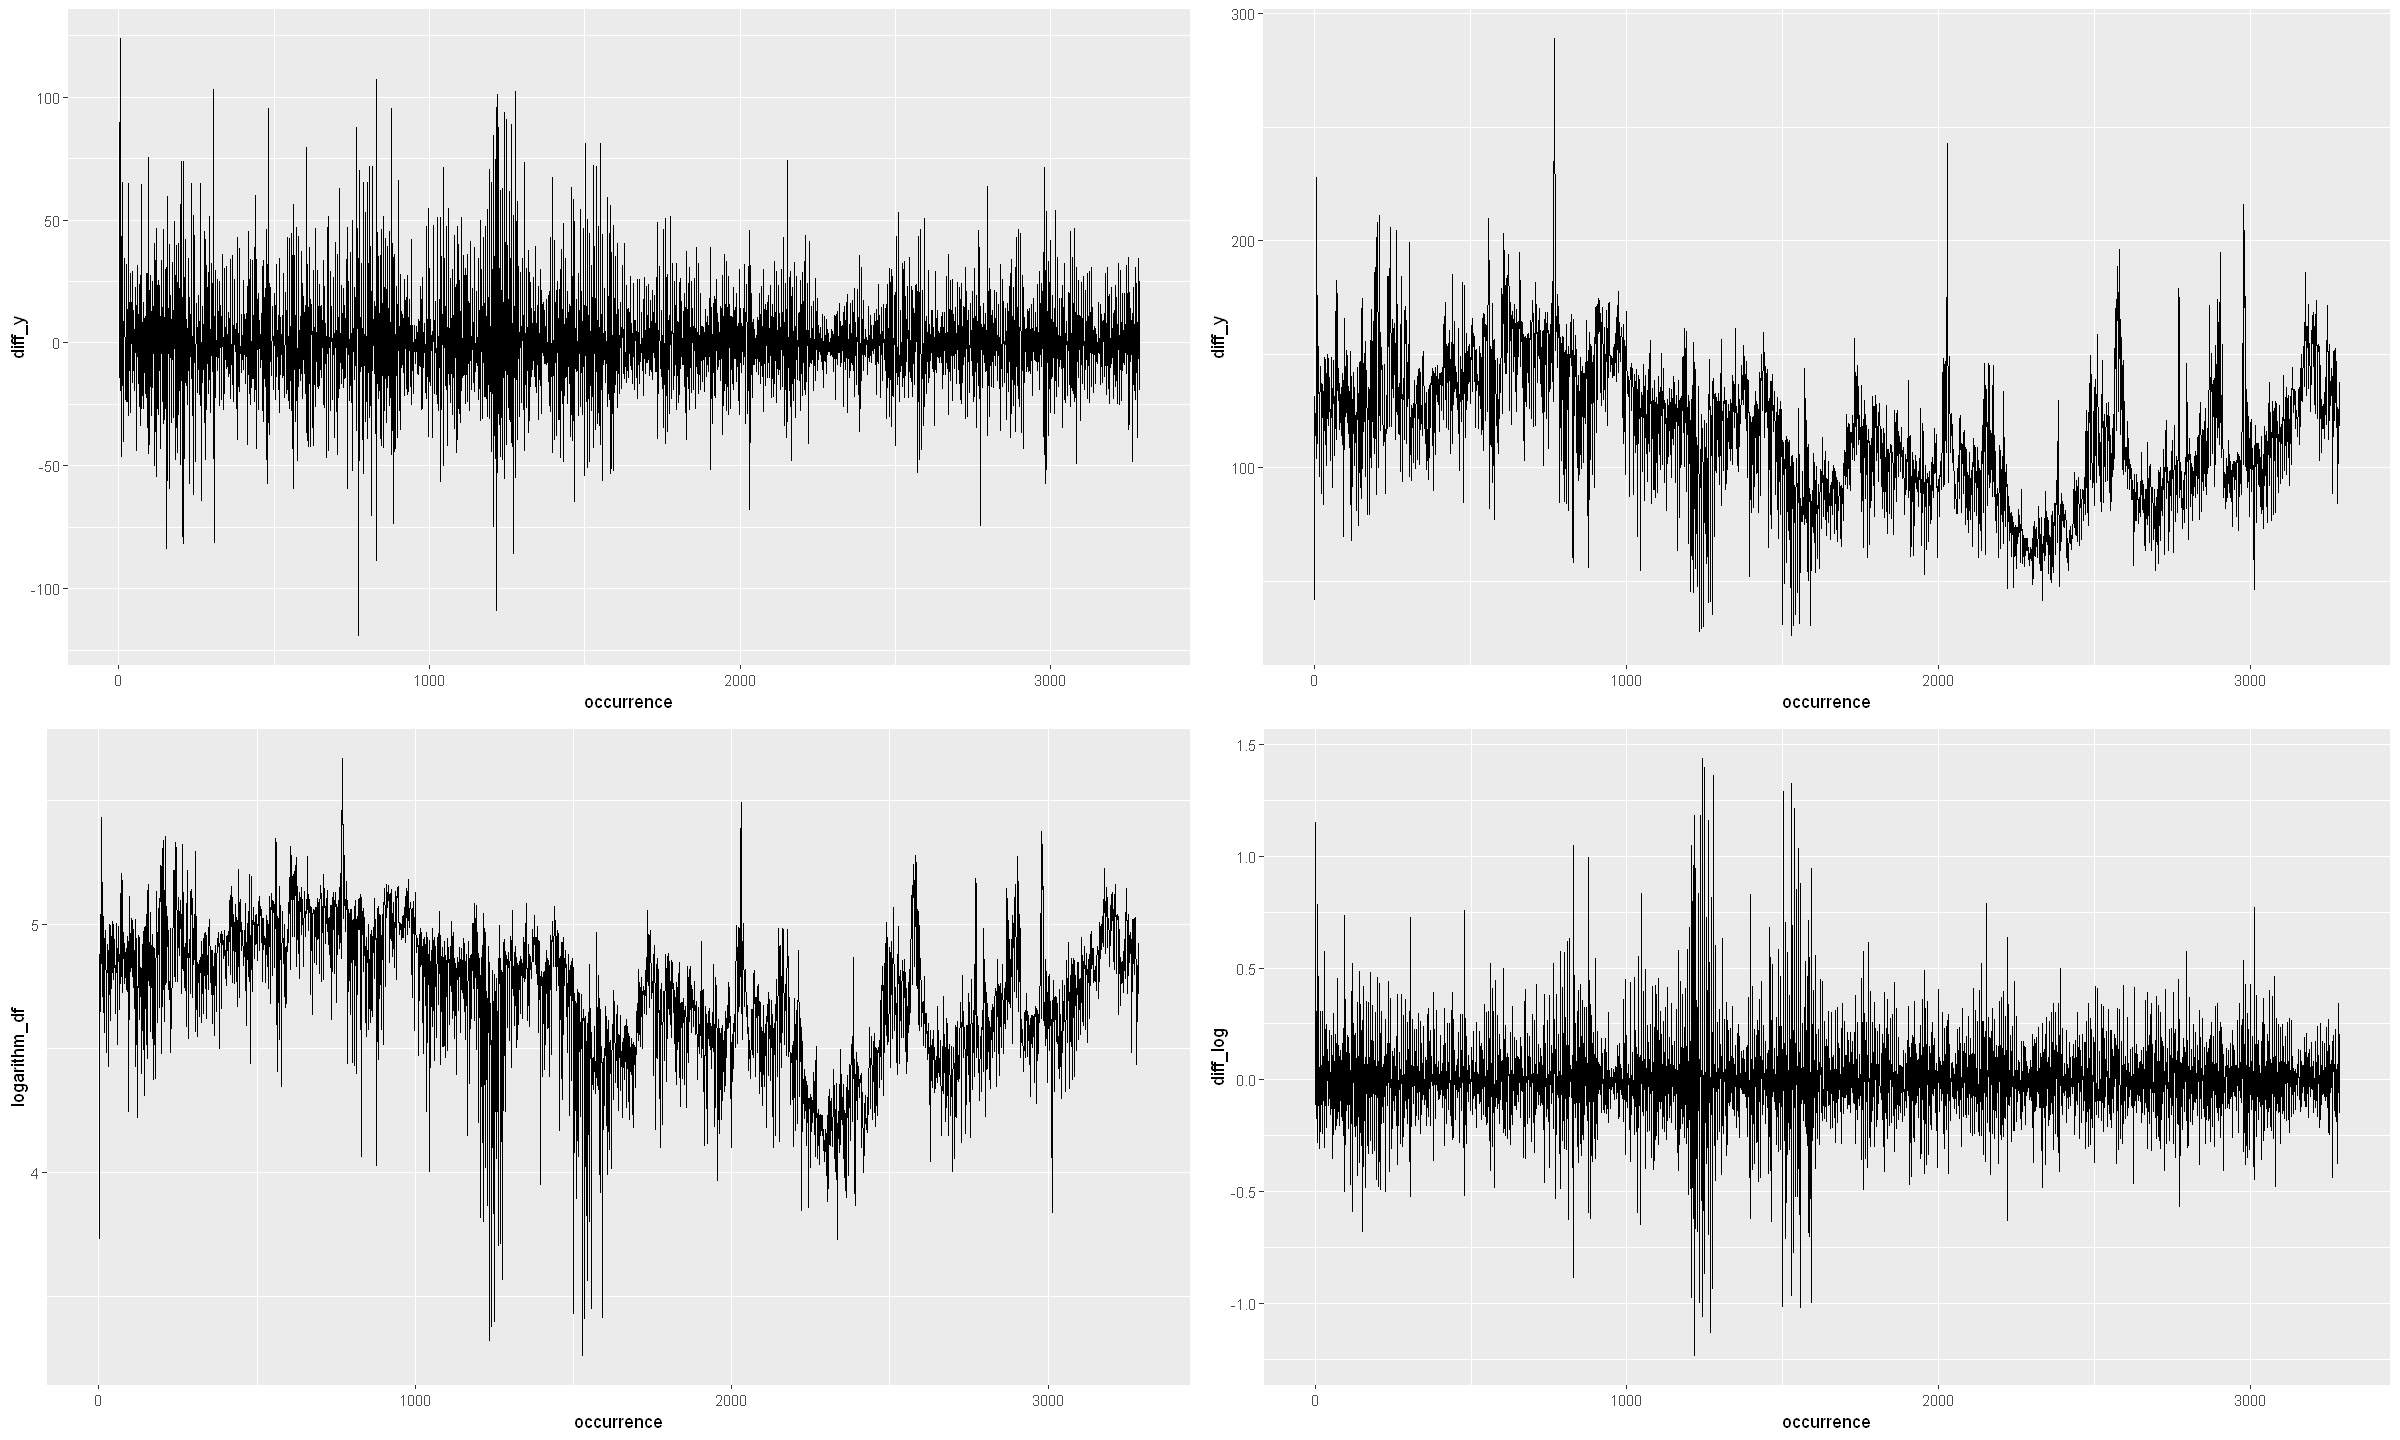

In [ ]:
diff_df<-diff(df$value)
logarithm_df <-log(df$value)
diff_log <- diff(logarithm_df)

plot1 <-ggplot(data=data.frame(diff_y=as.numeric(diff_df), occurrence=as.numeric(time(diff_df))),aes(x=occurrence, y=diff_y))+geom_line()
plot2 <-ggplot(data=data.frame(diff_y=as.numeric(df$value), occurrence=as.numeric(time(df$value))),aes(x=occurrence, y=diff_y))+geom_line()
plot3 <-ggplot(data=data.frame(diff_y=as.numeric(logarithm_df), occurrence=as.numeric(time(logarithm_df))),aes(x=occurrence, y=logarithm_df))+geom_line()
plot4 <-ggplot(data=data.frame(diff_y=as.numeric(diff_log), occurrence=as.numeric(time(diff_log))),aes(x=occurrence, y=diff_log))+geom_line()
#install.packages("gridExtra")
require(gridExtra)
gridExtra::grid.arrange(plot1, plot2, plot3, plot4)

In [ ]:
tseries::adf.test(train_data$value)

Warning message in tseries::adf.test(train_data$value):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train_data$value
Dickey-Fuller = -5.1627, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary


p-value=0,01, rifiuto l'ipotesi nulla di almeno una radice carattersitica è uguale ad 1. Procedo a considerare quindi i dati stazionari

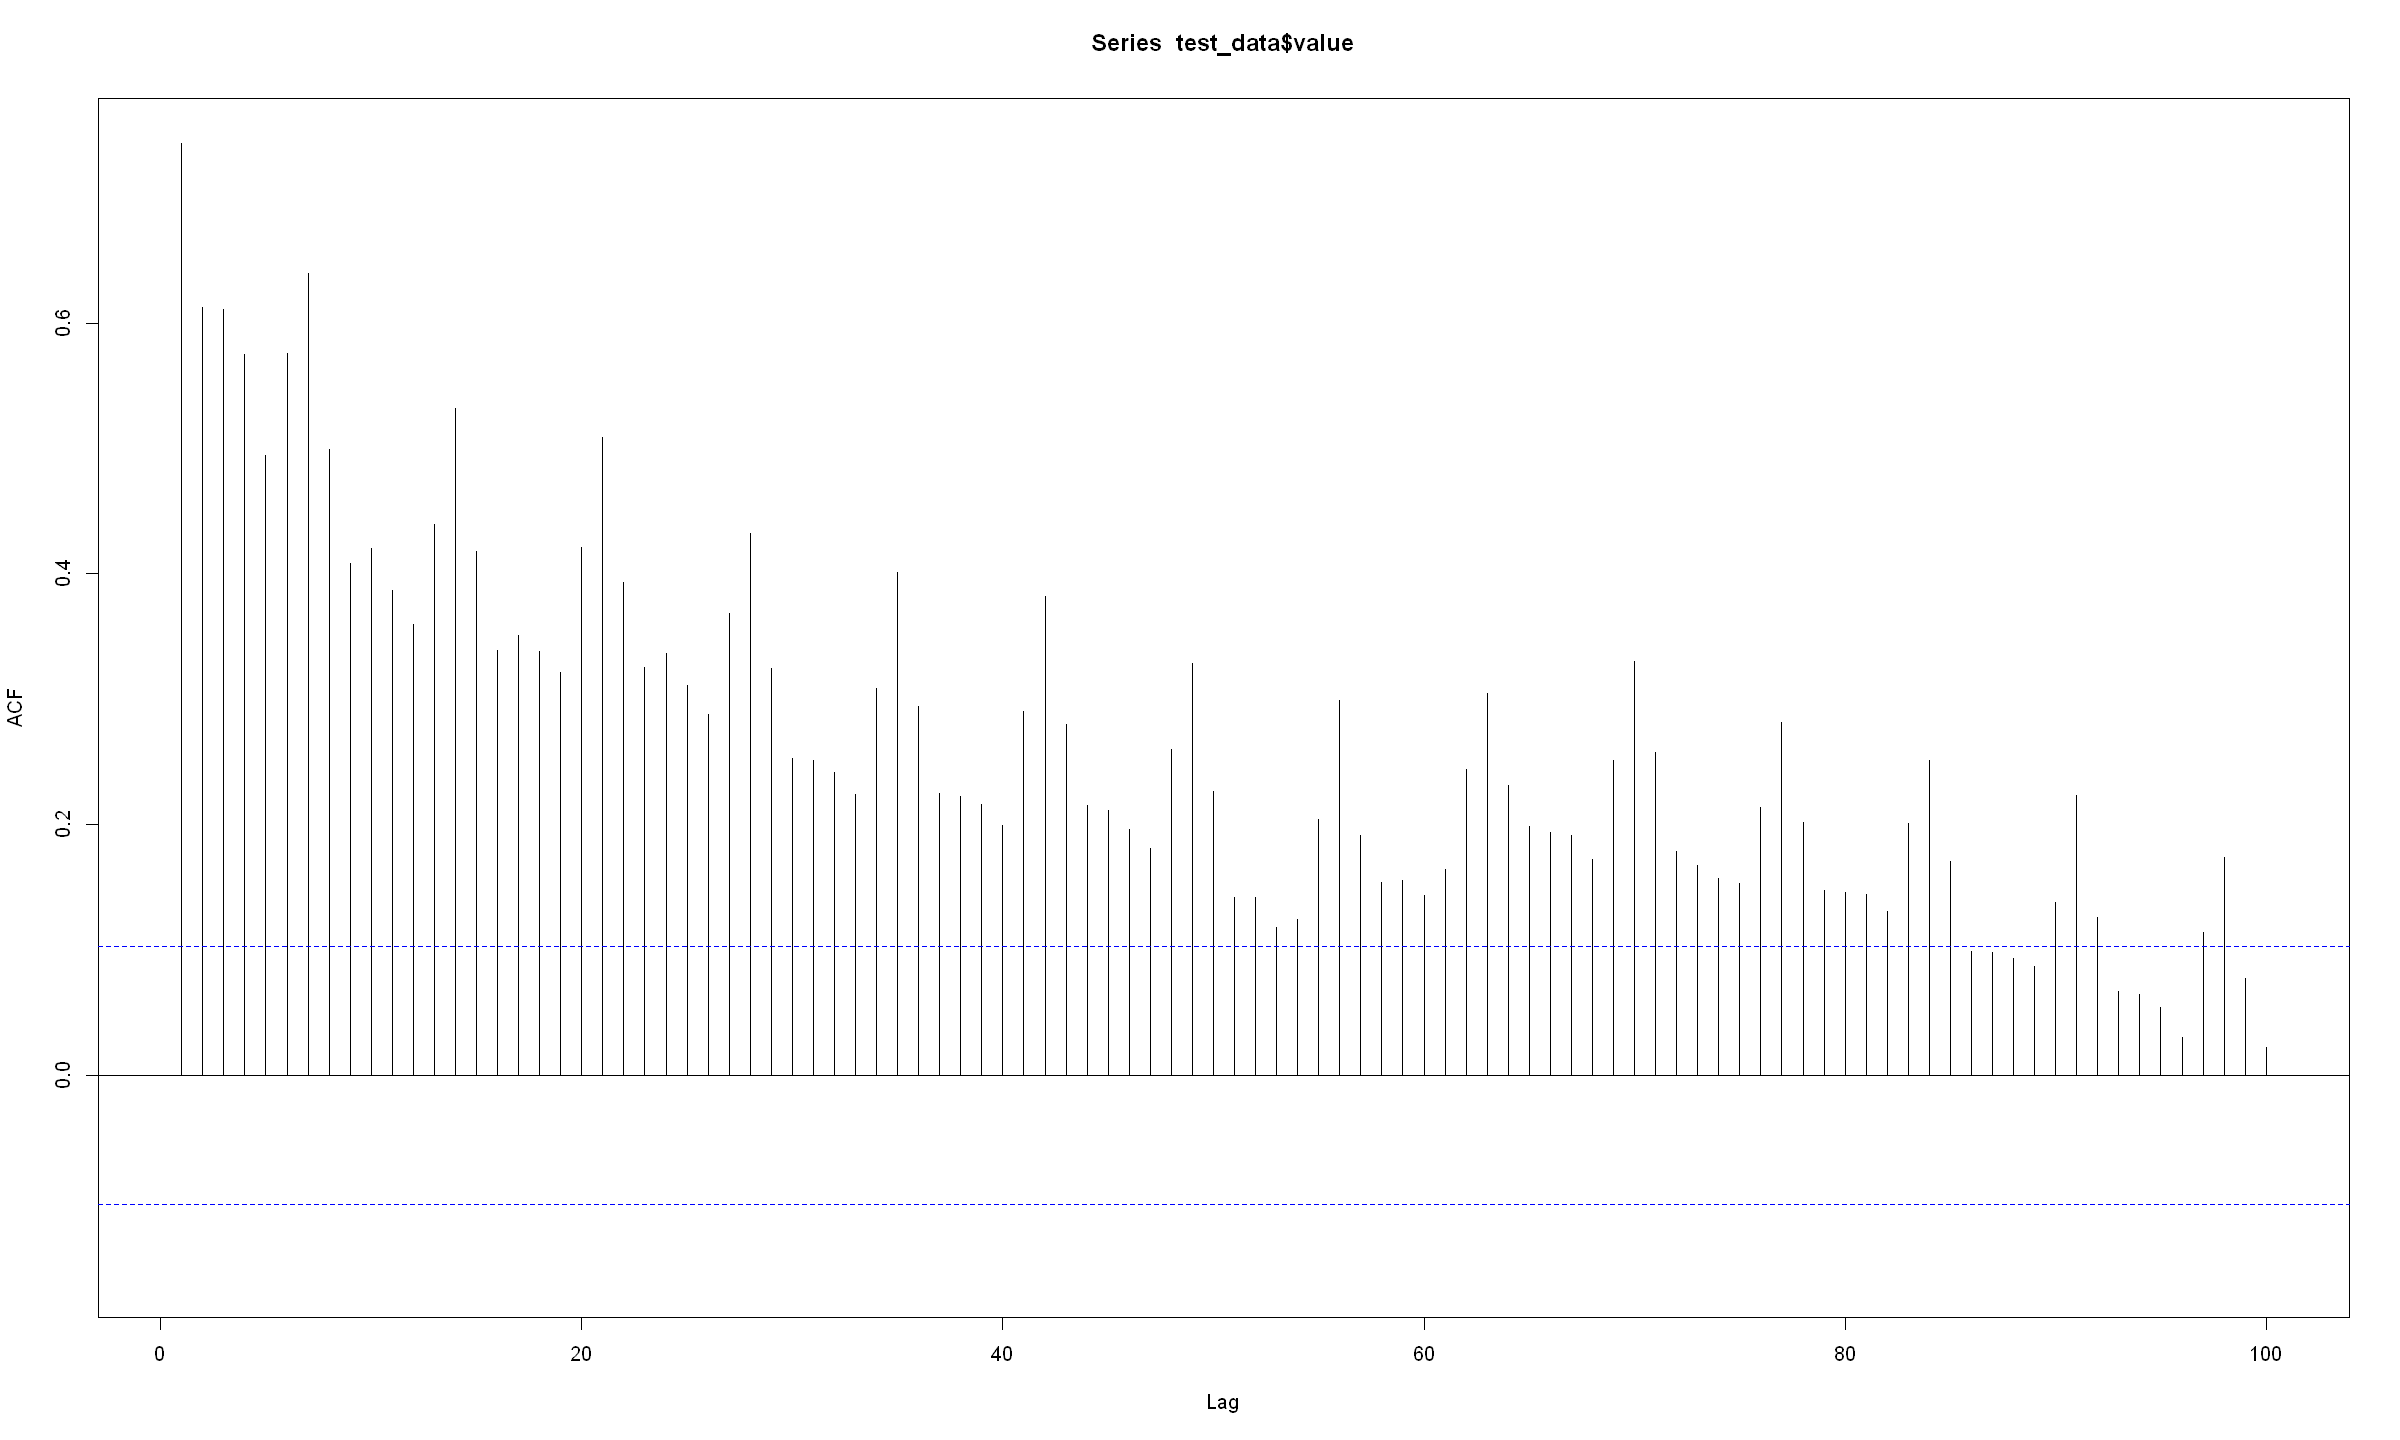

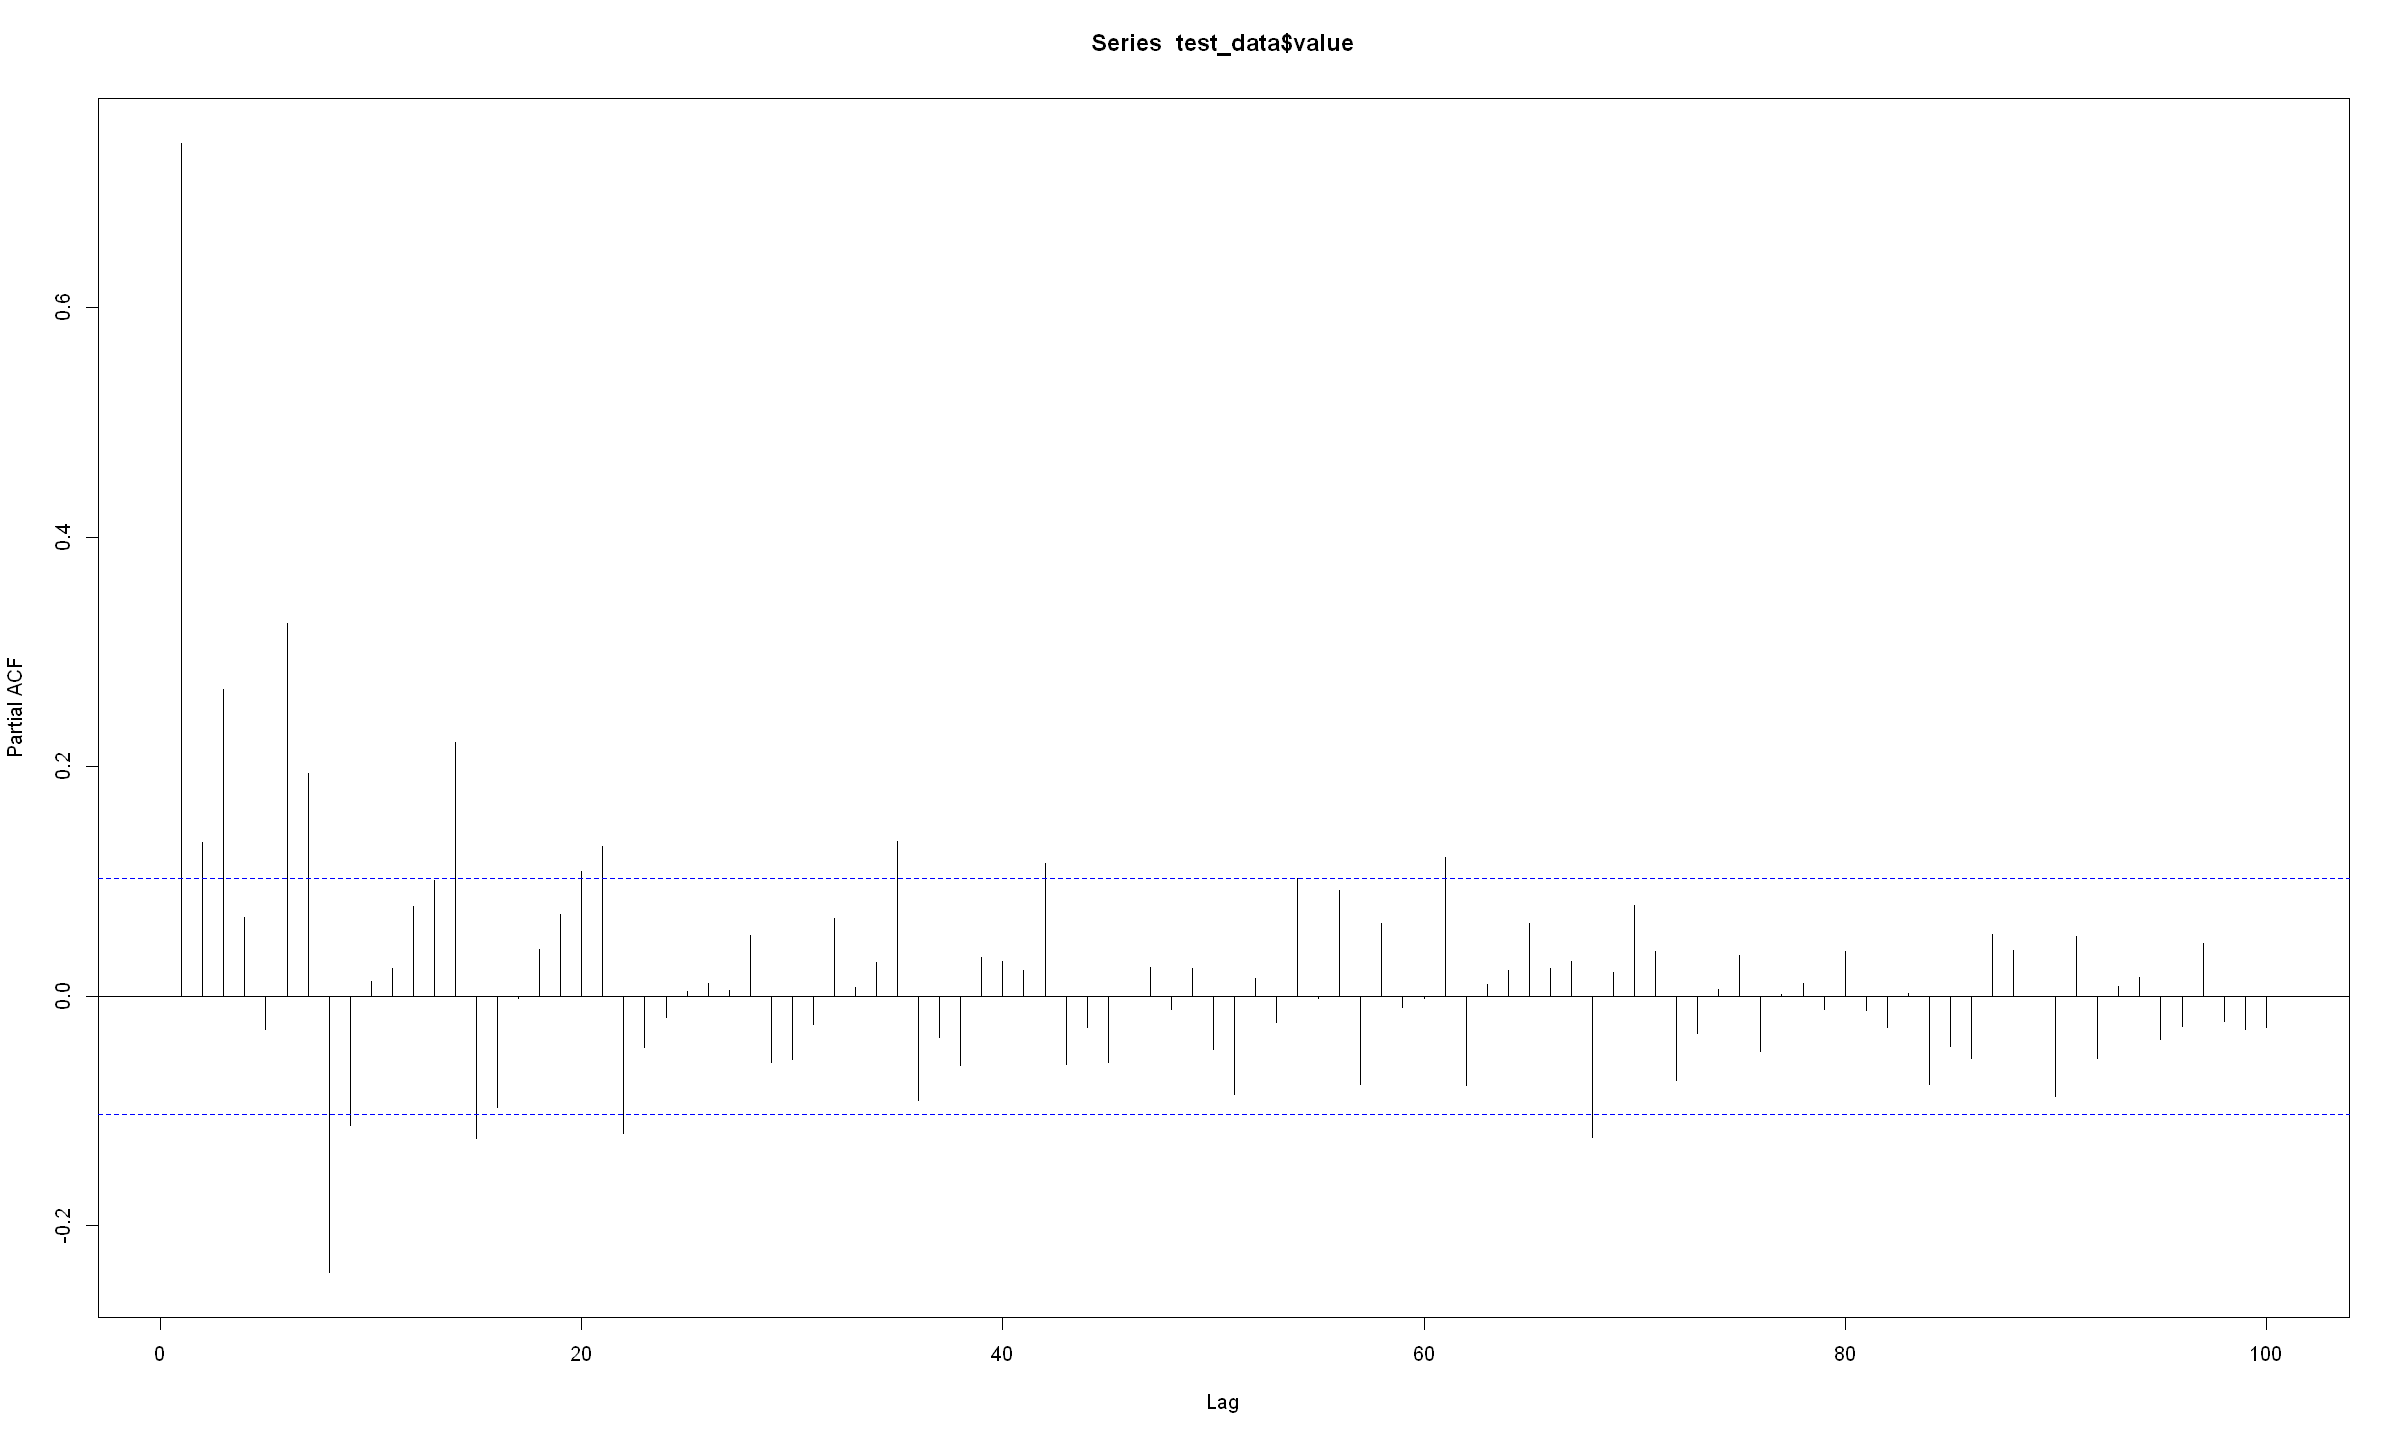

In [ ]:
Acf(test_data$value, lag.max = 100)
Pacf(test_data$value, lag.max = 100)

Noto subito una stagionalità a 7 giorni in quanto ogni 7 ritardi l' ACF cresce per poi decrescere a velocità geometrica.


ACF tende a tornare verso 0 a velocità geom in maniera stagionale ad ogni ritardo AR(7)

Series: train_data$value 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0.9437982 

Coefficients:
        sar1     sma1     mean
      0.9591  -0.5557  92.6251
s.e.  0.0063   0.0229   2.5938

sigma^2 estimated as 183.9:  log likelihood=-11767.49
AIC=23542.97   AICc=23542.98   BIC=23566.89

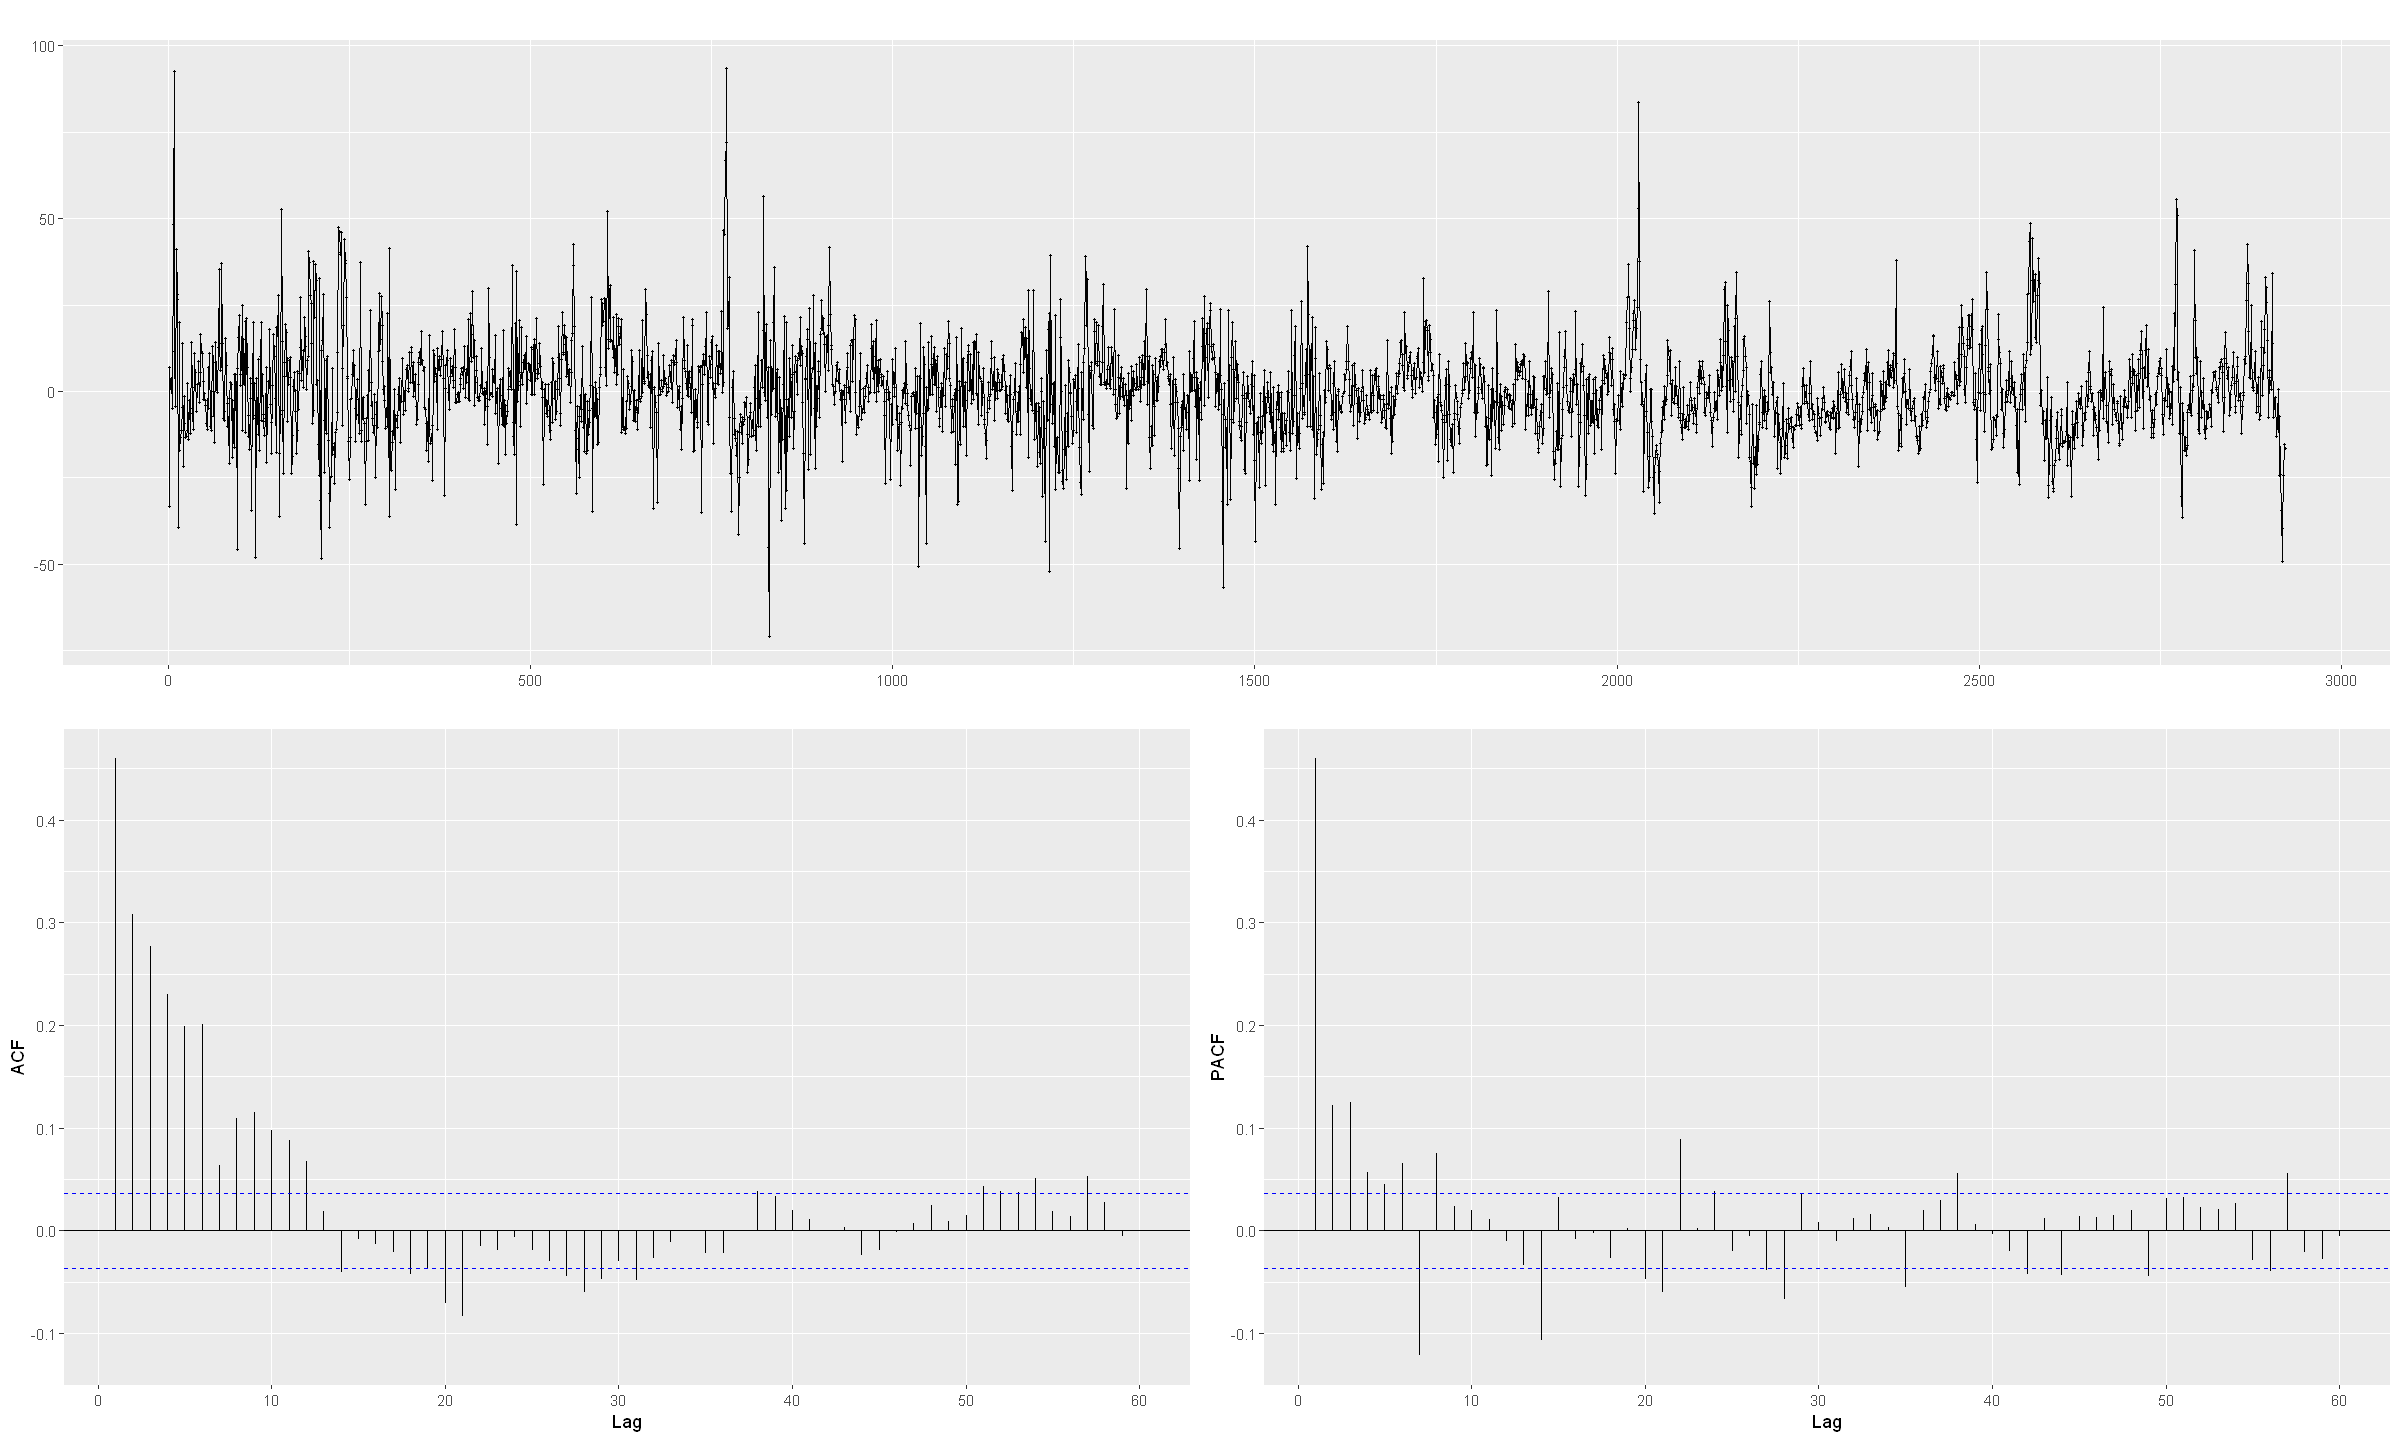

In [ ]:
model1 <- Arima(train_data$value, c(0,0,0), list(order=c(1,0,1), period=7), lambda = "auto")
ggtsdisplay(model1$residuals, lag.max = 60)
model1


Creo un modello considerando una possibile integrazione stagionale

Series: train_data$value 
ARIMA(0,0,0)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9437982 

Coefficients:
        sar1     sma1
      0.2767  -0.7980
s.e.  0.0309   0.0209

sigma^2 estimated as 182.7:  log likelihood=-11727.44
AIC=23460.88   AICc=23460.89   BIC=23478.82

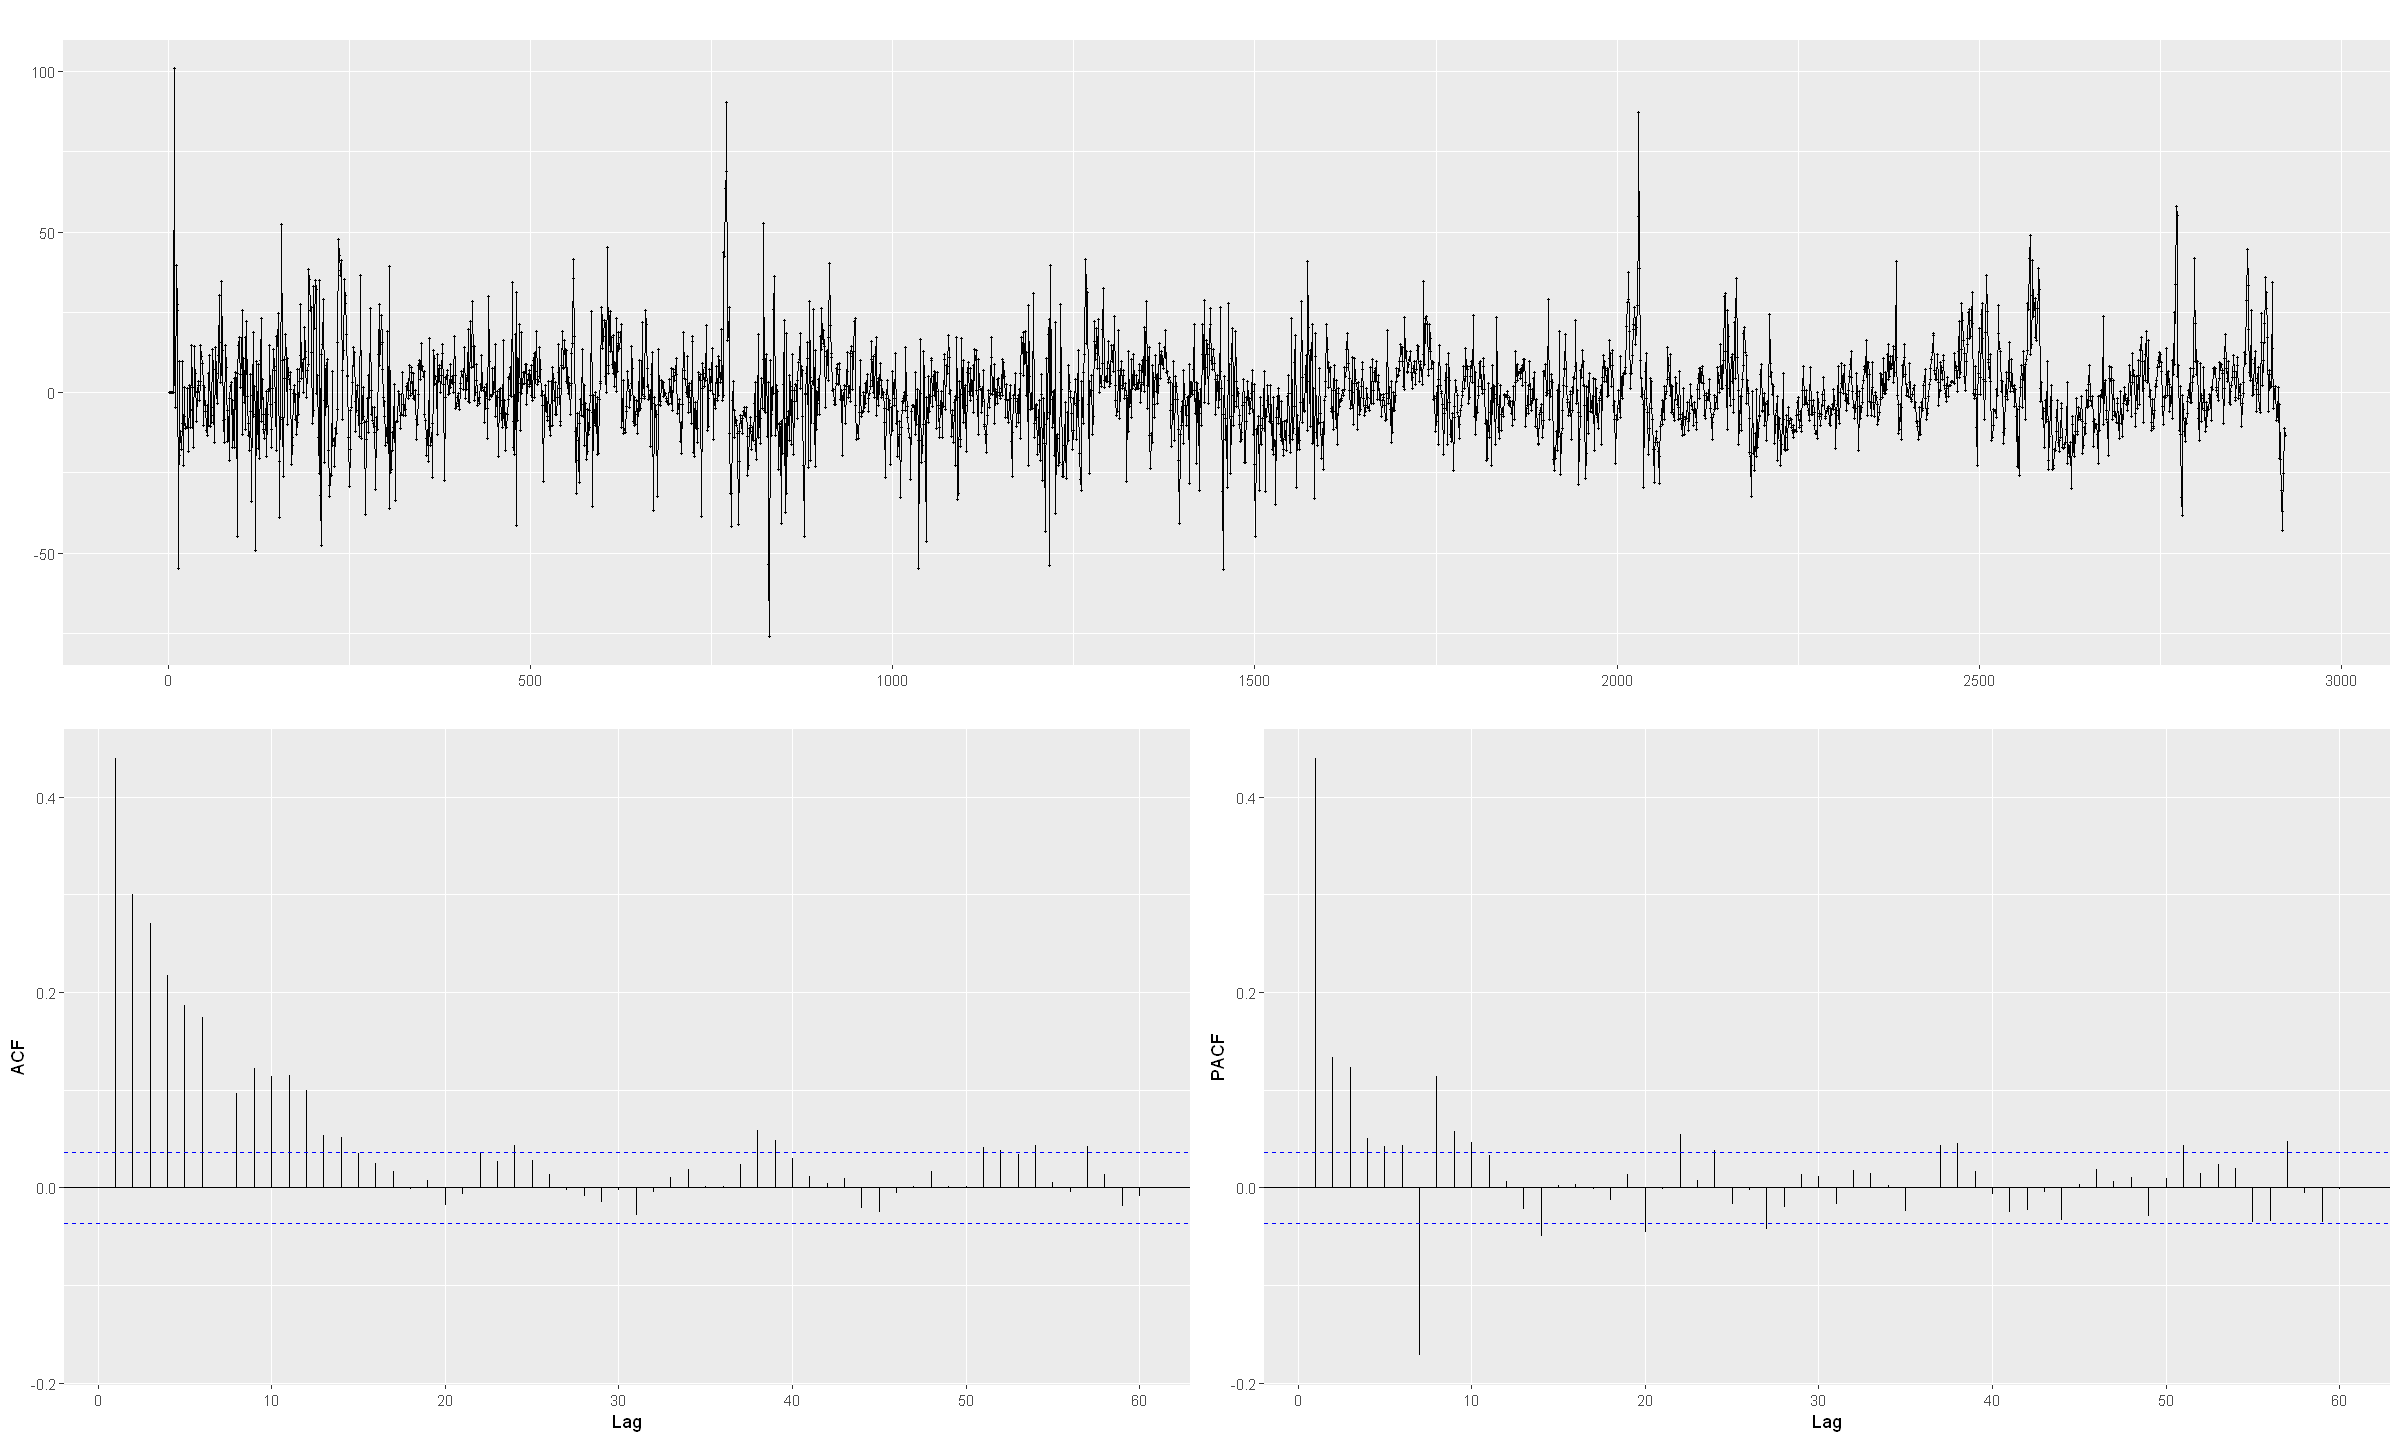

In [ ]:
model2 <- Arima(train_data$value, c(0,0,0), list(order=c(1,1,1), period=7), lambda = "auto")
ggtsdisplay(model2$residuals, lag.max = 60)
model2

Siccome nei grafici in cui sono stati applicati i logaritmi e le diffenziazioni ho il dubbio che la serie abbia un' andamento migliore, voglio considerare anche il caso di non stazionarietà, procedo quindi a creare altri 3 nuovi modelli, uno per ogni casistica

Series: train_data$value 
ARIMA(0,1,0)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9437982 

Coefficients:
        sar1     sma1
      0.0784  -0.9645
s.e.  0.0199   0.0065

sigma^2 estimated as 173.5:  log likelihood=-11655.09
AIC=23316.18   AICc=23316.19   BIC=23334.11

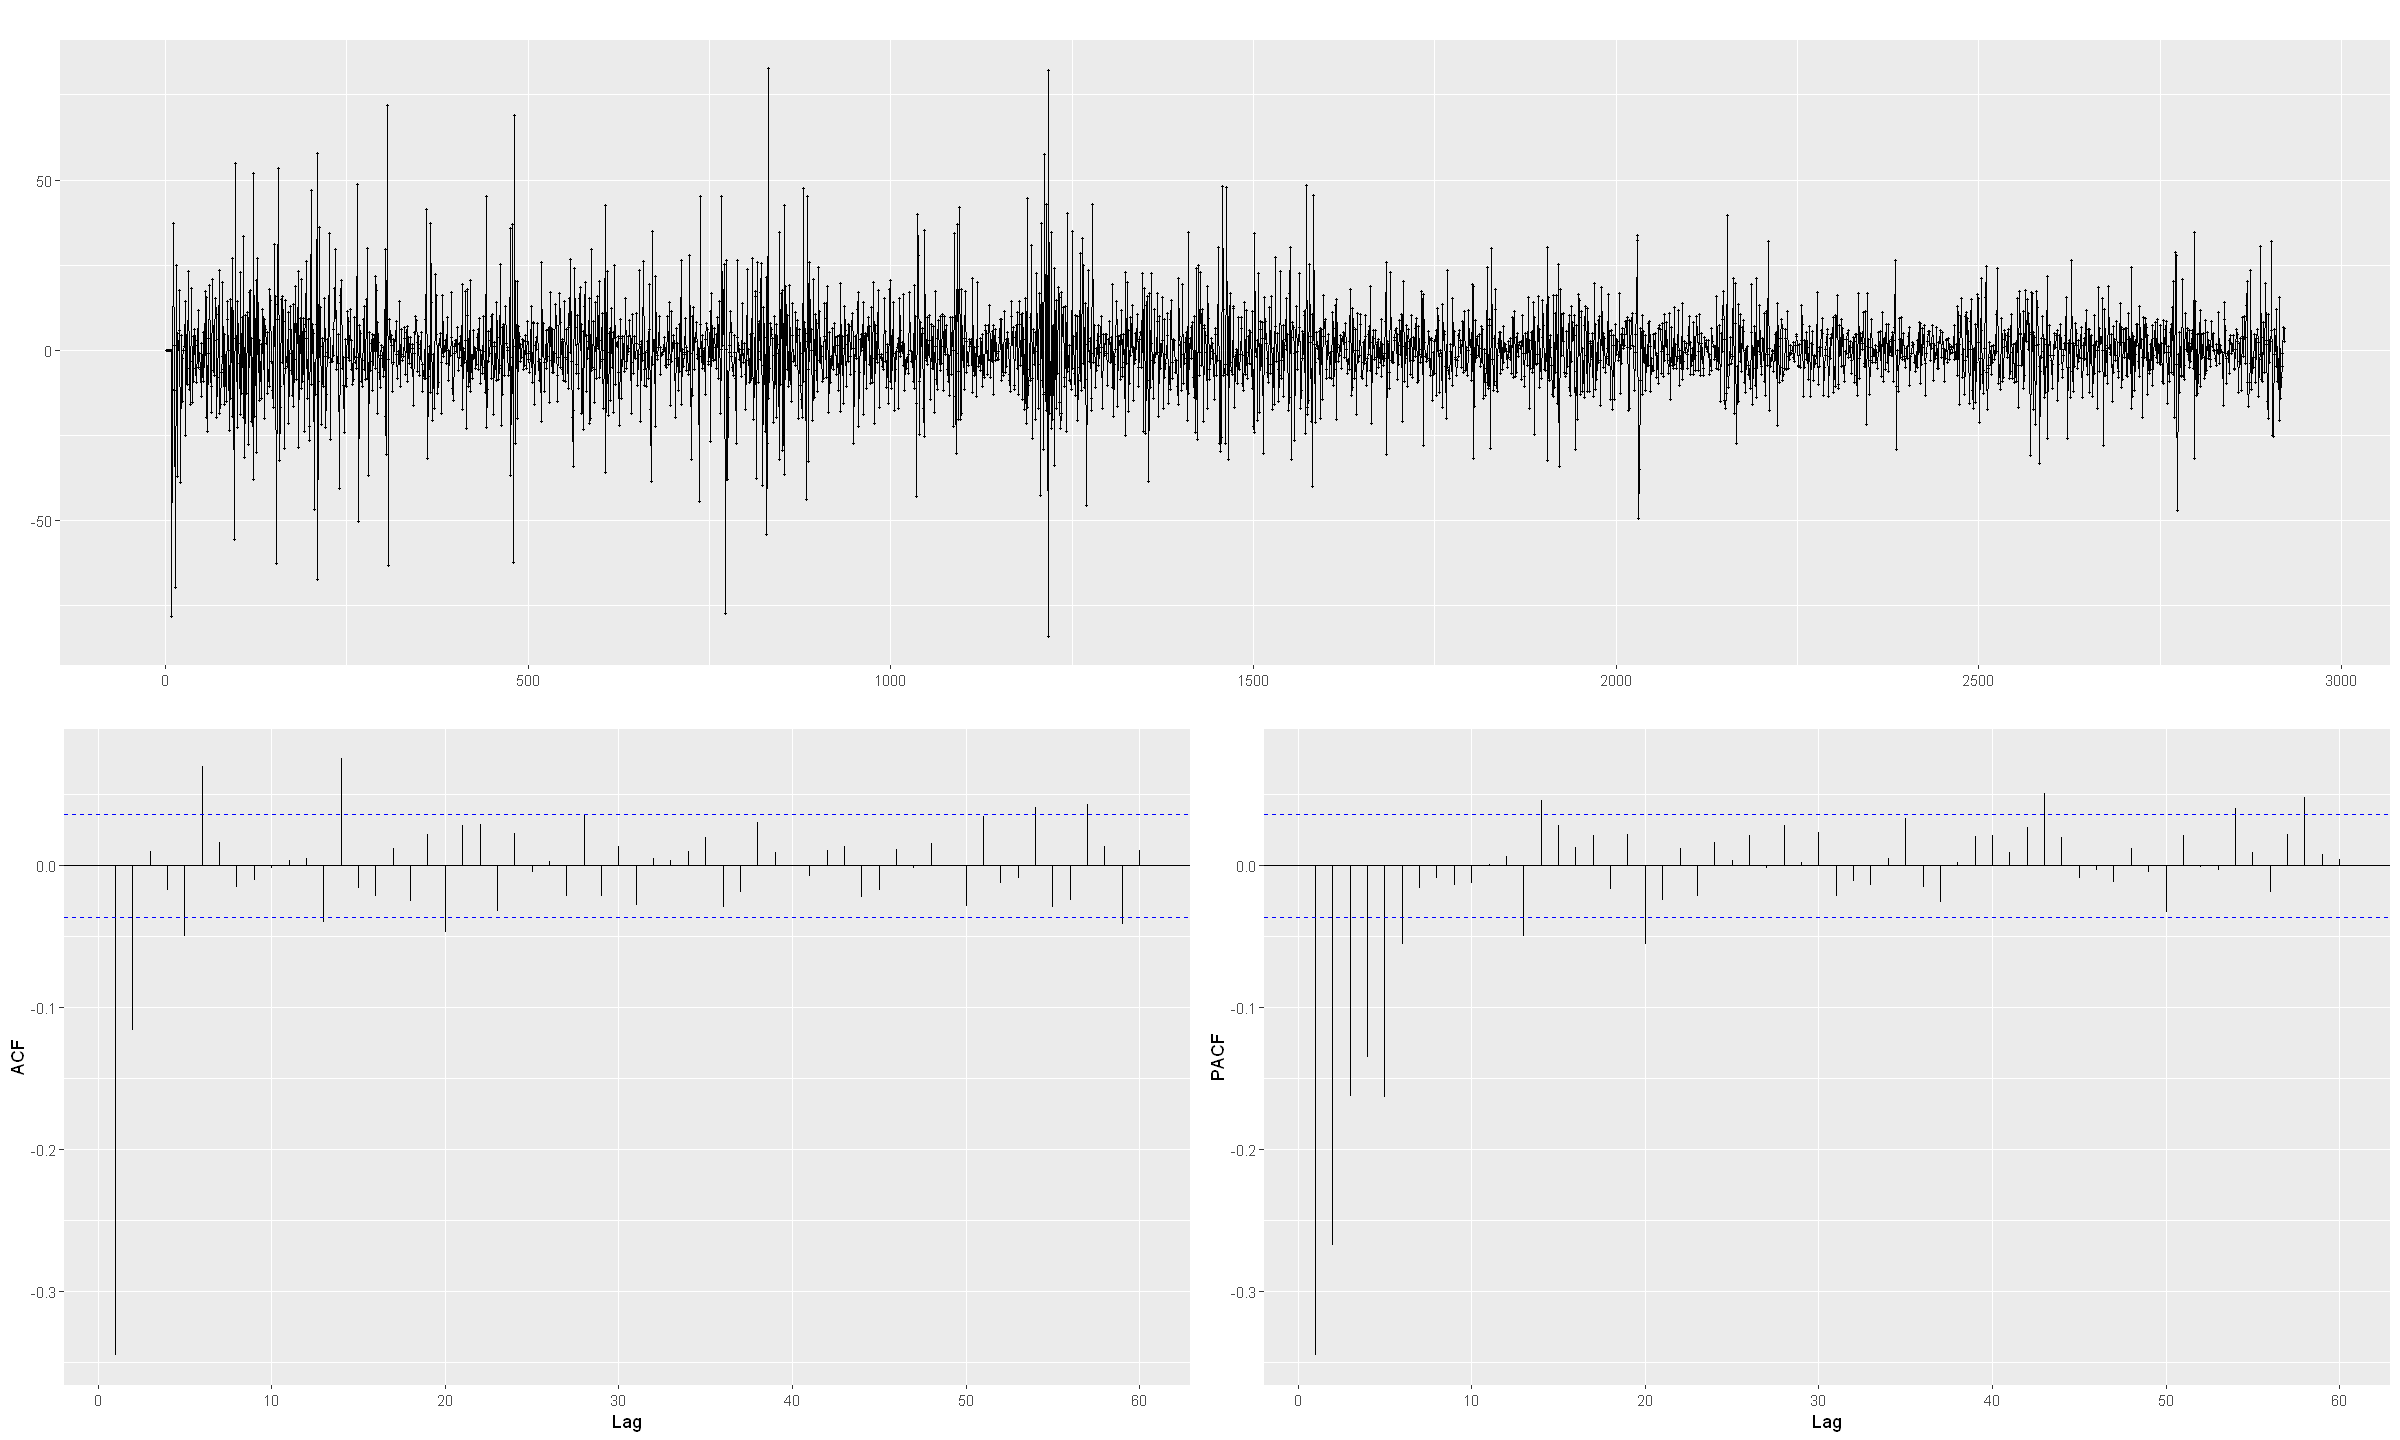

In [ ]:
#integrazione di primo tipo
model3 <- Arima(train_data$value, c(0,1,0), list(order=c(1,1,1), period=7), lambda = "auto")
ggtsdisplay(model3$residuals, lag.max = 60)
model3

Series: train_data$value 
ARIMA(0,0,0)(1,1,1)[7] 
Box Cox transformation: lambda= 0 

Coefficients:
        sar1     sma1
      0.1990  -0.7226
s.e.  0.0334   0.0246

sigma^2 estimated as 0.02514:  log likelihood=1231.31
AIC=-2456.63   AICc=-2456.62   BIC=-2438.69

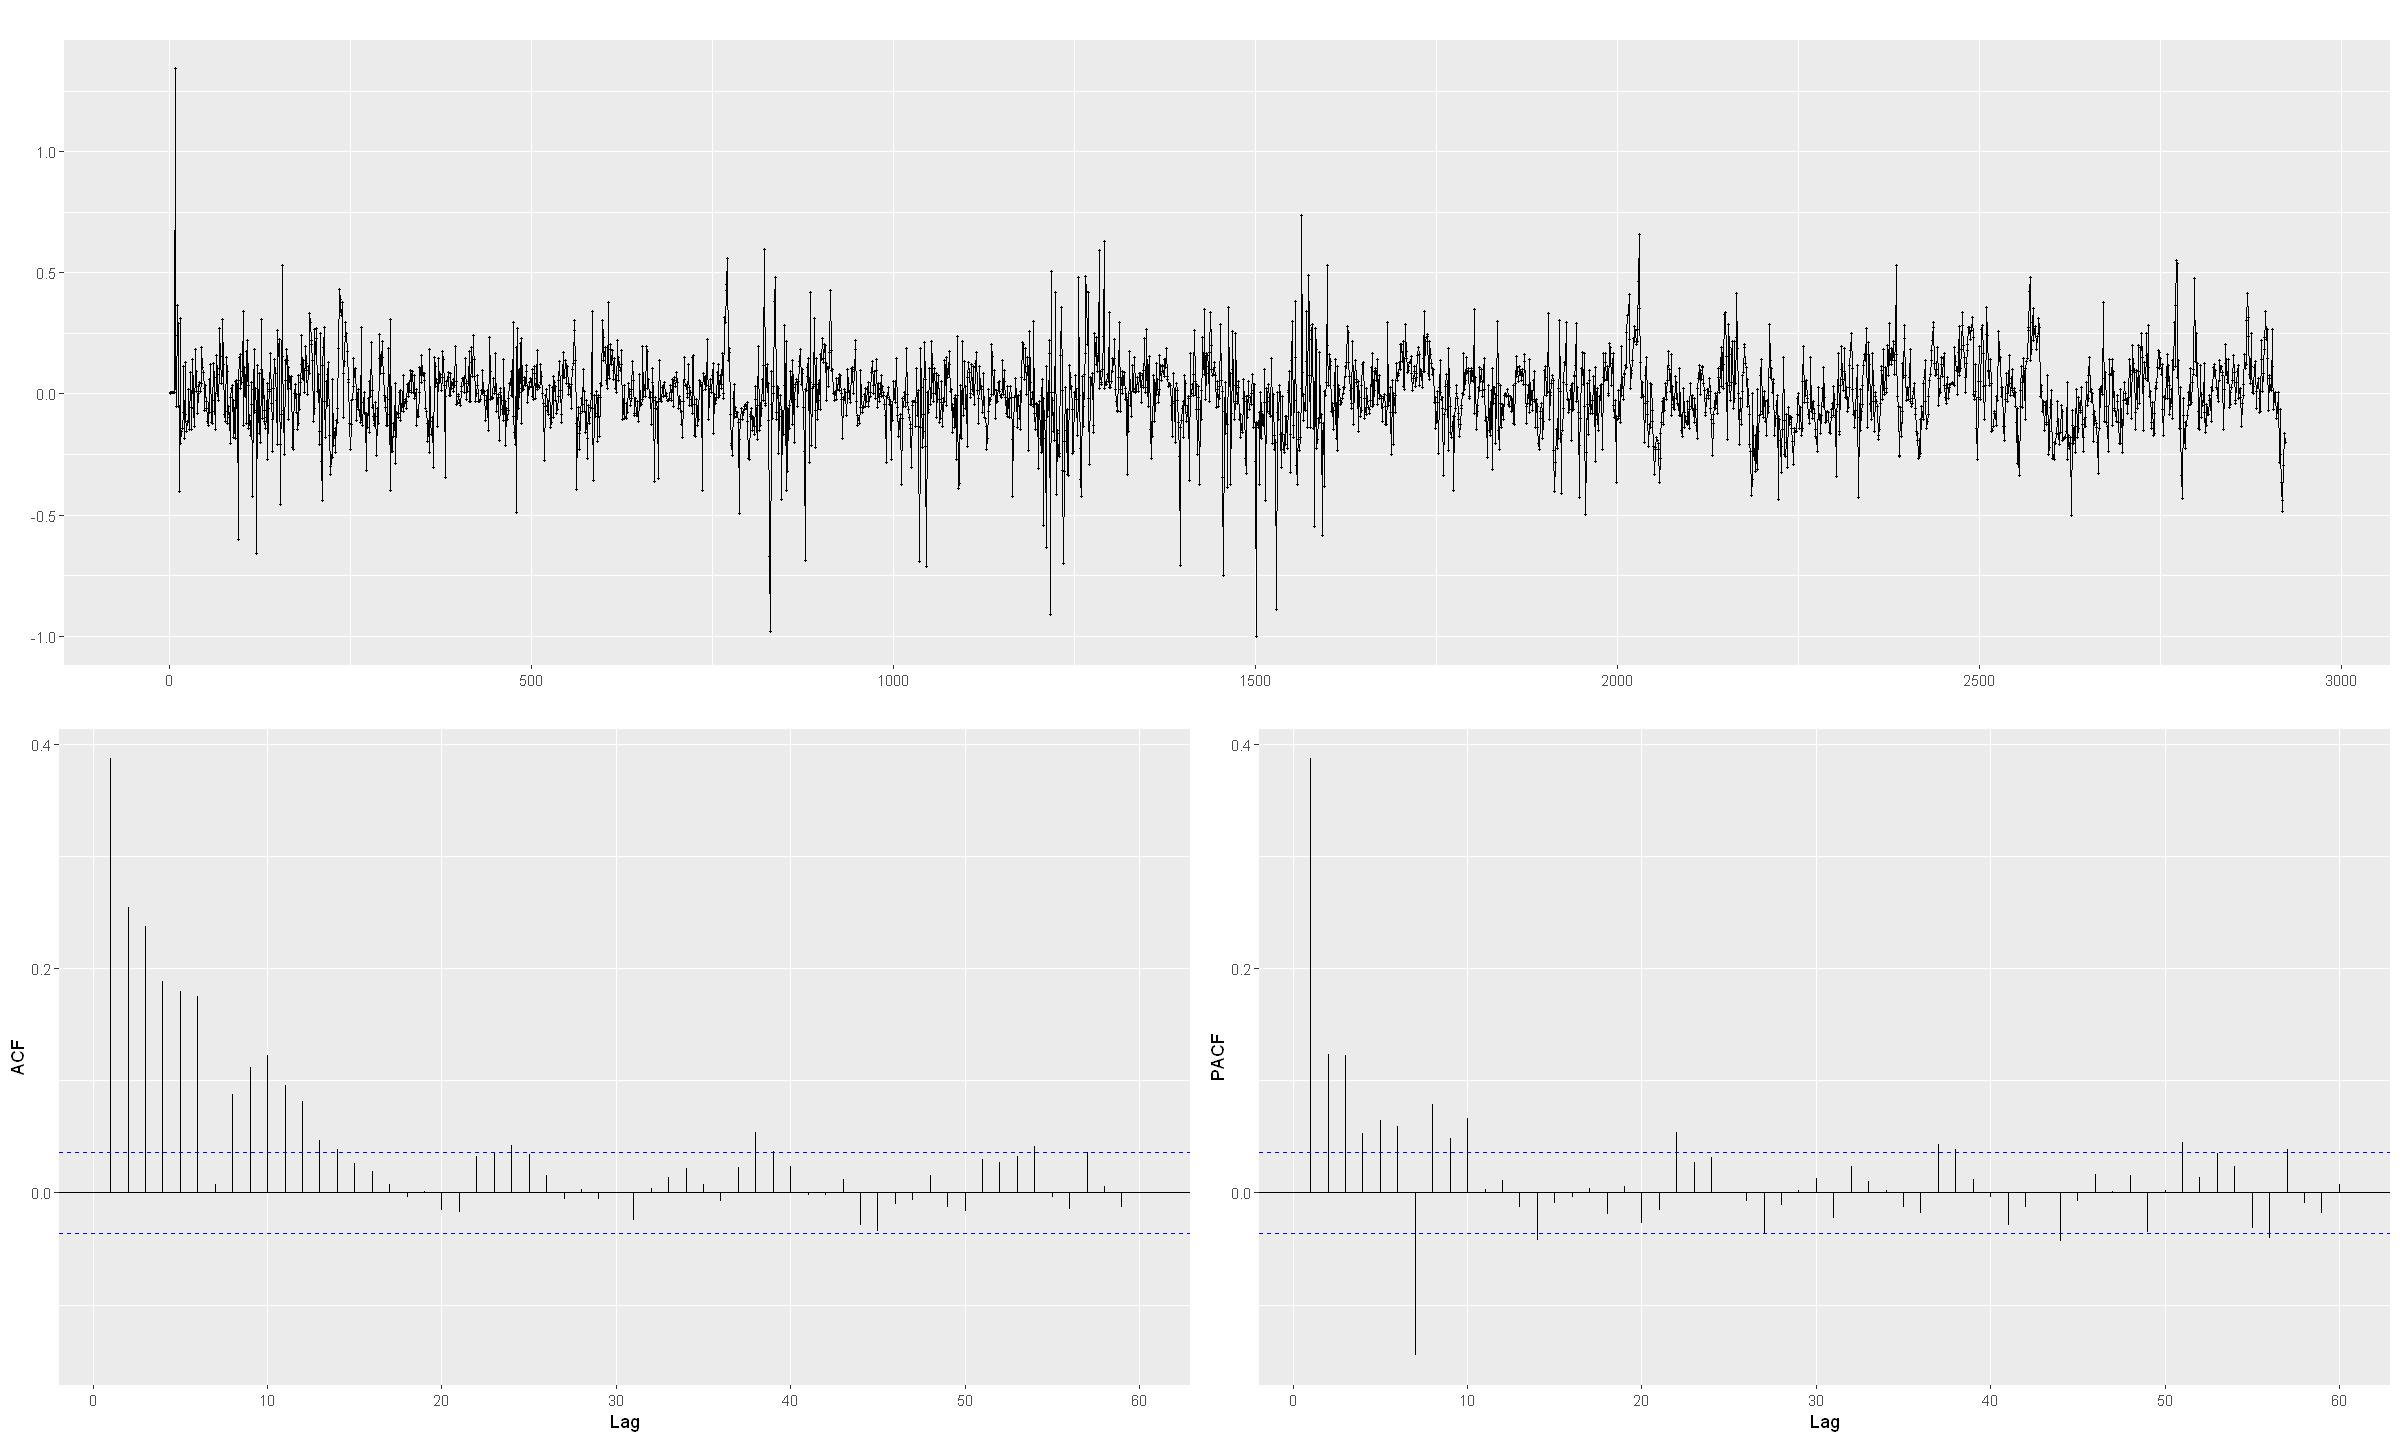

In [ ]:
#logaritmo
model4 <- Arima(train_data$value, c(0,0,0), list(order=c(1,1,1), period=7), lambda = 0)
ggtsdisplay(model4$residuals, lag.max = 60)
model4

Series: train_data$value 
ARIMA(0,1,0)(1,1,1)[7] 
Box Cox transformation: lambda= 0 

Coefficients:
        sar1     sma1
      0.0893  -0.8967
s.e.  0.0329   0.0253

sigma^2 estimated as 0.02747:  log likelihood=1098.59
AIC=-2191.19   AICc=-2191.18   BIC=-2173.26

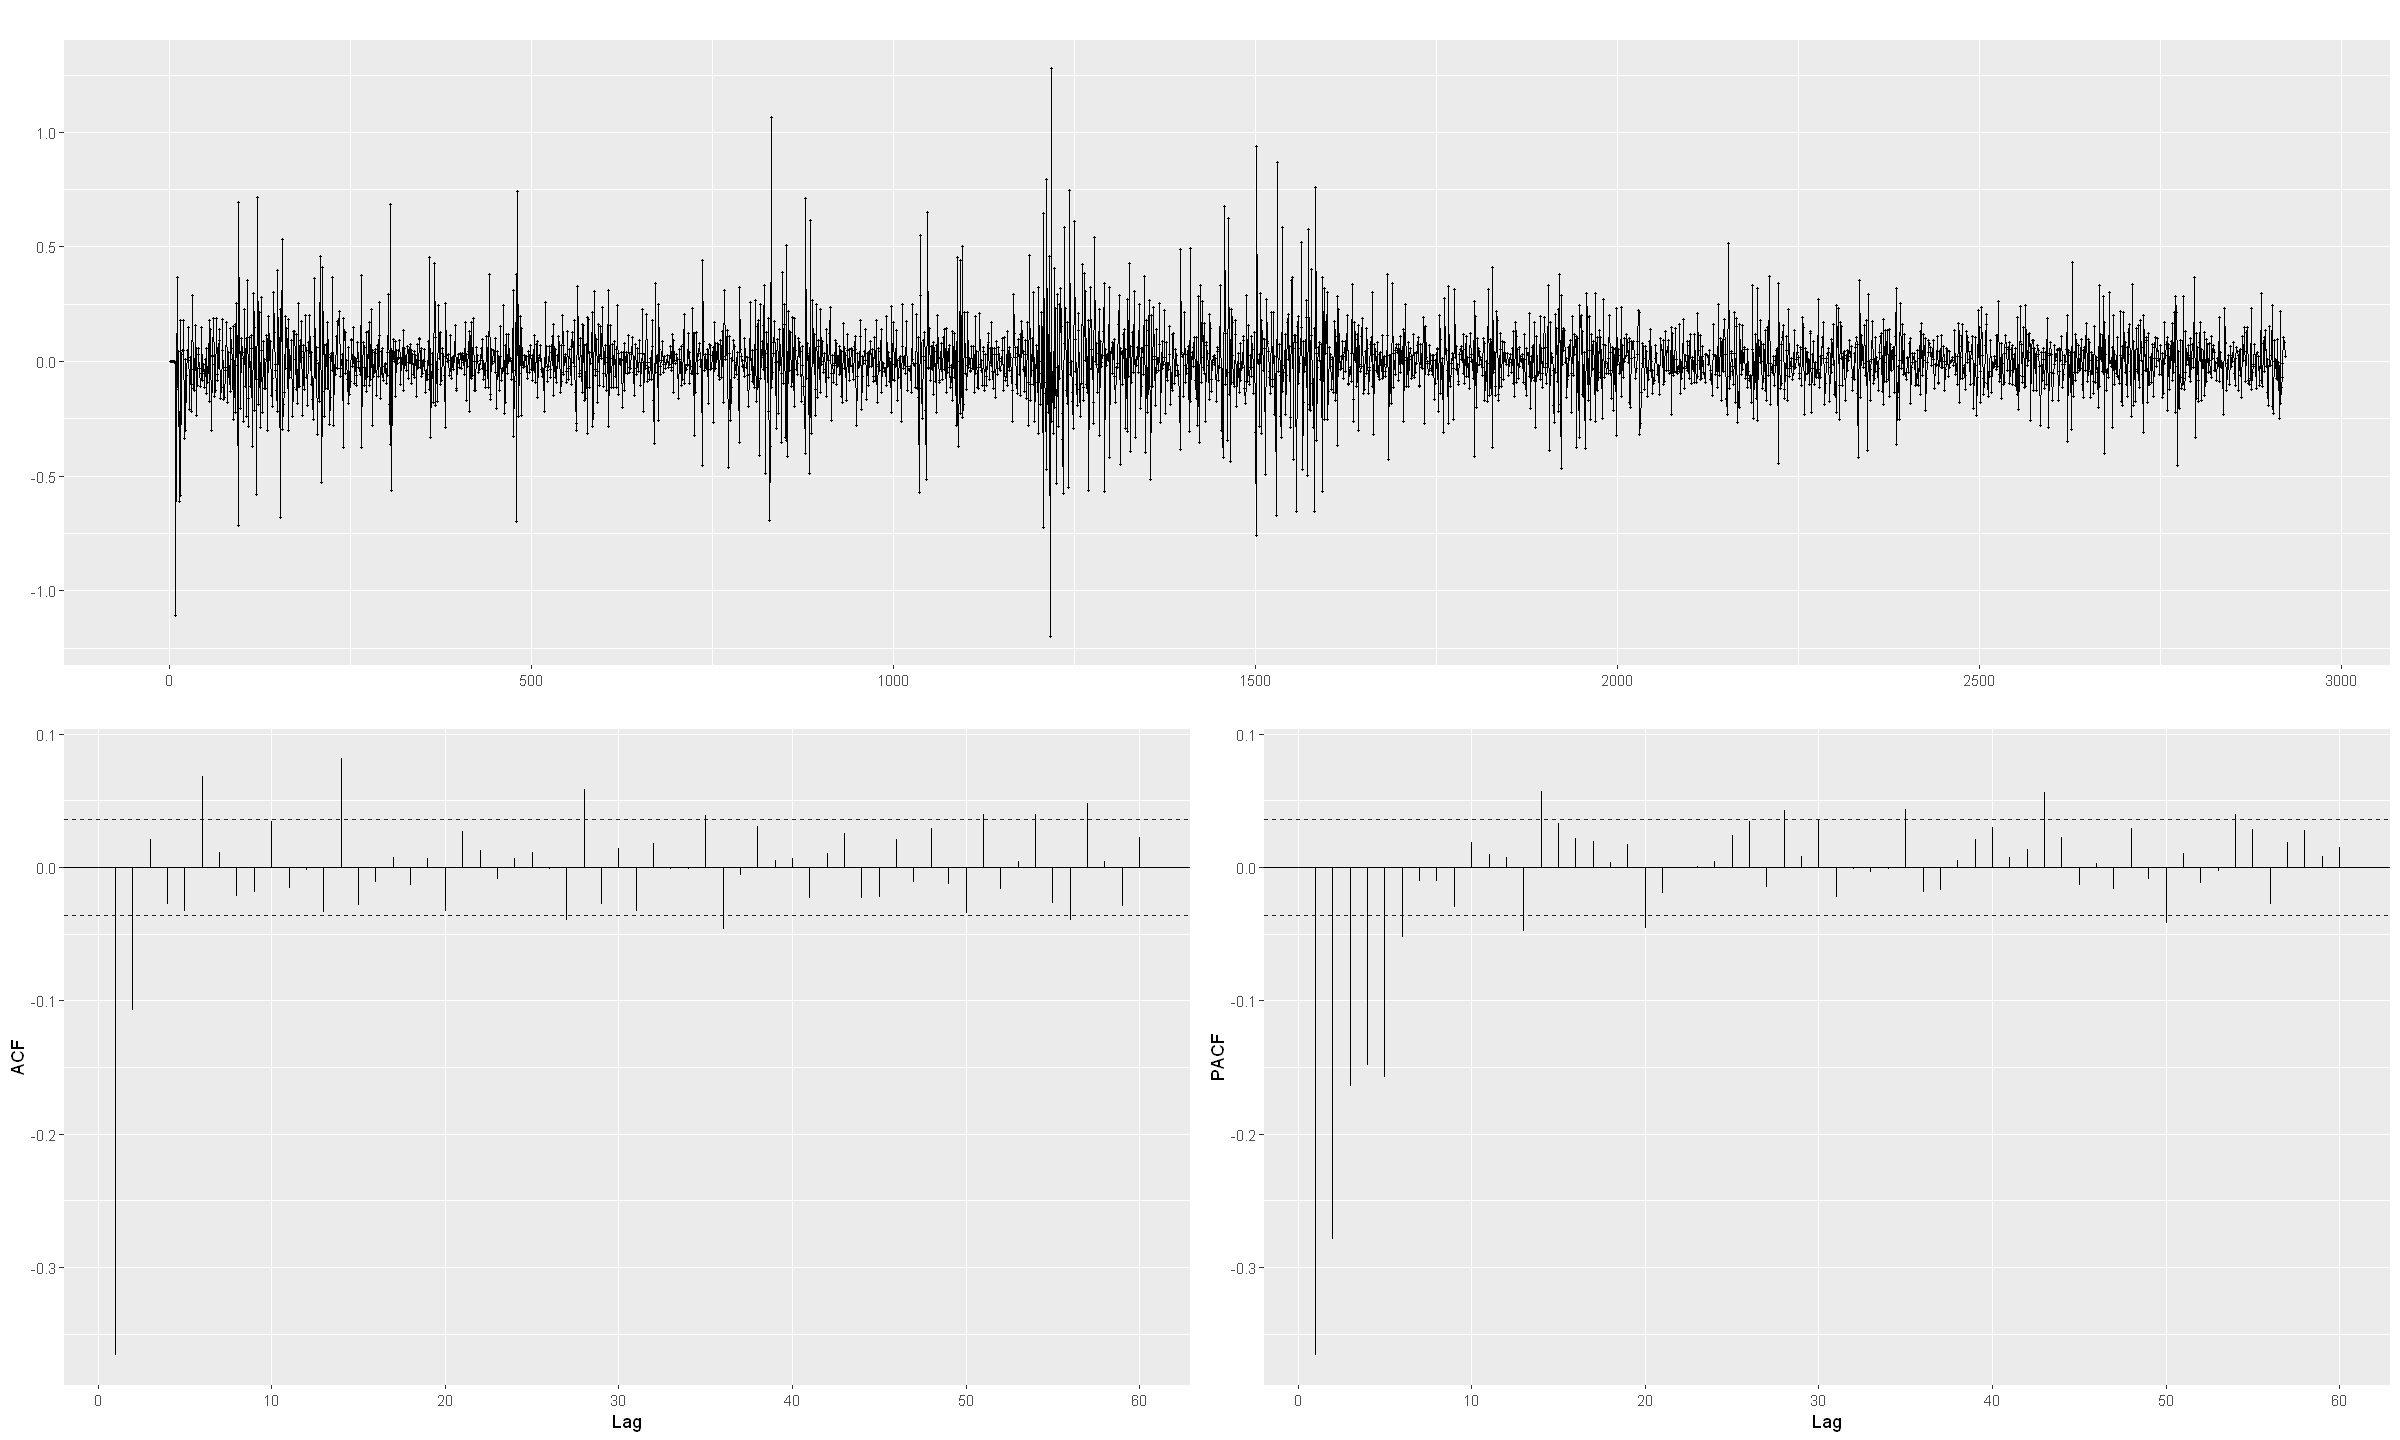

In [ ]:
#logaritmo e differenziazione
model5 <- Arima(train_data$value, c(0,1,0), list(order=c(1,1,1), period=7), lambda = 0)
ggtsdisplay(model5$residuals, lag.max = 60)
model5

le diverse componenti non sembrano immediate da analizzare, procedo quindi con un metodo greedy sui parametri di interesse

In [ ]:
#modello x,0,x,1,1,1 [7]
best_log=-9999999999999999999

for (i in 0:6){
    print("ciao")
    for (j in 0:6){
        temp<-Arima(train_data$value, c(i,0,j), list(order=c(1,1,1), period=7), lambda = "auto", method = "ML")
        if (temp$loglik>best_log){
            best_i<-i
            best_j<-j
            best_log<-temp$loglik
            
        }
        print(paste0("i=",i," j=",j, " log=",temp$loglik, " best_log=", best_log))}
}
i_model_1117<-best_i
j_model_1117<-best_j

In [ ]:
print(i_model_1117)
print(j_model_1117)

[1] 6
[1] 6


In [ ]:
#valuto con la integrazione vista in precenza
best_log=-9999999999999999999

for (i in 0:6){
  for (j in 0:6){
    try(temp<-Arima(train_data$value, c(i,1,j), list(order=c(1,1,1), period=7), lambda = "auto", method = "ML"))
    if (temp$loglik>best_log){
      best_i<-i
      best_j<-j
      best_log<-temp$loglik
    }
    print(paste0("i=",i," j=",j, " log=",temp$loglik, " best_log=", best_log))}
}


#la migliore soluzione sembra essere ar(6) ma(6) con componante stagionale a periodi di 7 giorni


In [ ]:
print(i_model_1117)
print(j_model_1117)

[1] 6
[1] 6


In [ ]:
#per i modelli log, il tempo di computazione risultava molto onerosa ho quindi deciso di procedere con auto.arima

model_log_stat=auto.arima(train_data$value,D=7,max.p = 6, max.q=6, max.P=1, max.Q=1, start.p = 0,start.q = 0, start.P = 1, start.Q = 1, stationary = TRUE, lambda = 0, seasonal = TRUE)
model_log=auto.arima(train_data$value,D=7,max.p = 6, max.q=6, max.P=1, max.Q=1, start.p = 0,start.q = 0, start.P = 1, start.Q = 1, stationary = FALSE, lambda = 0, seasonal = TRUE)


Series: train_data$value 
ARIMA(6,0,0) with non-zero mean 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6    mean
      0.4269  0.0002  0.1004  0.0657  0.0048  0.3139  4.7130
s.e.  0.0177  0.0194  0.0193  0.0193  0.0194  0.0177  0.0371

sigma^2 estimated as 0.03196:  log likelihood=886.92
AIC=-1757.84   AICc=-1757.79   BIC=-1710

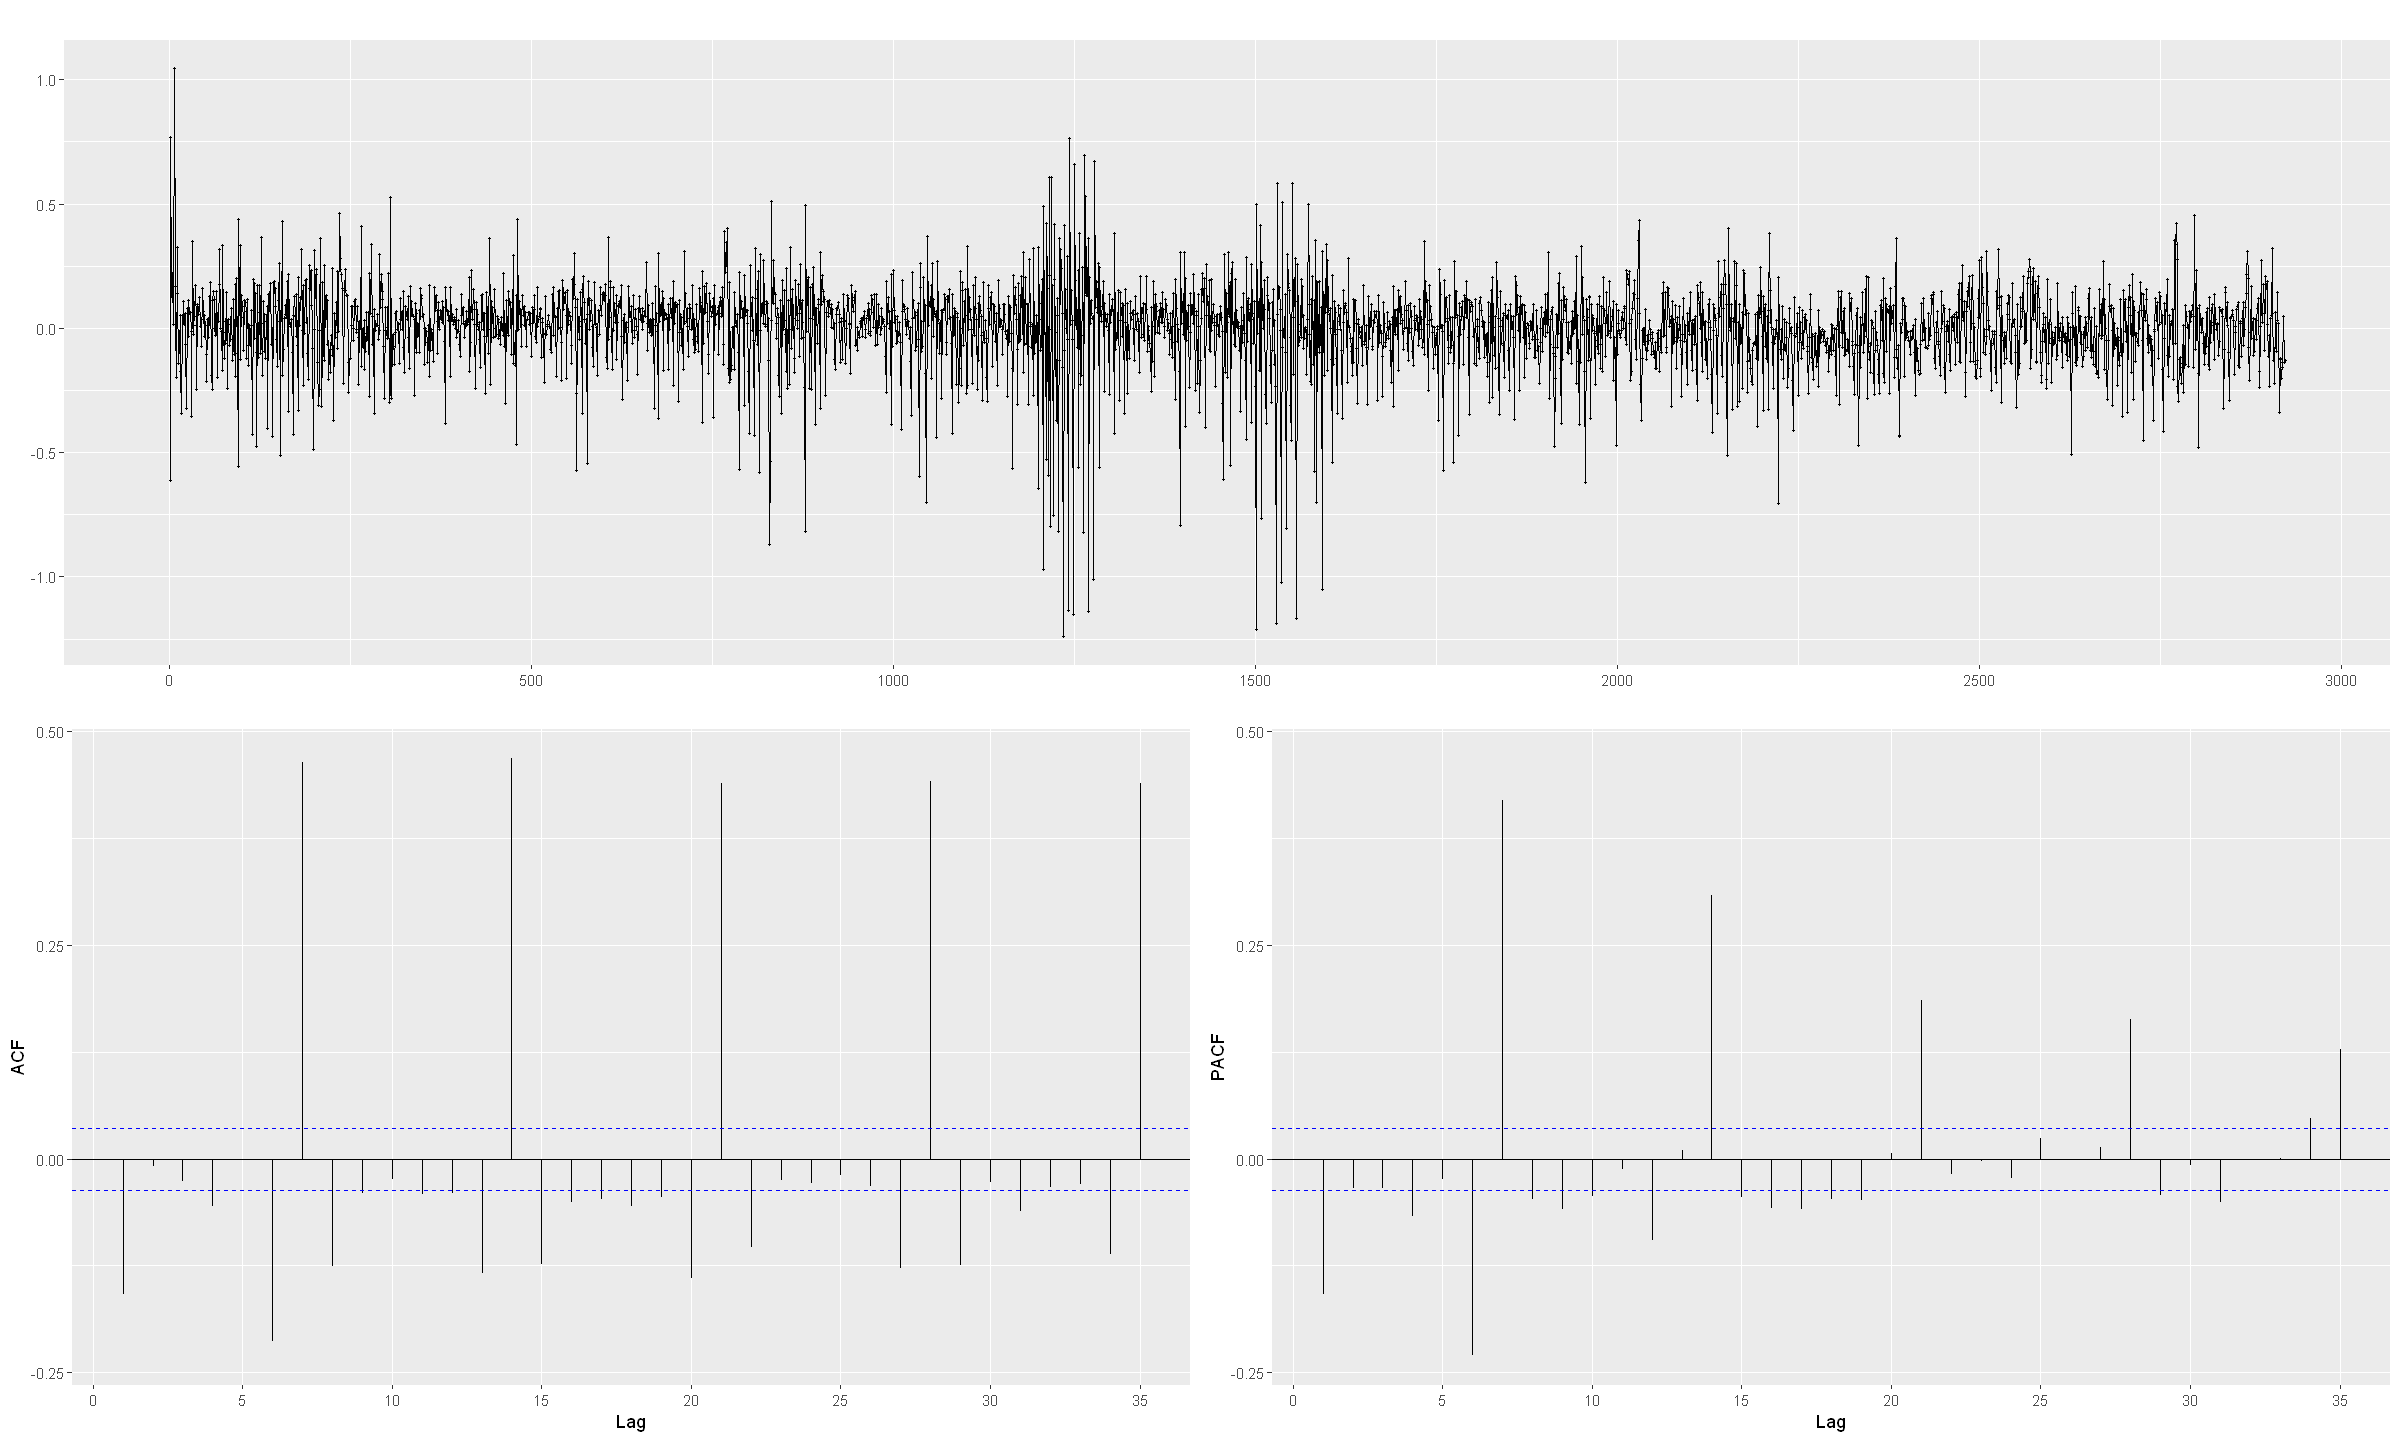

In [ ]:
ggtsdisplay(model_log_stat$residuals)
model_log_stat

Series: train_data$value 
ARIMA(6,1,2) 
Box Cox transformation: lambda= 0 

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ar6     ma1     ma2
      -0.8646  -0.8713  -0.7605  -0.7210  -0.6866  -0.5760  0.1981  0.1146
s.e.   0.0294   0.0280   0.0241   0.0227   0.0192   0.0164  0.0350  0.0360

sigma^2 estimated as 0.02342:  log likelihood=1340.56
AIC=-2663.12   AICc=-2663.06   BIC=-2609.3

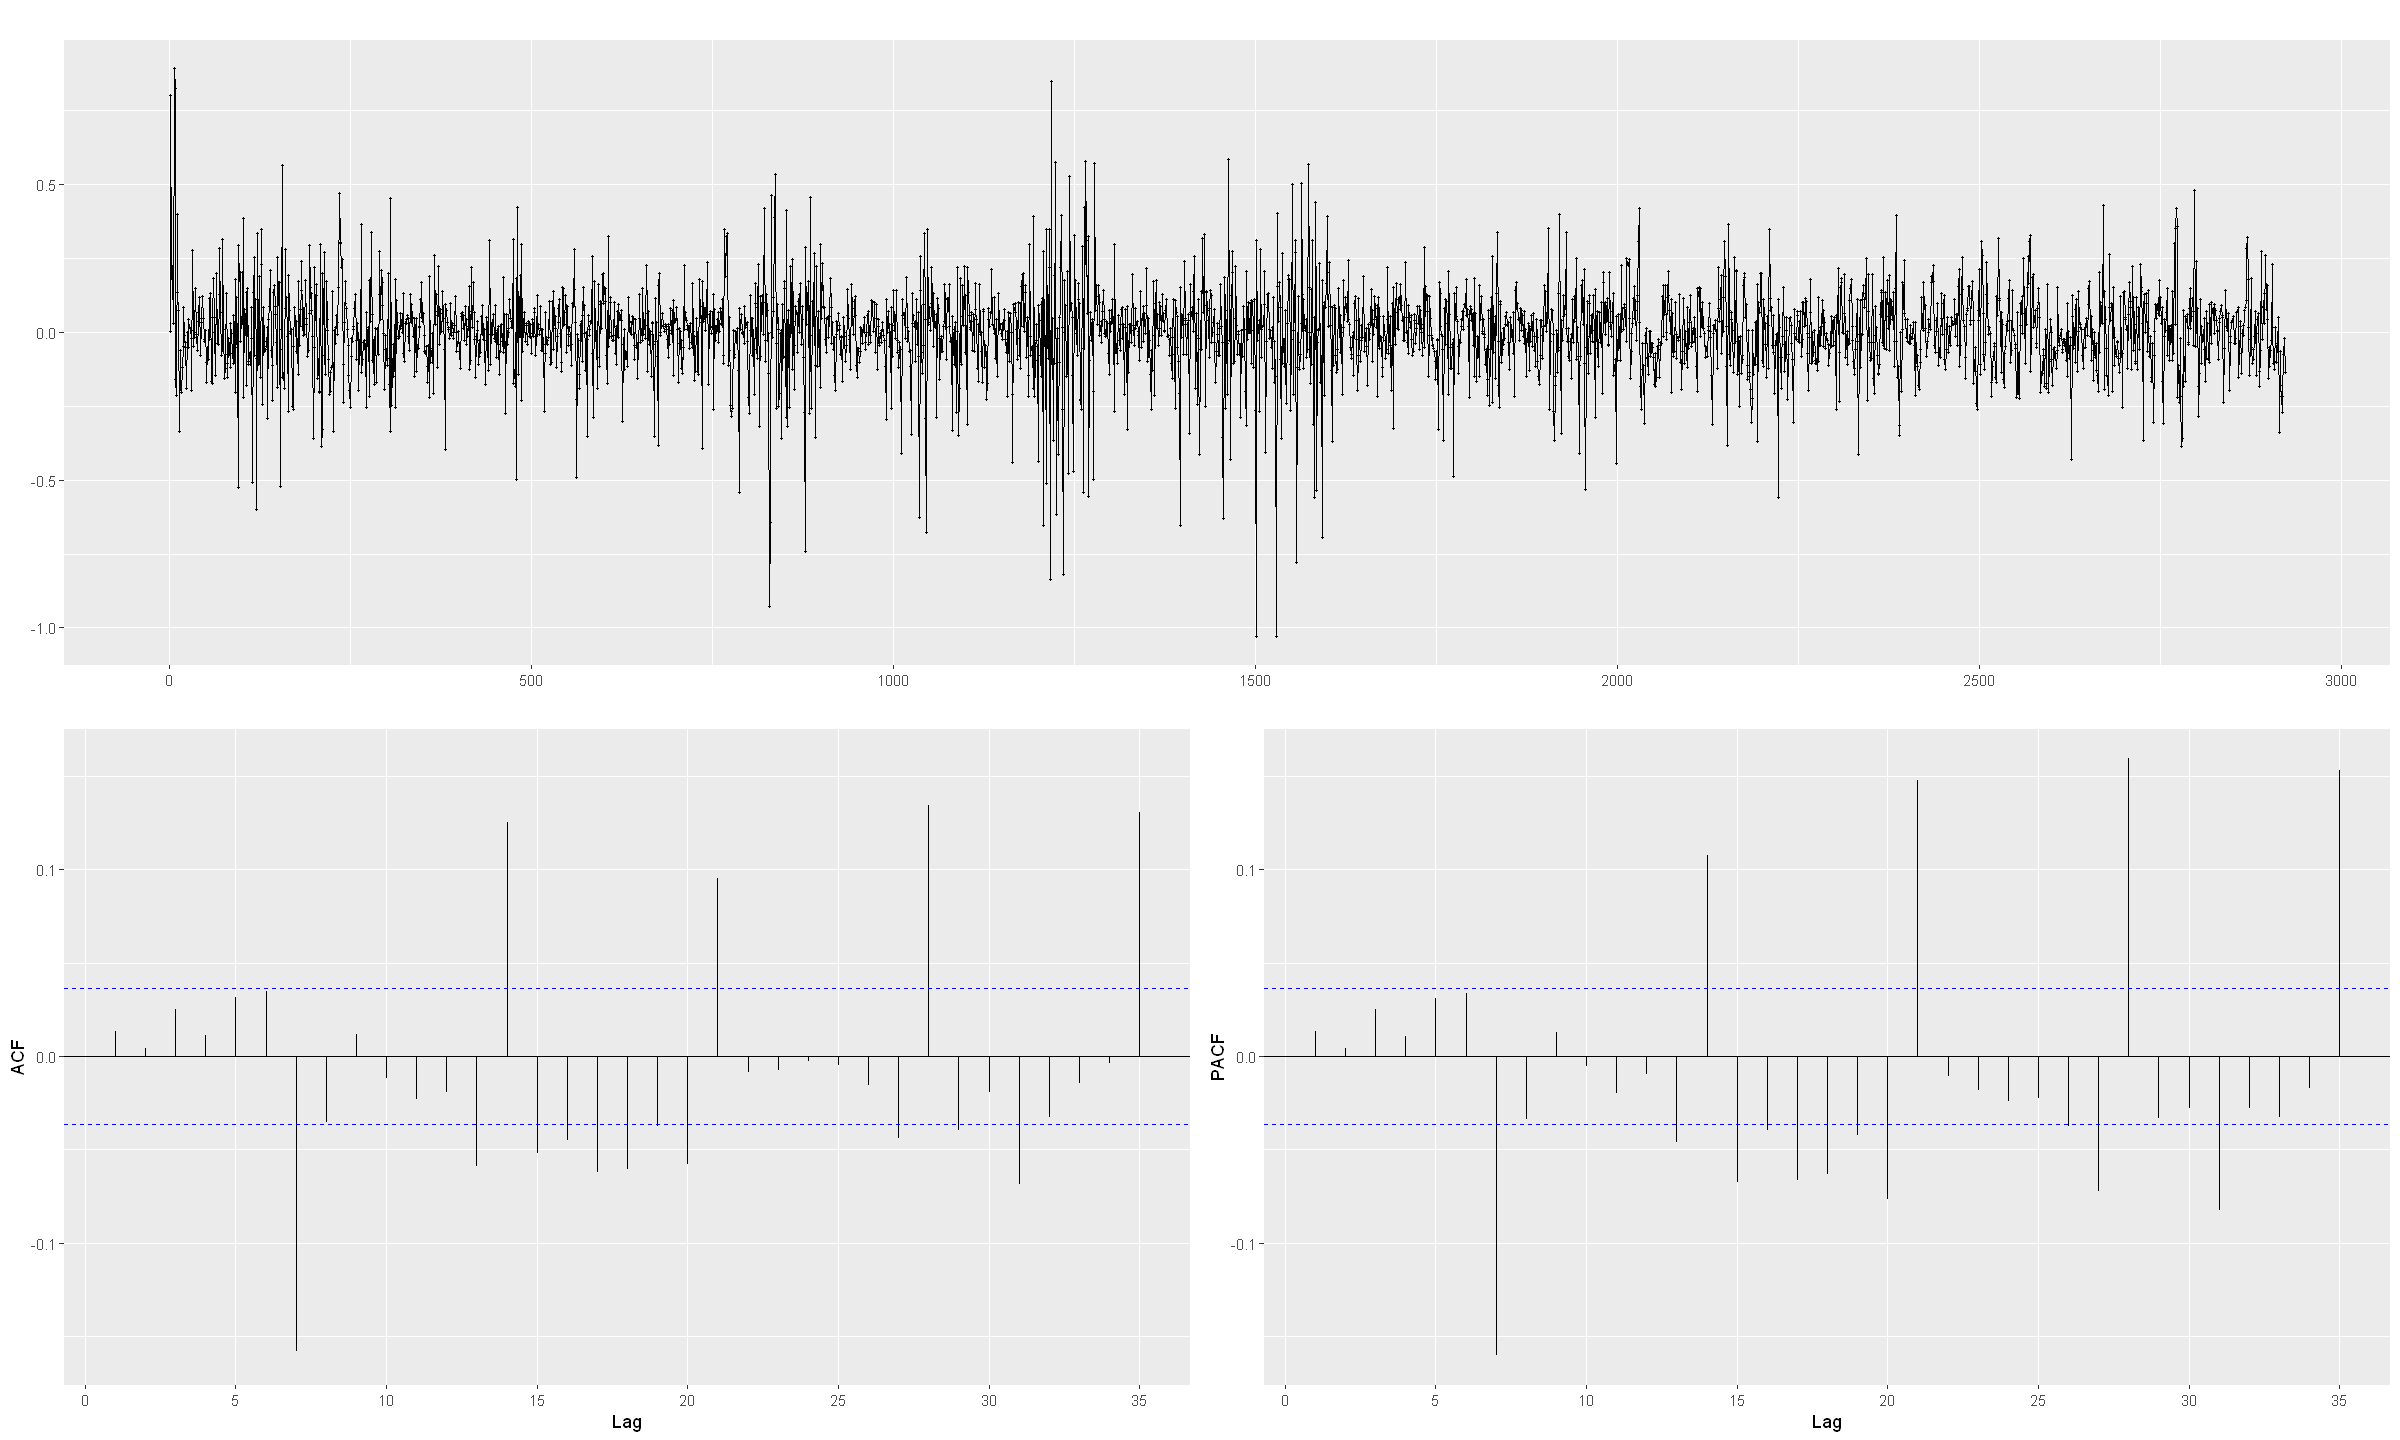

In [ ]:
ggtsdisplay(model_log$residuals)
model_log

ora uso i modelli creati dal ciclo for sulle serie [x,y,z] [1,1,1][7]

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


Series: train_data$value 
ARIMA(6,0,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9437982 

Coefficients:
          ar1     ar2     ar3     ar4     ar5      ar6     ma1     ma2     ma3
      -0.0107  0.0765  0.1491  0.7445  0.1671  -0.2097  0.4209  0.1639  0.0483
s.e.      NaN  0.0942     NaN  0.0542     NaN   0.1095     NaN  0.1333     NaN
          ma4      ma5     ma6    sar1     sma1
      -0.6329  -0.3629  0.1460  0.1322  -0.9682
s.e.   0.0657      NaN  0.0721  0.0272   0.0063

sigma^2 estimated as 125.3:  log likelihood=-11178.79
AIC=22387.58   AICc=22387.75   BIC=22477.25

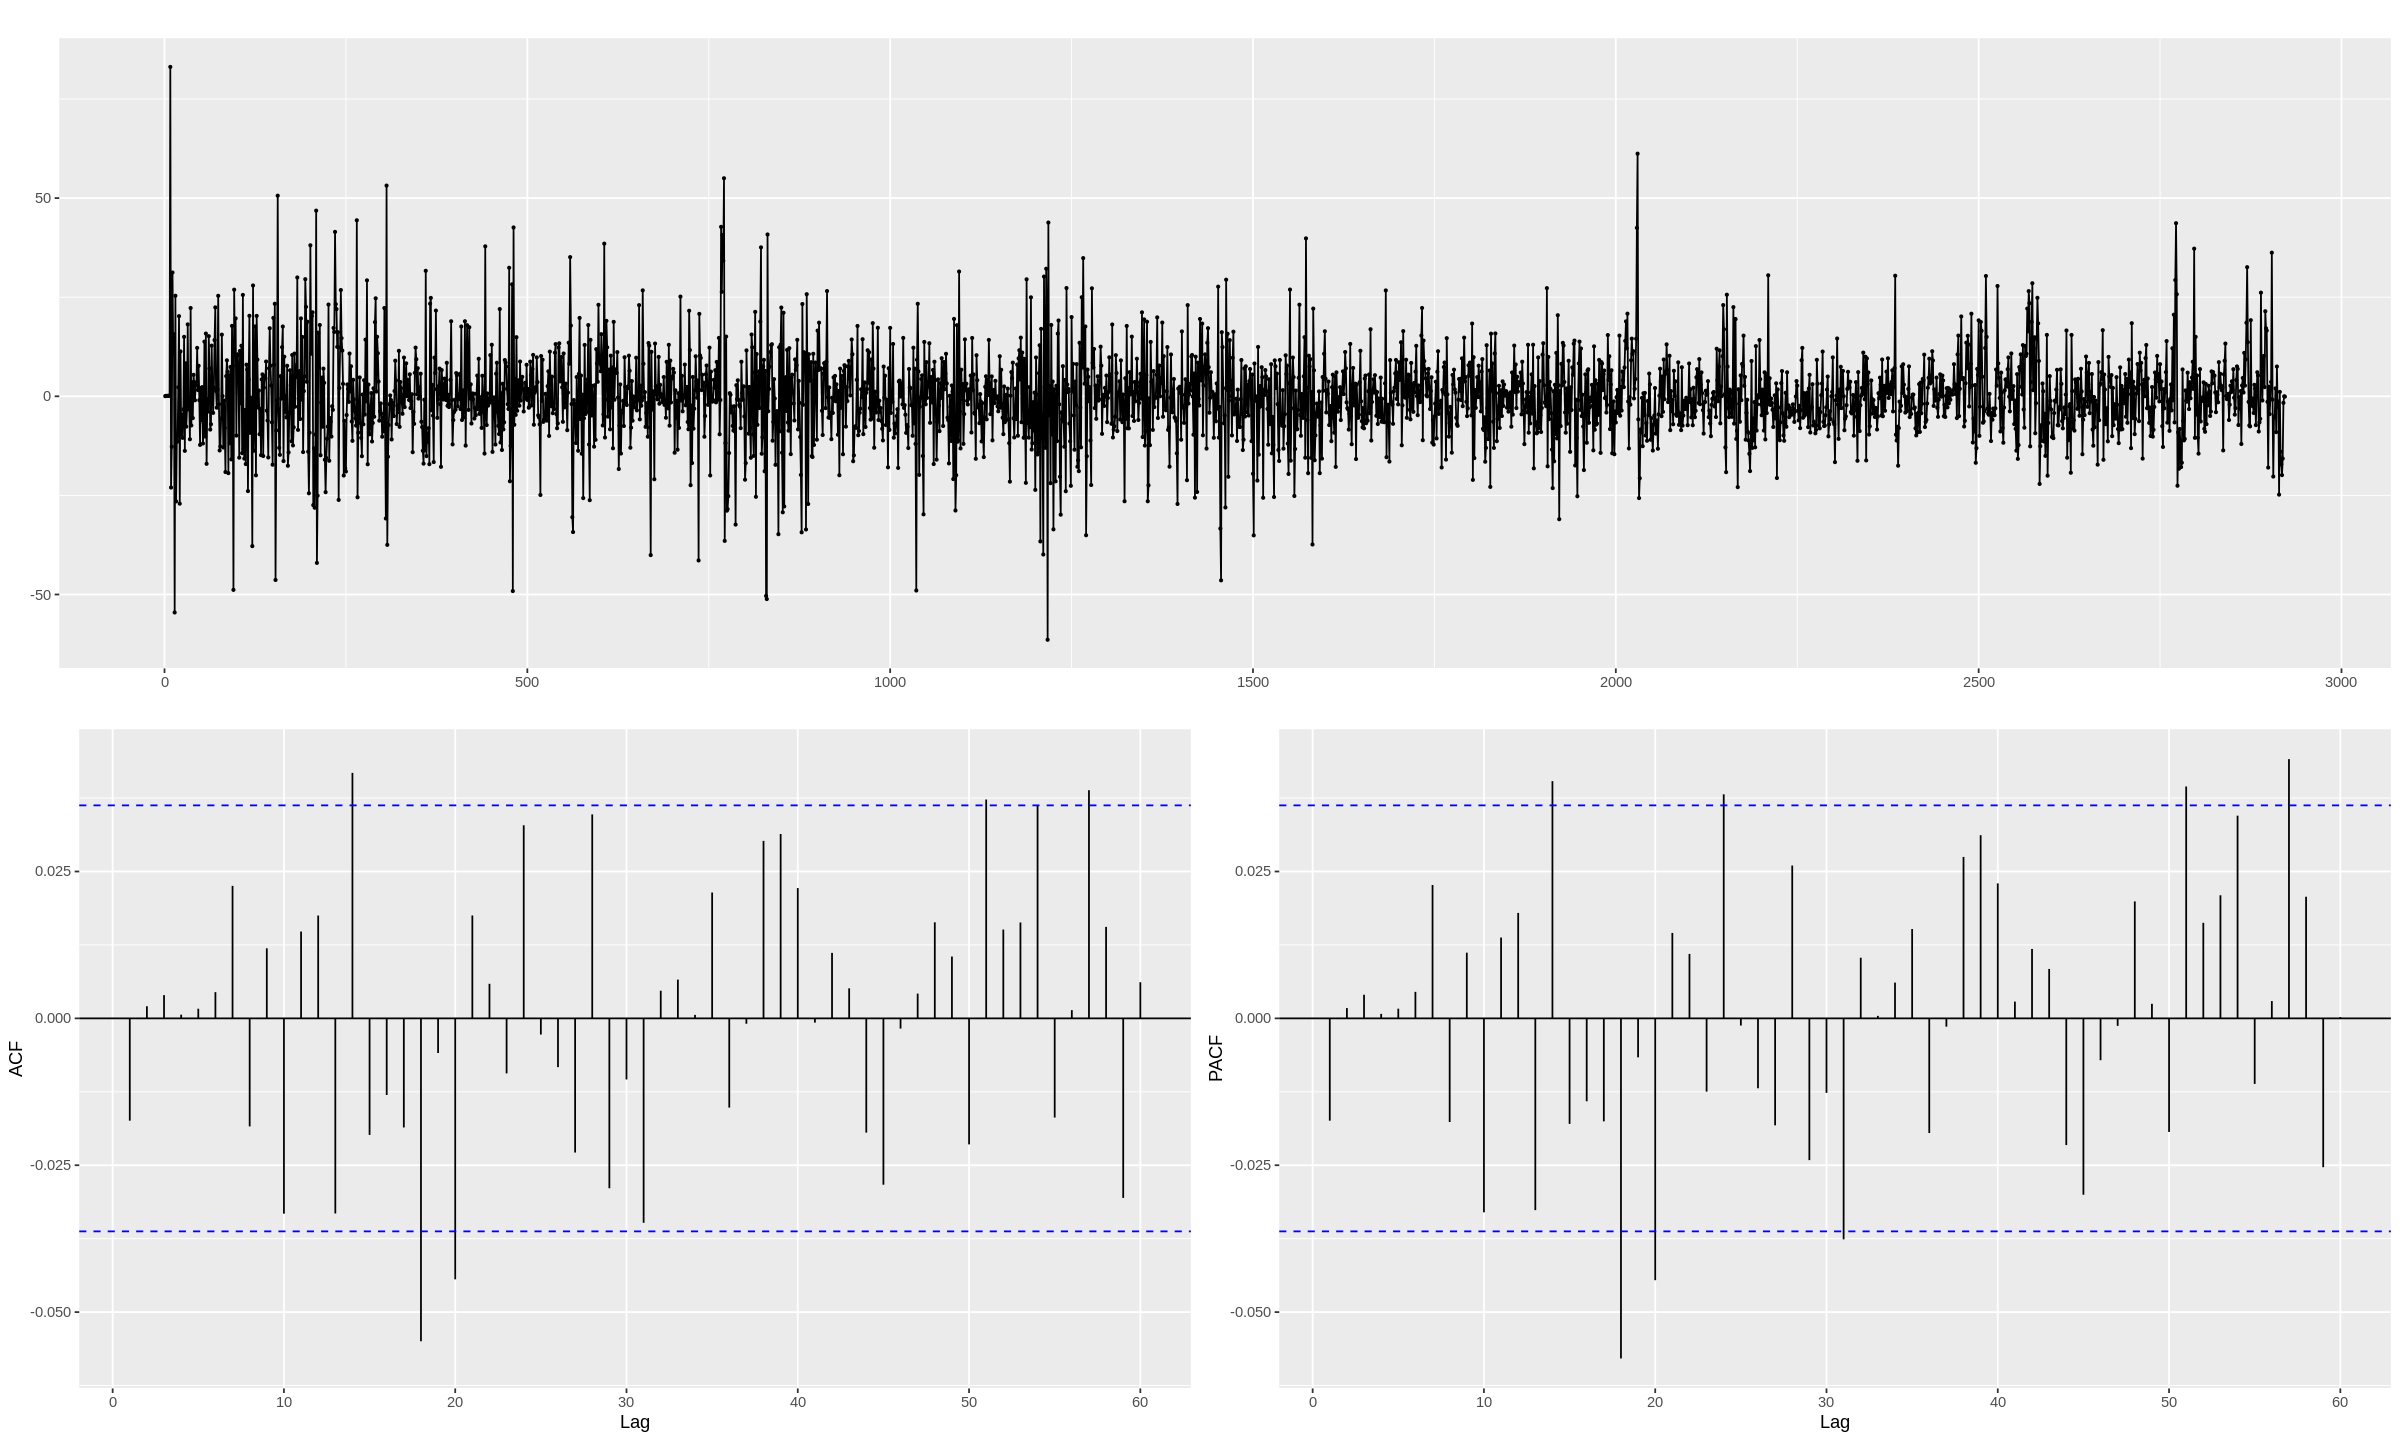

In [ ]:
###############################
model6 <- Arima(train_data$value, c(6,0,6), list(order=c(1,1,1), period=7), lambda = "auto", method = "ML")
ggtsdisplay(model6$residuals, lag.max = 60)
model6


Series: train_data$value 
ARIMA(6,1,6)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9437982 

Coefficients:
          ar1      ar2      ar3      ar4     ar5    ar6     ma1      ma2
      -0.7094  -0.4131  -0.1699  -0.0040  0.1671  0.267  0.1241  -0.1825
s.e.   0.1025   0.1363   0.1183   0.1139  0.0730  0.041  0.1045   0.1038
          ma3      ma4      ma5      ma6    sar1     sma1
      -0.2037  -0.1929  -0.2455  -0.1256  0.2880  -0.9764
s.e.   0.0984   0.1223   0.0828   0.0834  0.0298   0.0051

sigma^2 estimated as 125.9:  log likelihood=-11184.64
AIC=22399.28   AICc=22399.45   BIC=22488.94

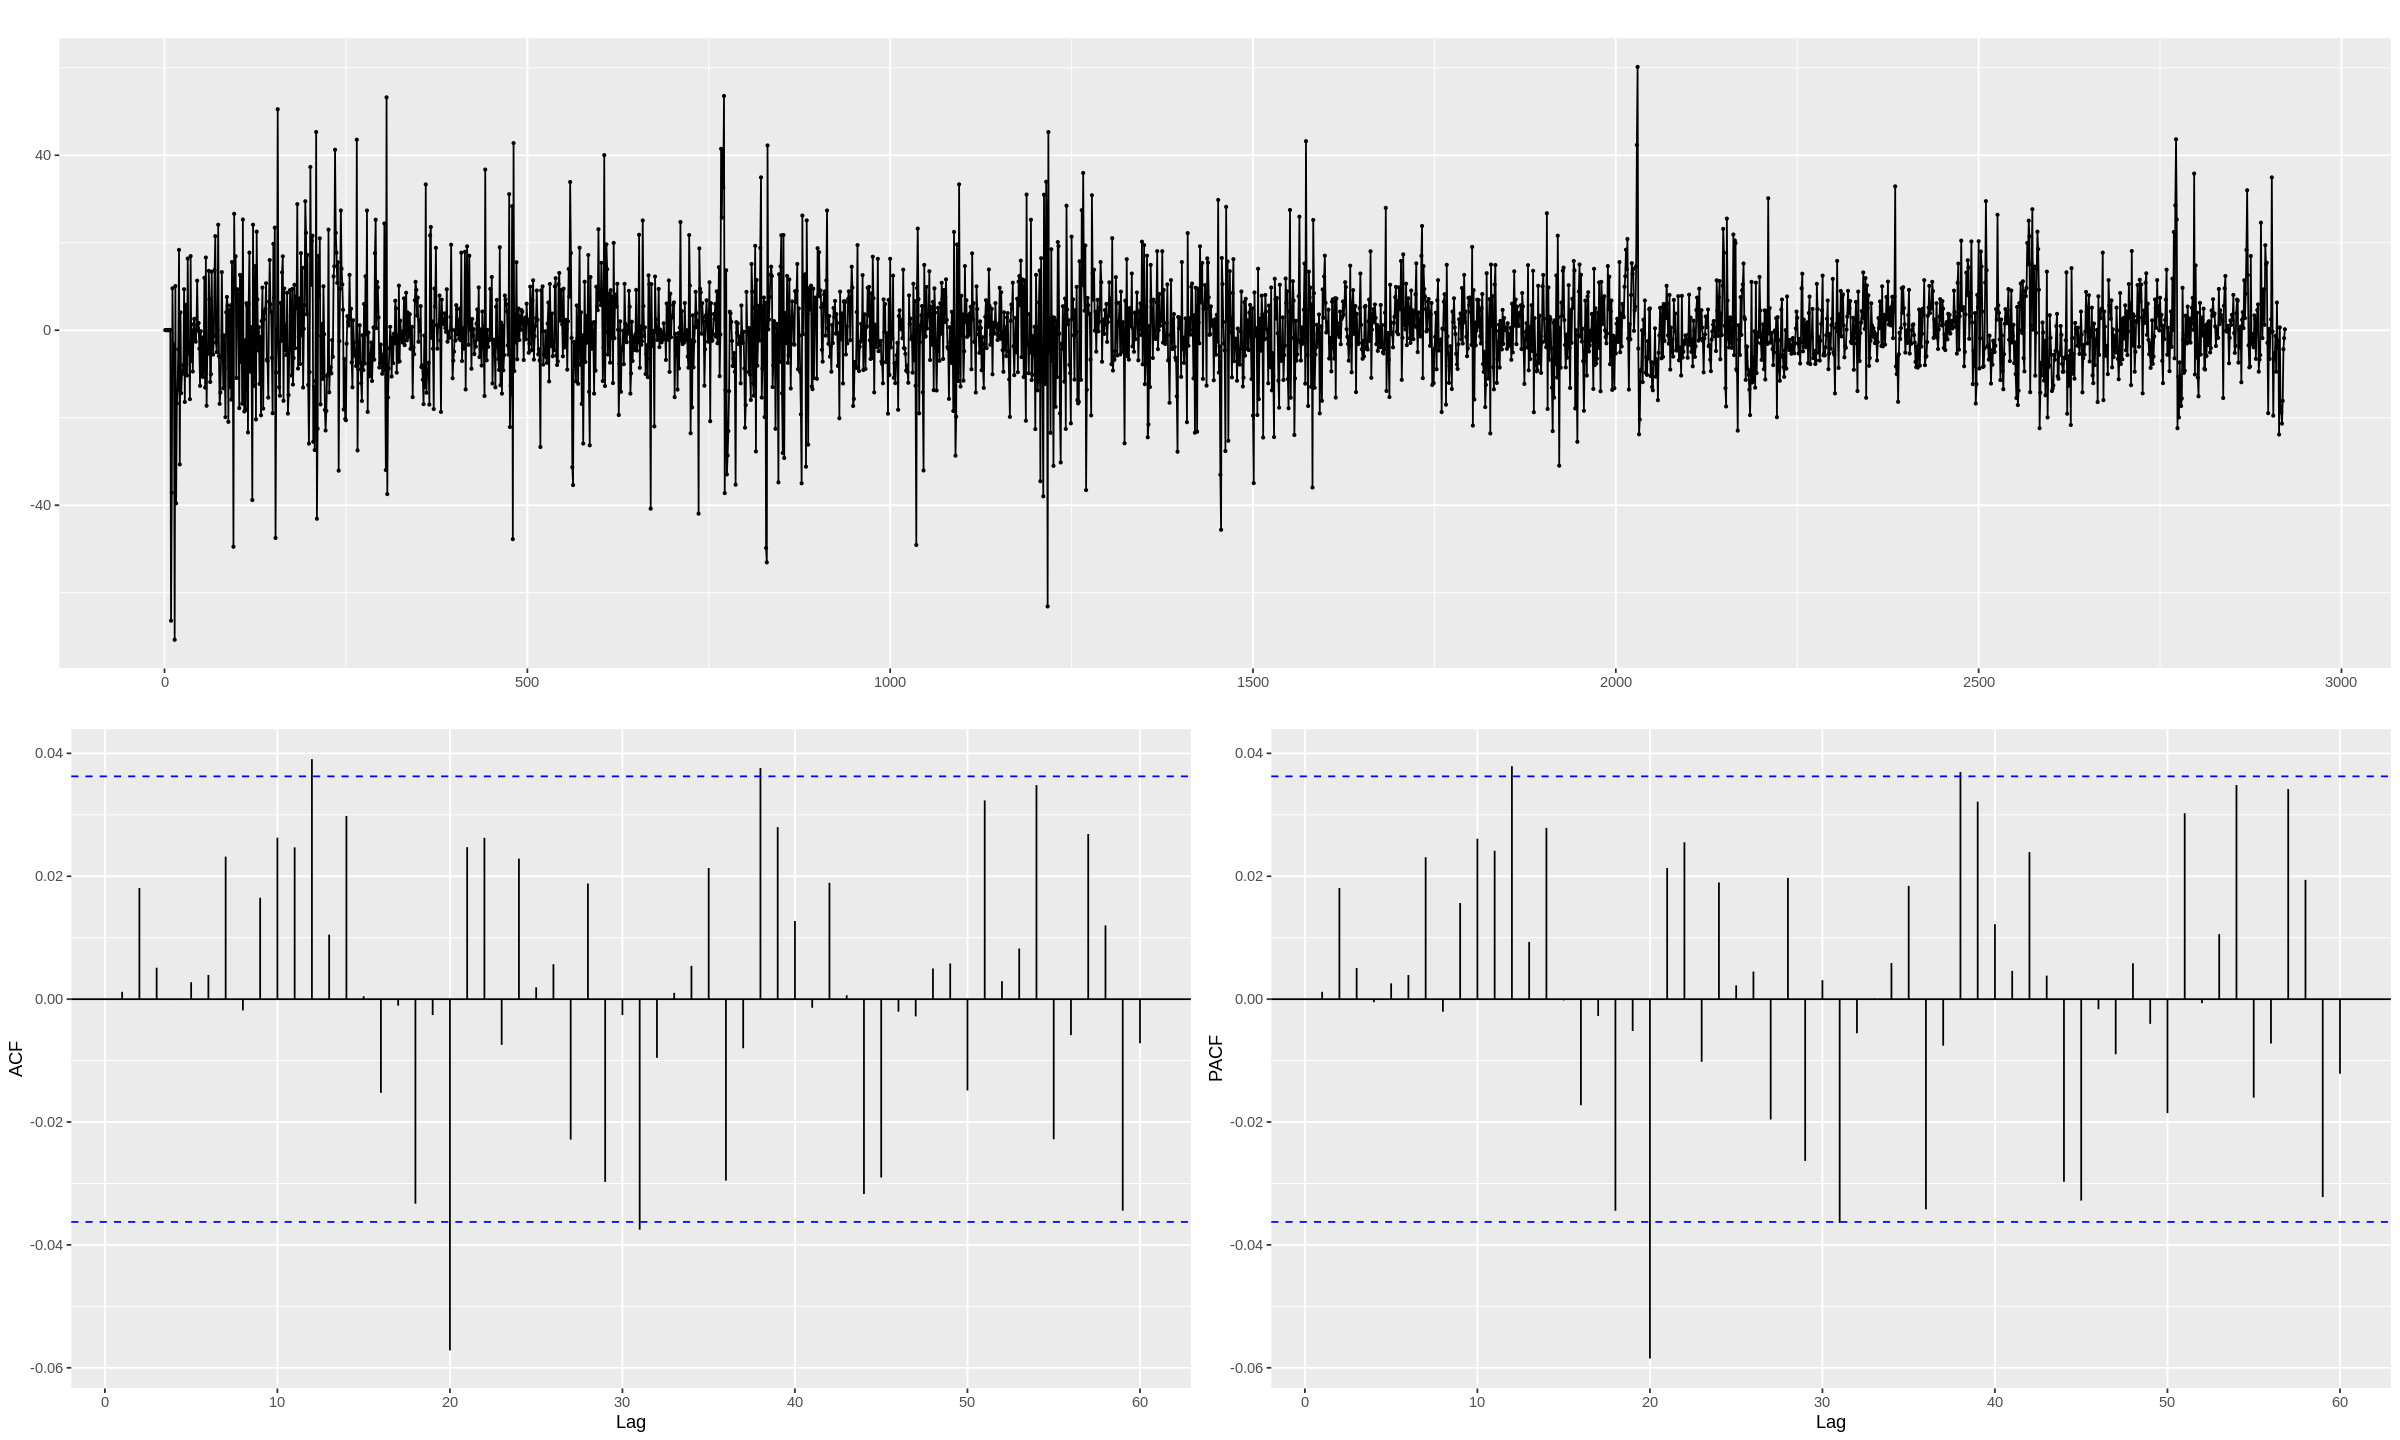

In [ ]:
#in pochi casi i ritardi superano il range di confidenza in maniera lieve, la situazione sembra essere però molto migliore rispetto allo scorso ACF/PACF
model7 <- Arima(train_data$value, c(6,1,6), list(order=c(1,1,1), period=7), lambda = "auto", method = "ML")
ggtsdisplay(model7$residuals, lag.max = 60)
model7

usando la differenziazione notiamo come i ritardi siano rientrati (eccetto per il 20esimo ritardo) procediamo quindi a valutare entrambi i modelli sul train set


Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"
Warning message:
"Ignoring unknown parameters: linewidth"


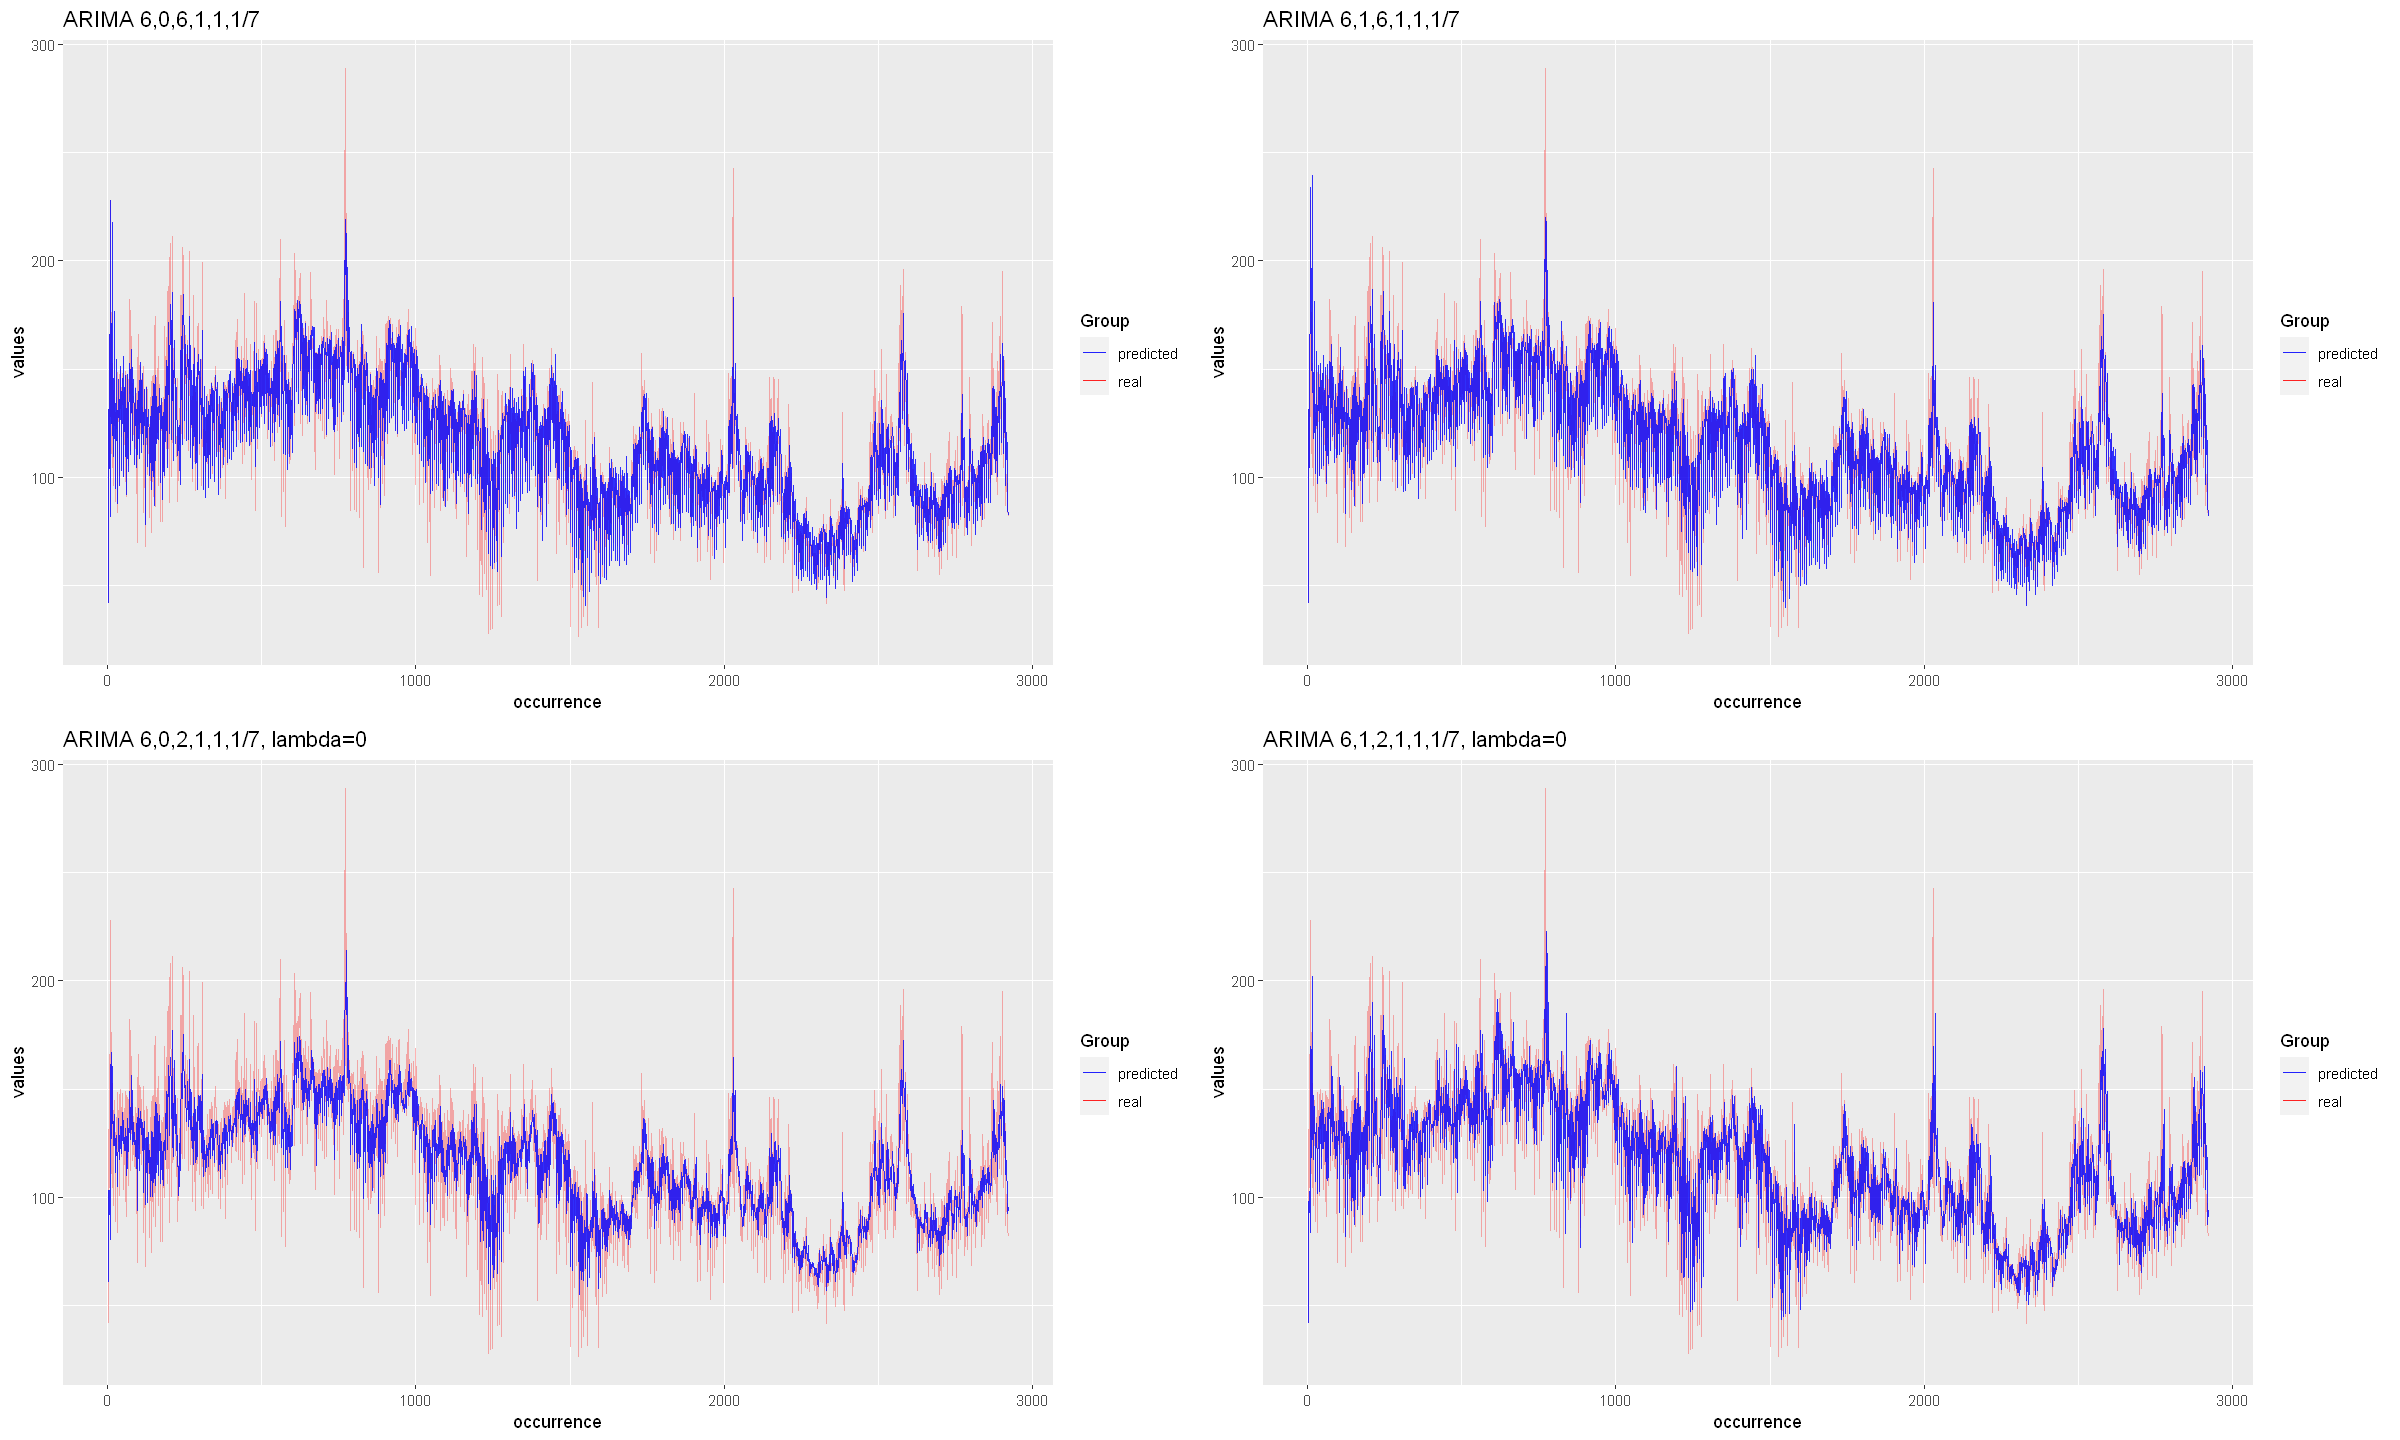

In [ ]:
graph_normal=ggplot(iris)+
  geom_line(data=data.frame(values=as.numeric(train_data$value), occurrence=as.numeric(time(train_data$value))),linewidth=2,alpha=0.3, aes(x=occurrence, y=values, color="real"))+
  geom_line(data=model6$fitted, linewidth=1,alpha=0.8, aes(x=time(model6$fitted), y=model6$fitted,color="predicted"))+
  scale_color_manual(name = "Group",
                     values = c( "predicted" = "blue", "real" = "red"),
                     labels = c("predicted", "real"))+
  ggtitle("ARIMA 6,0,6,1,1,1/7") 

graph_integration=ggplot(iris)+
  geom_line(data=data.frame(values=as.numeric(train_data$value), occurrence=as.numeric(time(train_data$value))),linewidth=2,alpha=0.3, aes(x=occurrence, y=values, color="real"))+
  geom_line(data=model7$fitted, linewidth=1,alpha=0.8, aes(x=time(model7$fitted), y=model7$fitted,color="predicted"))+
  scale_color_manual(name = "Group",
                     values = c( "predicted" = "blue", "real" = "red"),
                     labels = c("predicted", "real"))+
  ggtitle("ARIMA 6,1,6,1,1,1/7") 

graph_log_stat=ggplot(iris)+
  geom_line(data=data.frame(values=as.numeric(train_data$value), occurrence=as.numeric(time(train_data$value))),linewidth=2,alpha=0.3, aes(x=occurrence, y=values, color="real"))+
  geom_line(data=model_log_stat$fitted, linewidth=1,alpha=0.8, aes(x=time(model_log_stat$fitted), y=model_log_stat$fitted,color="predicted"))+
  scale_color_manual(name = "Group",
                     values = c( "predicted" = "blue", "real" = "red"),
                     labels = c("predicted", "real"))+
  ggtitle("ARIMA 6,0,2,1,1,1/7, lambda=0") 

graph_log=ggplot(iris)+
  geom_line(data=data.frame(values=as.numeric(train_data$value), occurrence=as.numeric(time(train_data$value))),linewidth=2,alpha=0.3, aes(x=occurrence, y=values, color="real"))+
  geom_line(data=model_log$fitted, linewidth=1,alpha=0.8, aes(x=time(model_log$fitted), y=model_log$fitted,color="predicted"))+
  scale_color_manual(name = "Group",
                     values = c( "predicted" = "blue", "real" = "red"),
                     labels = c("predicted", "real"))+
  ggtitle("ARIMA 6,1,2,1,1,1/7, lambda=0") 



gridExtra::grid.arrange(graph_normal, graph_integration, graph_log_stat, graph_log)


In [ ]:
install.packages("Metrics")
library(Metrics)

mse(train_data$value, fitted(model6))
mape(train_data$value, fitted(model6))
mse(train_data$value, fitted(model7))
mape(train_data$value, fitted(model7))
mse(train_data$value, fitted(model_log))
mape(train_data$value, fitted(model_log))
mse(train_data$value, fitted(model_log_stat))
mape(train_data$value, fitted(model_log_stat))

Warning message:
"package 'Metrics' was built under R version 3.5.3"

Attaching package: 'Metrics'


The following object is masked from 'package:forecast':

    accuracy




[1] 213.1146

[1] 0.09611582

[1] 214.1879

[1] 0.09655631

[1] 280.2691

[1] 0.1076797

[1] 345.1488

[1] 0.1277176

non notiamo grandi differenze nei due modelli per quanto riguarda il trainset, 
si nota inoltre come il modello non sia in grado di identificare i picchi che quindi rimarrebbero non soddisfatti
in caso di previsione della domanda

In [ ]:
mape(test_data$value, forecast(model6, h=365)$mean)
mse(test_data$value, forecast(model6, h=365)$mean)
mape(test_data$value, forecast(model7, h=365)$mean)
mse(test_data$value, forecast(model7, h=365)$mean)
mape(test_data$value, forecast(model_log, h=365)$mean)
mse(test_data$value, forecast(model_log, h=365)$mean)
mape(test_data$value, forecast(model_log_stat, h=365)$mean)
mse(test_data$value, forecast(model_log_stat, h=365)$mean)

[1] 0.1660839

[1] 819.6941

[1] 0.1378351

[1] 405.979

[1] 0.2357388

[1] 1474.101

[1] 0.1514512

[1] 652.43

scelgo quindi il model7 616 111 7 in quanto restittuisce i migliori valori in termini di errore sia mape che mse

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”


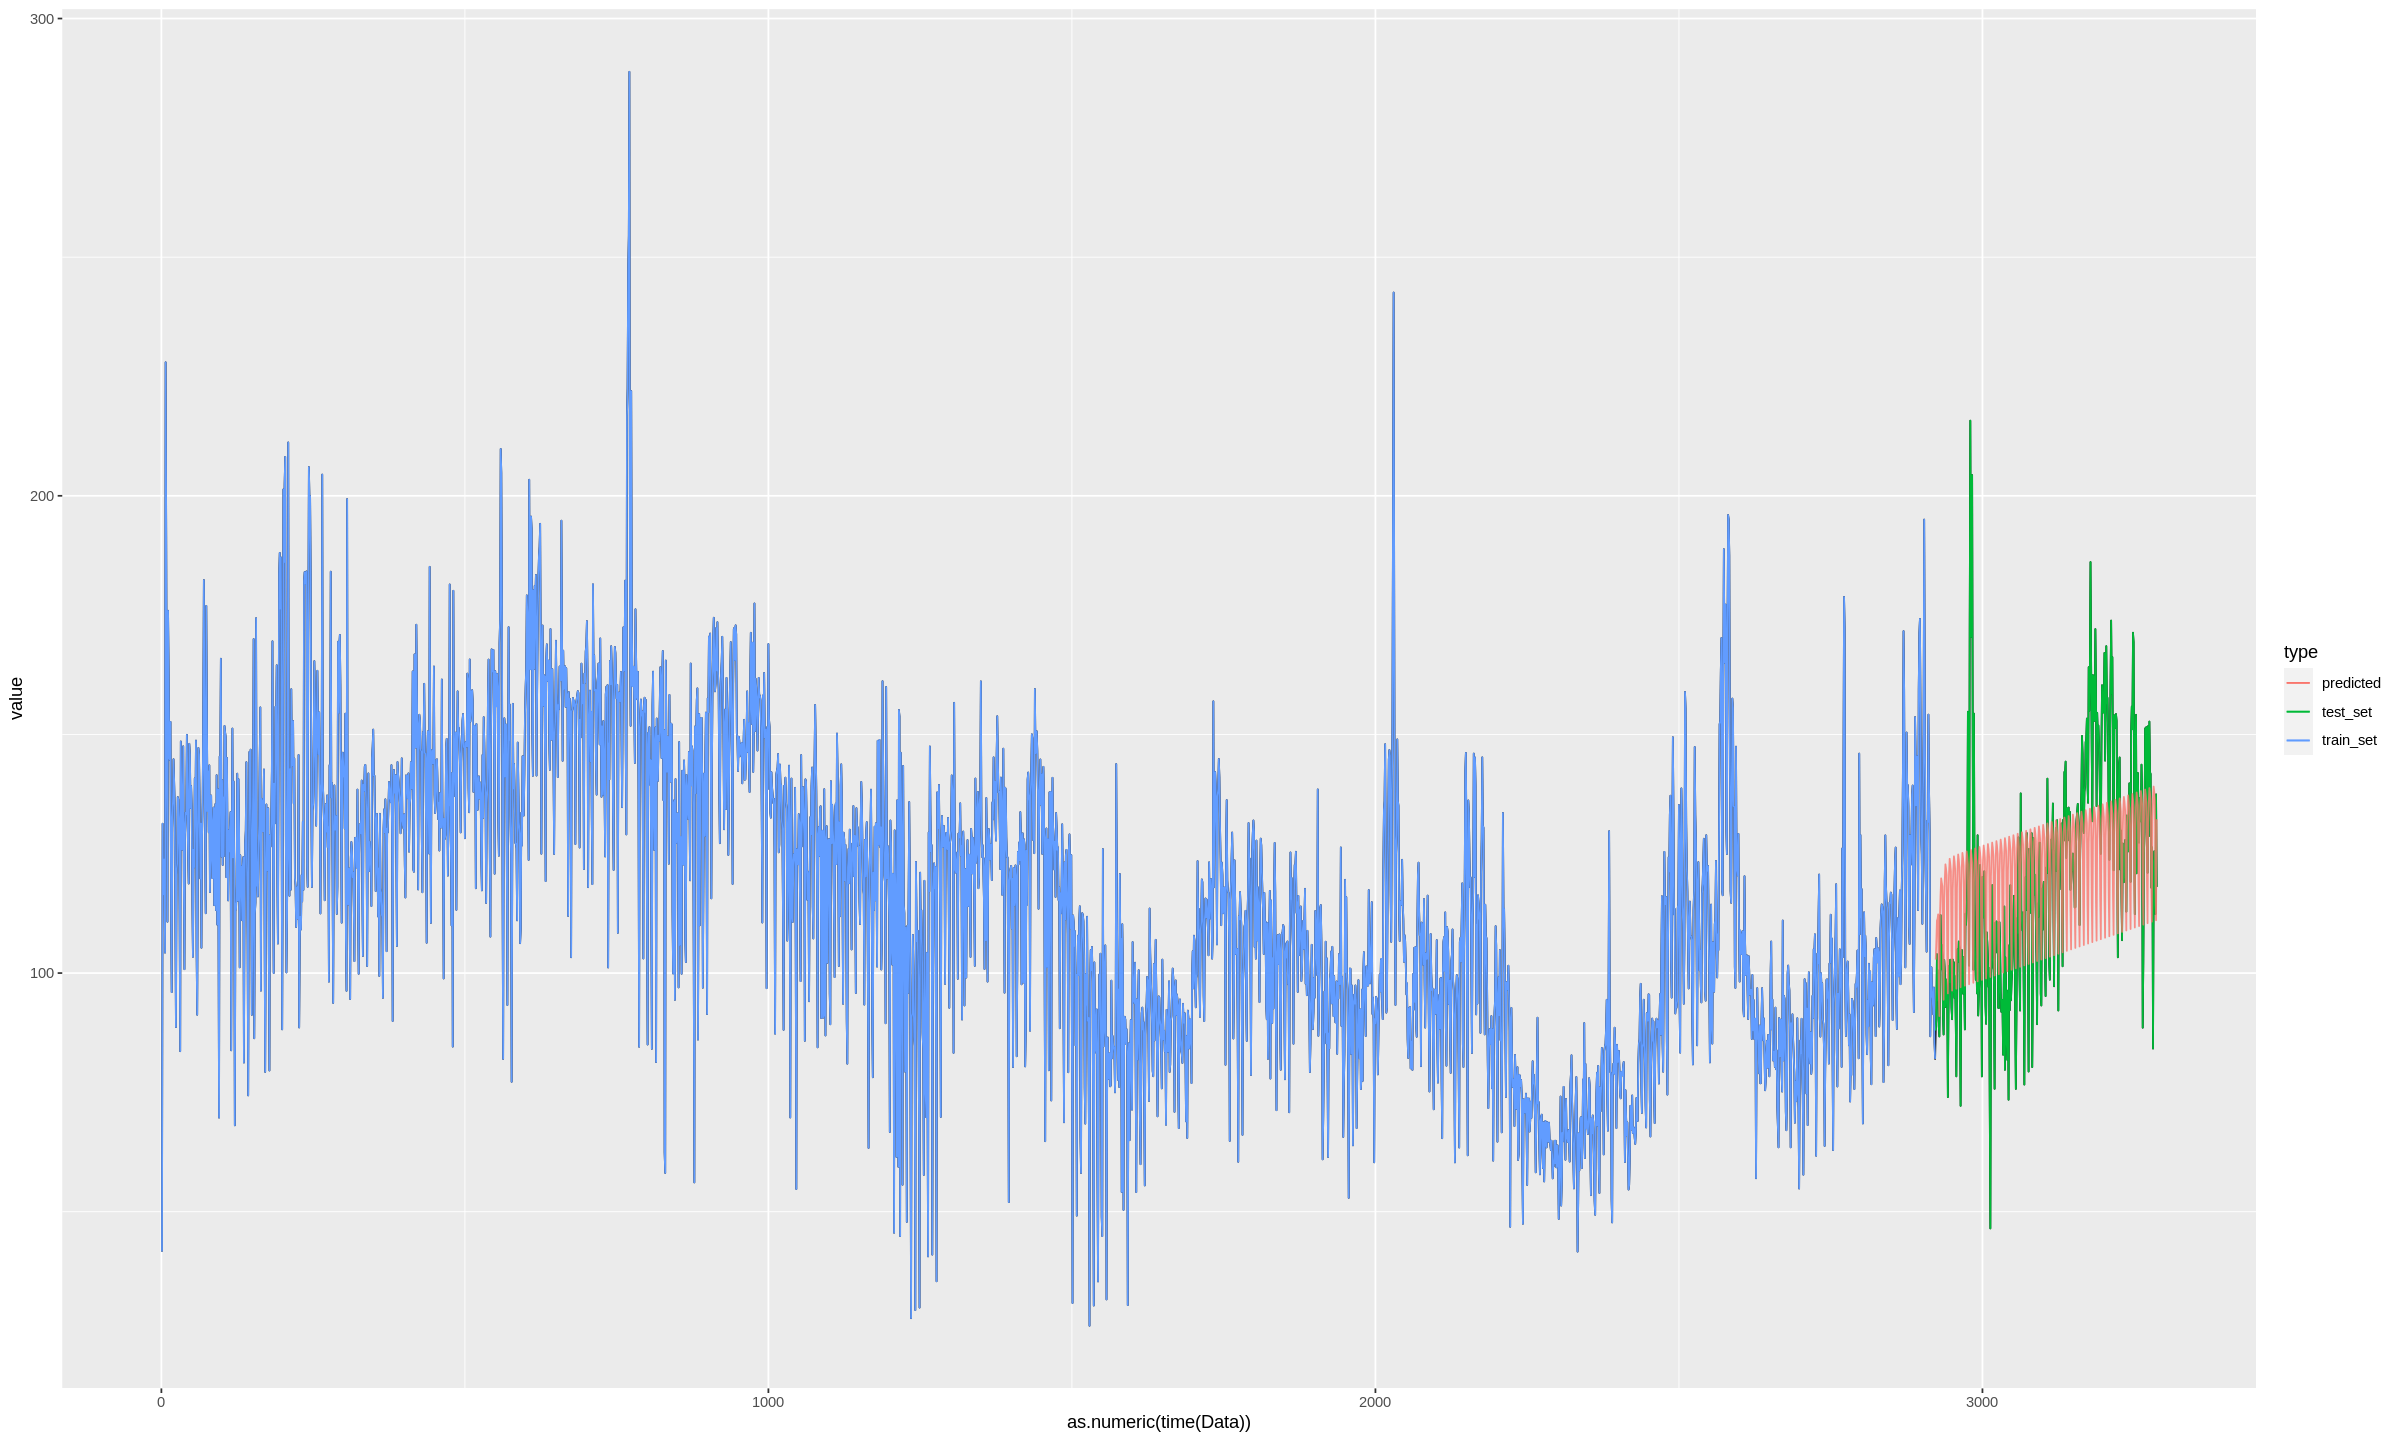

In [ ]:
graph_integration=ggplot(iris)+
  geom_line(data=data.frame(values=as.numeric(train_data$value), occurrence=as.numeric(time(train_data$value))),linewidth=2,alpha=0.3, aes(x=occurrence, y=values, color="real"))+
  geom_line(data=model7$fitted, linewidth=1,alpha=0.8, aes(x=time(model7$fitted), y=model7$fitted,color="predicted"))+
  scale_color_manual(name = "Group",
                     values = c( "predicted" = "blue", "real" = "red"),
                     labels = c("predicted", "real"))+
  ggtitle("ARIMA 6,1,6,1,1,1/7") 

ggplot()+
  geom_line(data=dat,aes(x=as.numeric(time(Data)),y=value))+
  geom_line(data=dat,aes(x=as.numeric(time(Data)),y=value,color=type))+
  geom_line(data=forecast(model7, h=365)$mean, linewidth=1,alpha=0.8, aes(x=time(forecast(model7, h=365)$mean), y=forecast(model7, h=365)$mean,color="predicted"))


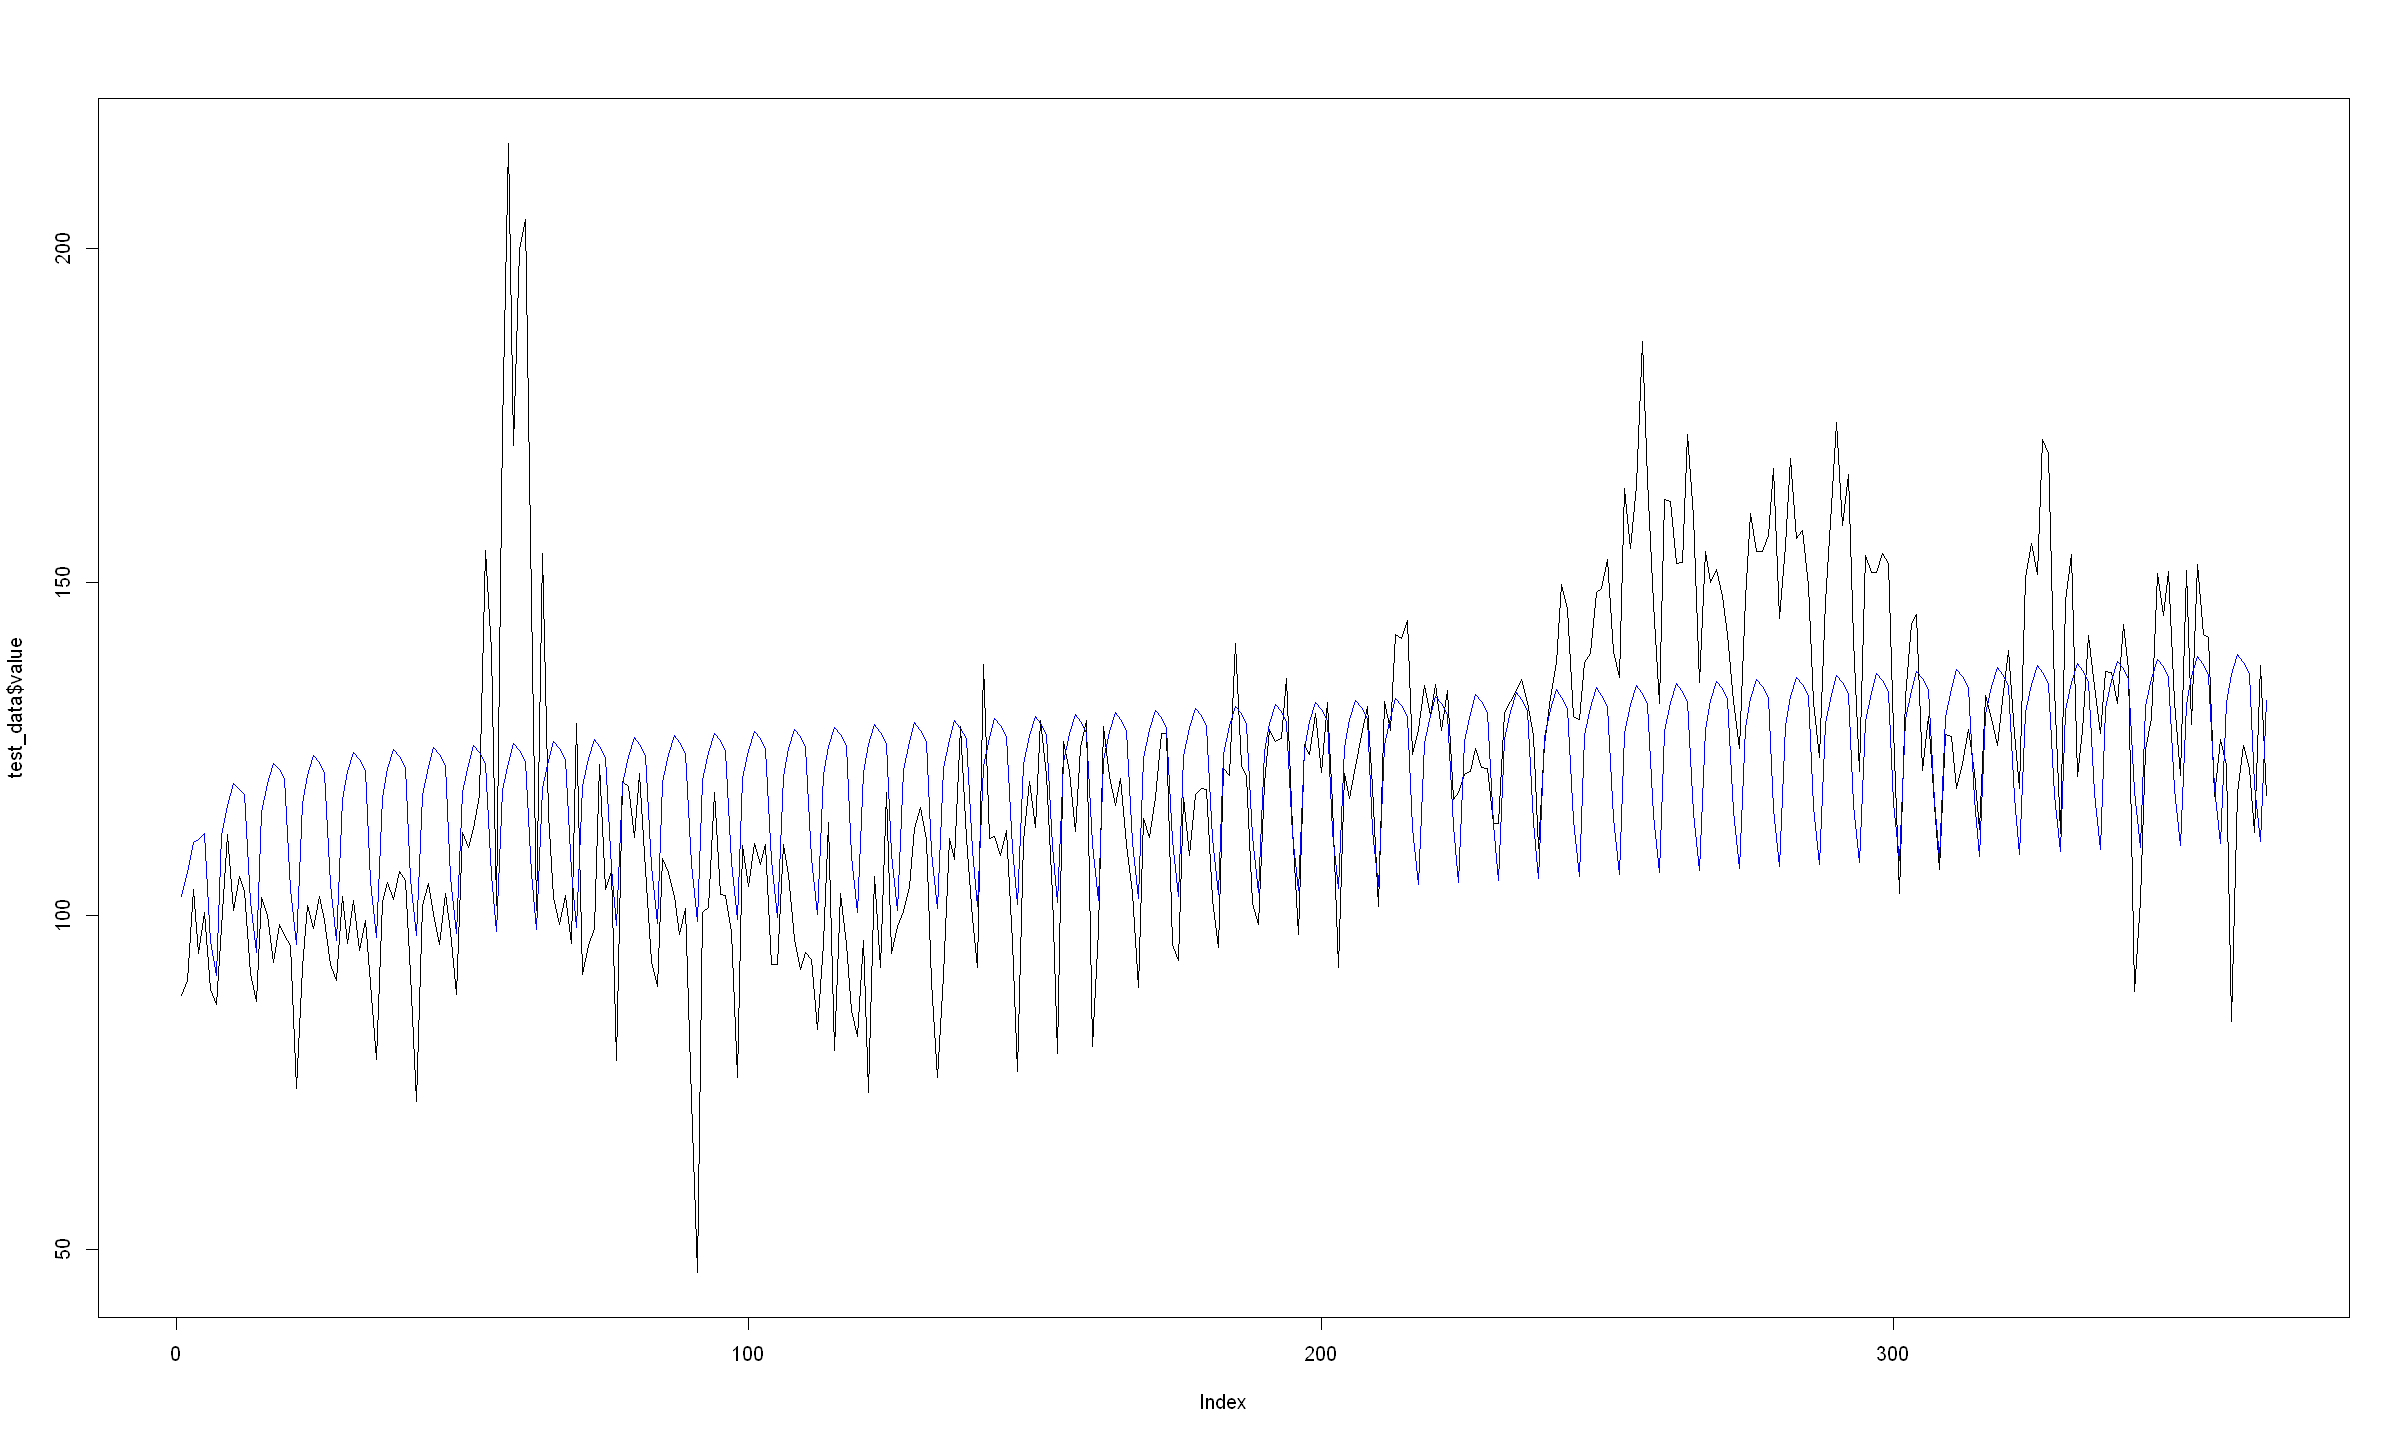

In [ ]:
plot(test_data$value, type = "l",)
lines(as.numeric(forecast(model7, h=365)$mean), col = "blue")


# UCM 

provo con LLT 

In [ ]:
library(xts)
dataset_ordered <- xts(df$value, start=c(2010,1), order.by=df$Data) 

train_ordered <- dataset_ordered["2010-01-01/2017-12-31"]
validation <- dataset_ordered["2018-01-01/2018-12-31"]
ytrain_ordered <- as.numeric(train_ordered) 
df$Data <- as.Date(df$Data)
###########################################################
harmon=c(4,8,12,16,20,24)
errors1=c(rep(NA, 6))
errors2=c(rep(NA,6))




Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last




In [ ]:
for (i in harmon){

set_ucm1 <- SSModel(ytrain_ordered ~ SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:i),
                    H = NA)

vary <- var(ytrain_ordered)
set_ucm1$P1inf <- set_ucm1$P1inf * 0
set_ucm1$a1[1] <- mean(ytrain_ordered)
diag(set_ucm1$P1) <- vary




param <- numeric(5)
param[1] <- log(vary/10) 
param[2] <- log(vary/10) 
param[3] <- log(vary/100)
param[4] <- log(vary/100)
param[5] <- log(vary/10) 


updater <- function(initial, model){
  model$Q[1, 1, 1] <- exp(initial[1])
  model$Q[2, 2, 1] <- exp(initial[2])
  model$Q[3, 3, 1] <- exp(initial[3])
  diag(model$Q[4:dim(set_ucm1[["Q"]])[1], 4:dim(set_ucm1[["Q"]])[1], 1]) <- exp(initial[4])
  model$H[1, 1, 1] <- exp(initial[5])
  model
}

fit1 <- fitSSM(set_ucm1, param, updater)
print(fit1$optim.out$convergence)

smo1 <- KFS(fit1$model, smoothing = c("state", "mean"), maxiter=200)

#plot(ytrain_ordered, type="l")
#lines(smo1$muhat, col="red")
library(Metrics)
mape(ytrain_ordered, smo1$muhat)

########################################
y_tot <- c(ytrain_ordered, rep(NA, 365))

data <- c(rep(NA, 365))
ucm_appl1 <- SSModel(y_tot ~  SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                                  harmonics = 1:i),
                    H = fit1$model$H)
ucm_appl1$a1 <- set_ucm1$a1
ucm_appl1$P1 <- set_ucm1$P1
ucm_appl1$P1inf <- set_ucm1$P1inf


prevision_ucm <- predict(fit1$model, newdata=ucm_appl1)[(length(ytrain_ordered)+1):(length(ytrain_ordered)+365)]
smo11 <- KFS(ucm_appl1, smoothing = "state", filter = "signal")
smoothed1<-smo11$m[(length(ytrain_ordered)+1):(length(ytrain_ordered)+365)]
errors1[i]=mape(test_data$value, smoothed1)
errors2[i]=mape(test_data$value, prevision_ucm)}

In [ ]:
errors1
errors2

[1]        NA        NA        NA 0.2549464        NA        NA        NA
 [8] 0.1951795        NA        NA        NA 0.1946511        NA        NA
[15]        NA 0.1808726        NA        NA        NA 0.1755016        NA
[22]        NA        NA 0.1699232

[1]        NA        NA        NA 0.2572582        NA        NA        NA
 [8] 0.1942124        NA        NA        NA 0.1945038        NA        NA
[15]        NA 0.1816134        NA        NA        NA 0.1777868        NA
[22]        NA        NA 0.1746101

il modello migliore è a 24 armoniche uso quindi l'ultimo modello generato dal mio algoritmo

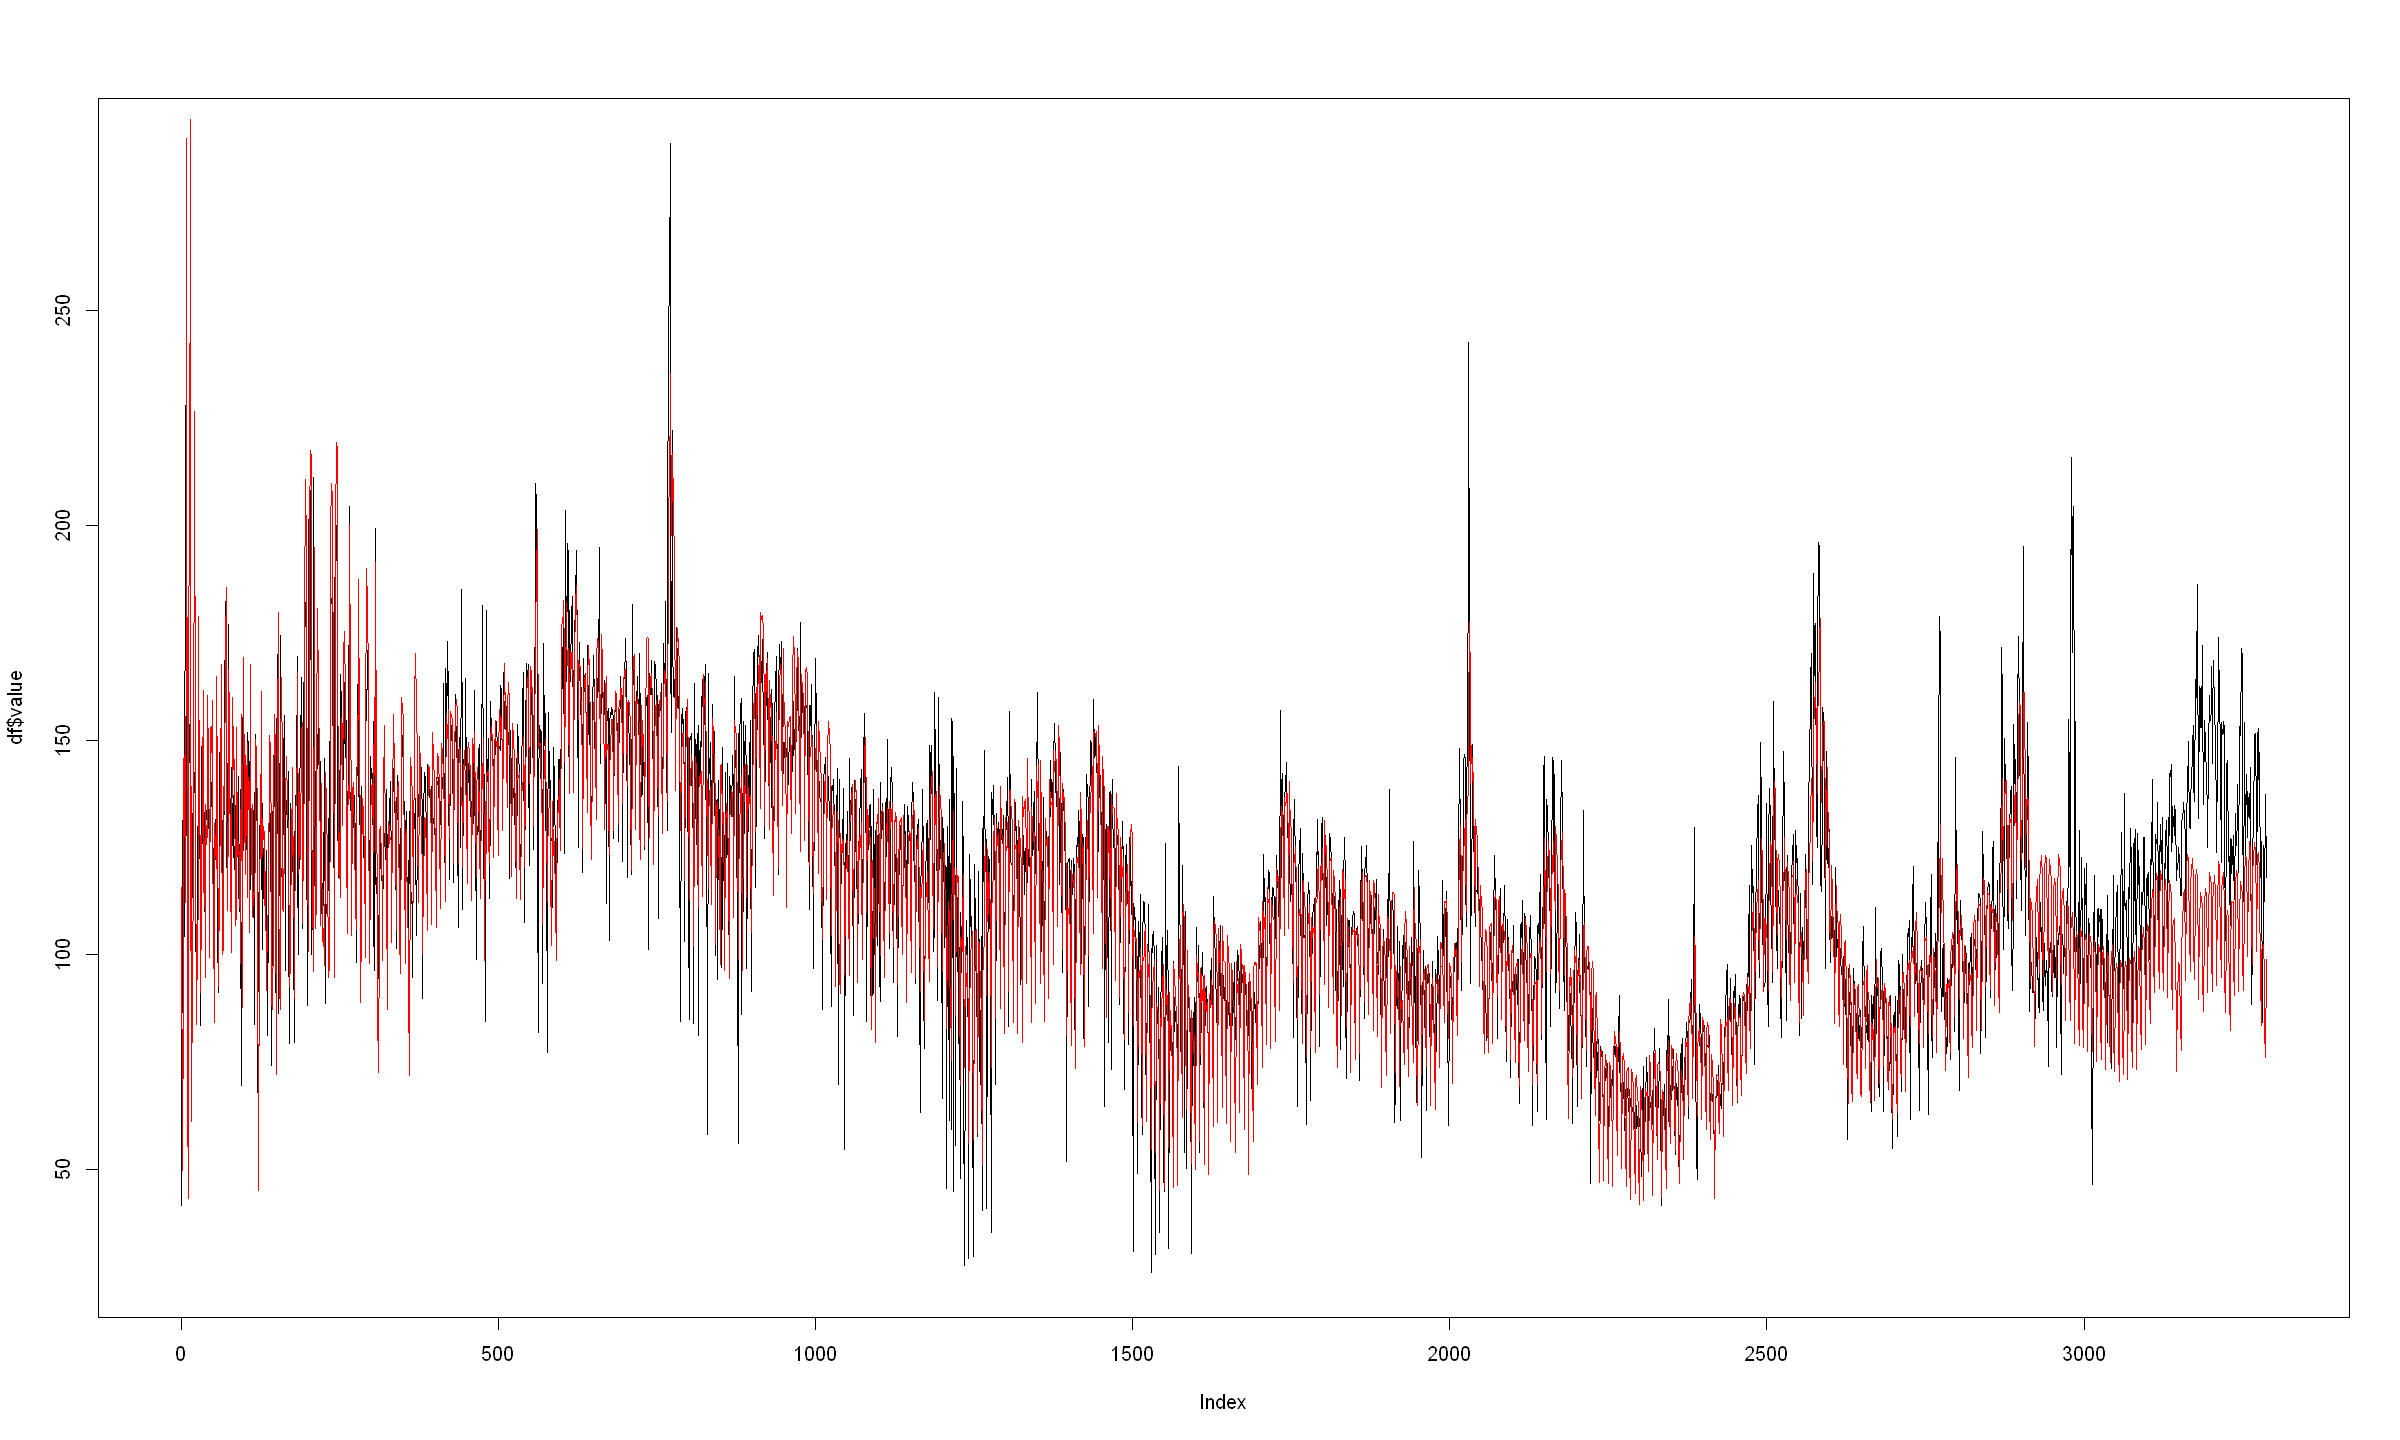

In [ ]:
plot(df$value, type="l")
lines(smo11$m, col="red")

procedo con il random walk

In [ ]:
install.packages('KFAS')
library("KFAS")
set_ucm2 <- SSModel(ytrain_ordered ~ SSMtrend(1, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                    H = NA)

vary <- var(ytrain_ordered)
set_ucm2$P1inf <- set_ucm2$P1inf * 0
set_ucm2$a1[1] <- mean(ytrain_ordered)
diag(set_ucm2$P1) <- vary

param <- numeric(4)
param[1] <- log(vary/10) 
param[2] <- log(vary/10) 
param[3] <- log(vary/100)
param[4] <- log(vary/10) 

updater <- function(initial, model){
  model$Q[1, 1, 1] <- exp(initial[1])
  model$Q[2, 2, 1] <- exp(initial[2])
  diag(model$Q[3:50, 3:50, 1]) <- exp(initial[3])
  model$H[1, 1, 1] <- exp(initial[4])
  model
}

fit2 <- fitSSM(set_ucm2, param, updater)
print(fit2$optim.out$convergence)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] 0


[1] 0.07663908

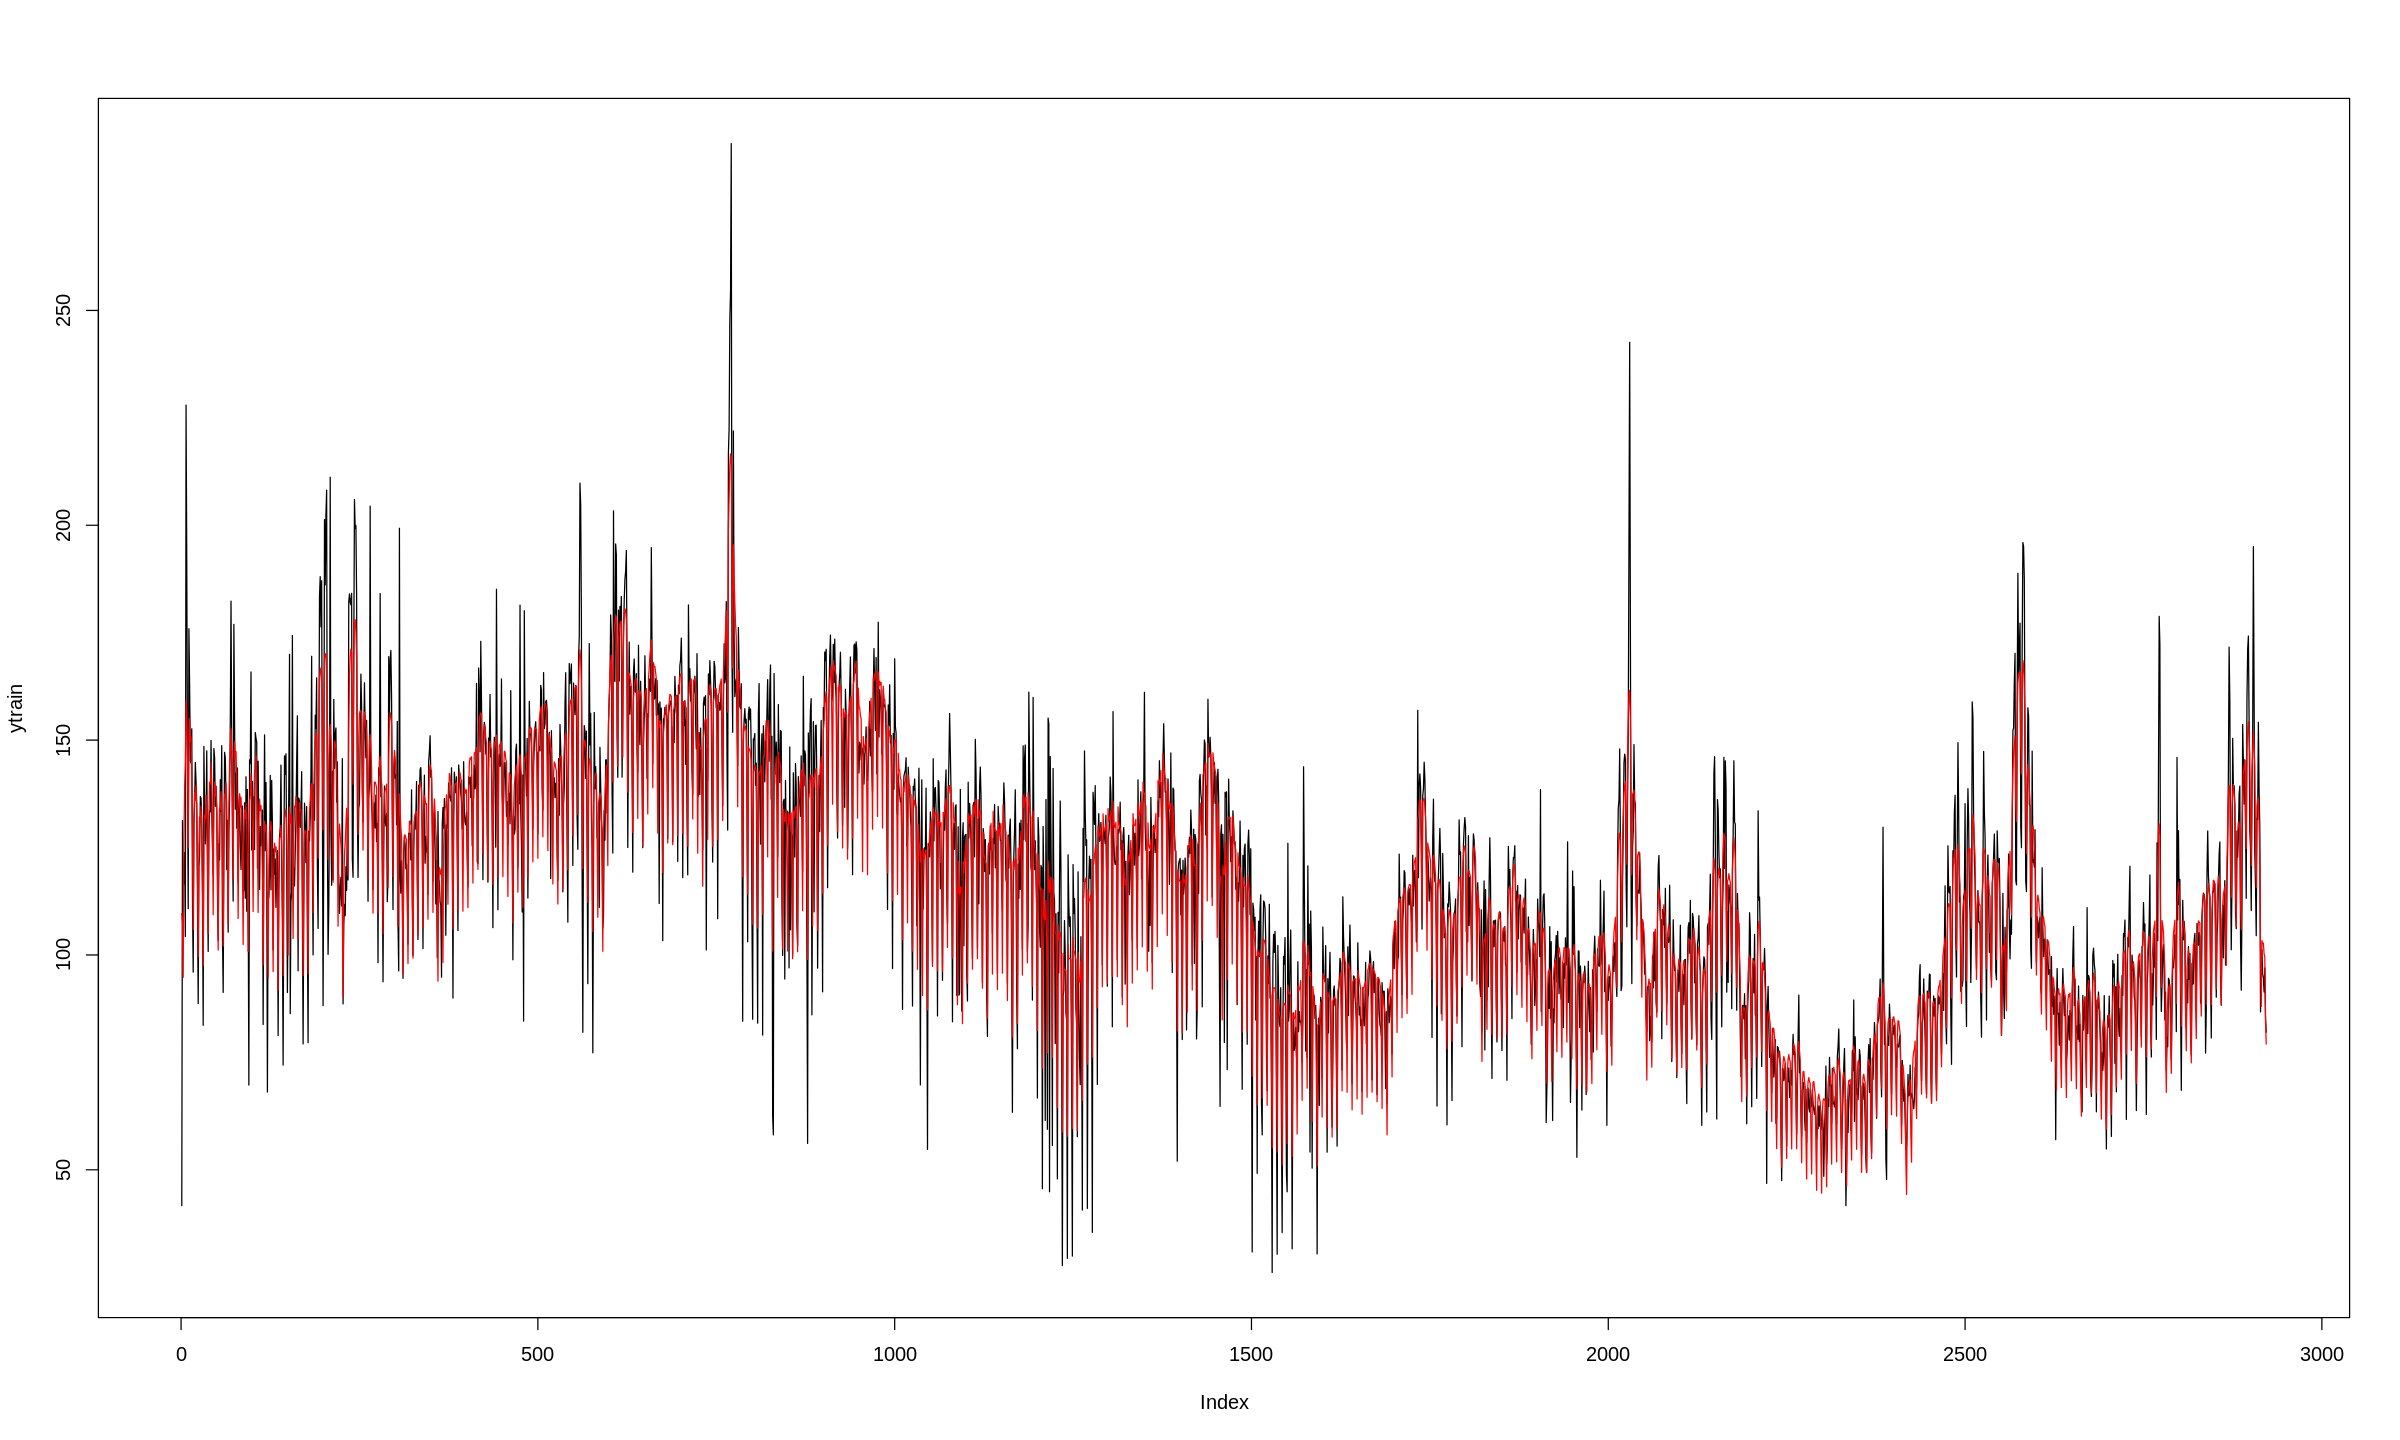

In [ ]:
smo2 <- KFS(fit2$model, smoothing = c("state", "mean"), maxiter=200)

plot(ytrain_ordered, type="l")
lines(smo2$muhat, col="red")
mape(ytrain_ordered, smo2$muhat)

In [ ]:
y_tot <- c(ytrain_ordered, rep(NA, 365))

ucm_appl2 <- SSModel(y_tot ~  SSMtrend(1, list(fit2$model$Q[1,1,1])) +
                       SSMseasonal(7, fit2$model$Q[2,2,1], "dummy") +
                       SSMseasonal(365, fit2$model$Q[3, 3, 1], "trig",
                                   harmonics = 1:24),
                     H = fit2$model$H)
ucm_appl2$a1 <- set_ucm2$a1
ucm_appl2$P1 <- set_ucm2$P1
ucm_appl2$P1inf <- set_ucm2$P1inf


prevision_ucm <- predict(fit2$model, newdata=ucm_appl2)[(length(ytrain_ordered)+1):(length(ytrain_ordered)+365)]
smo22 <- KFS(ucm_appl2, smoothing = "state", filter = "signal")
smoothed2<-smo22$m[(length(ytrain_ordered)+1):(length(ytrain_ordered)+365)]

[1] 0.1616217

[1] 0.1616039

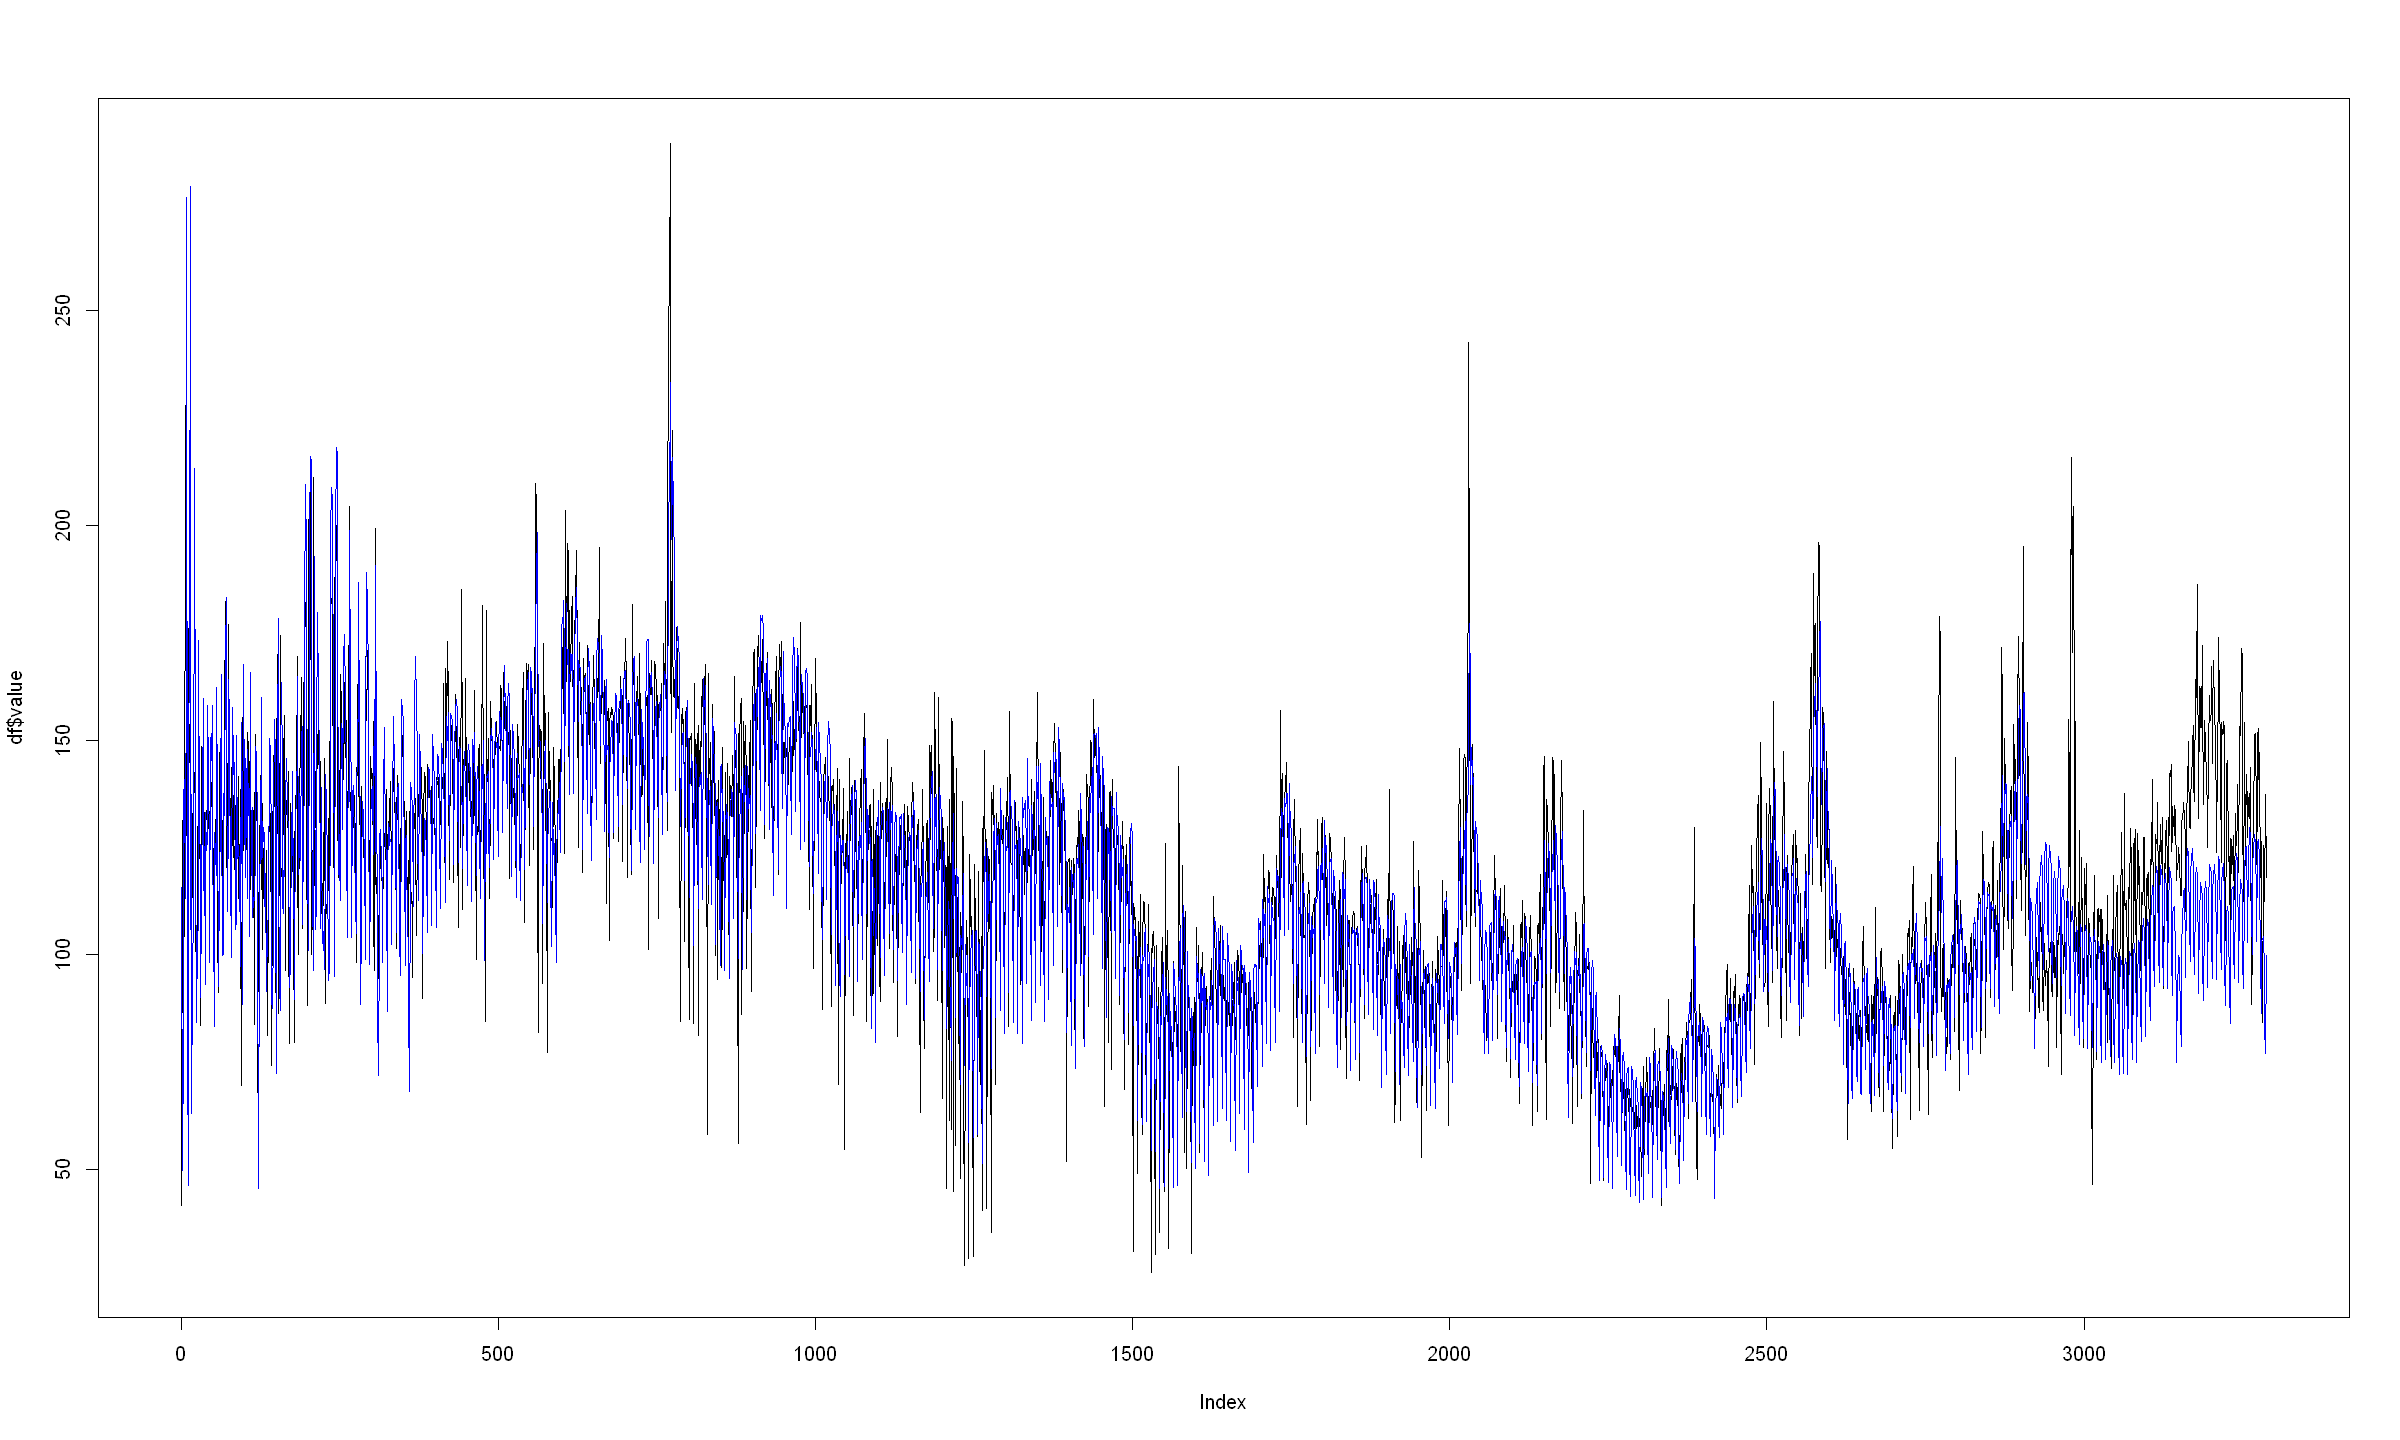

In [ ]:
plot(df$value, type="l")
lines(smo22$m, col="blue")
mape(test_data$value, smoothed2)
mape(test_data$value, prevision_ucm)

# let's use our best models to make the predictions

arima

In [ ]:
model_arima_final <- Arima(df$value, c(6,1,6), list(order=c(1,1,1), period=7), lambda = "auto", method = "ML")

[1] 207.6666

[1] 0.09409634

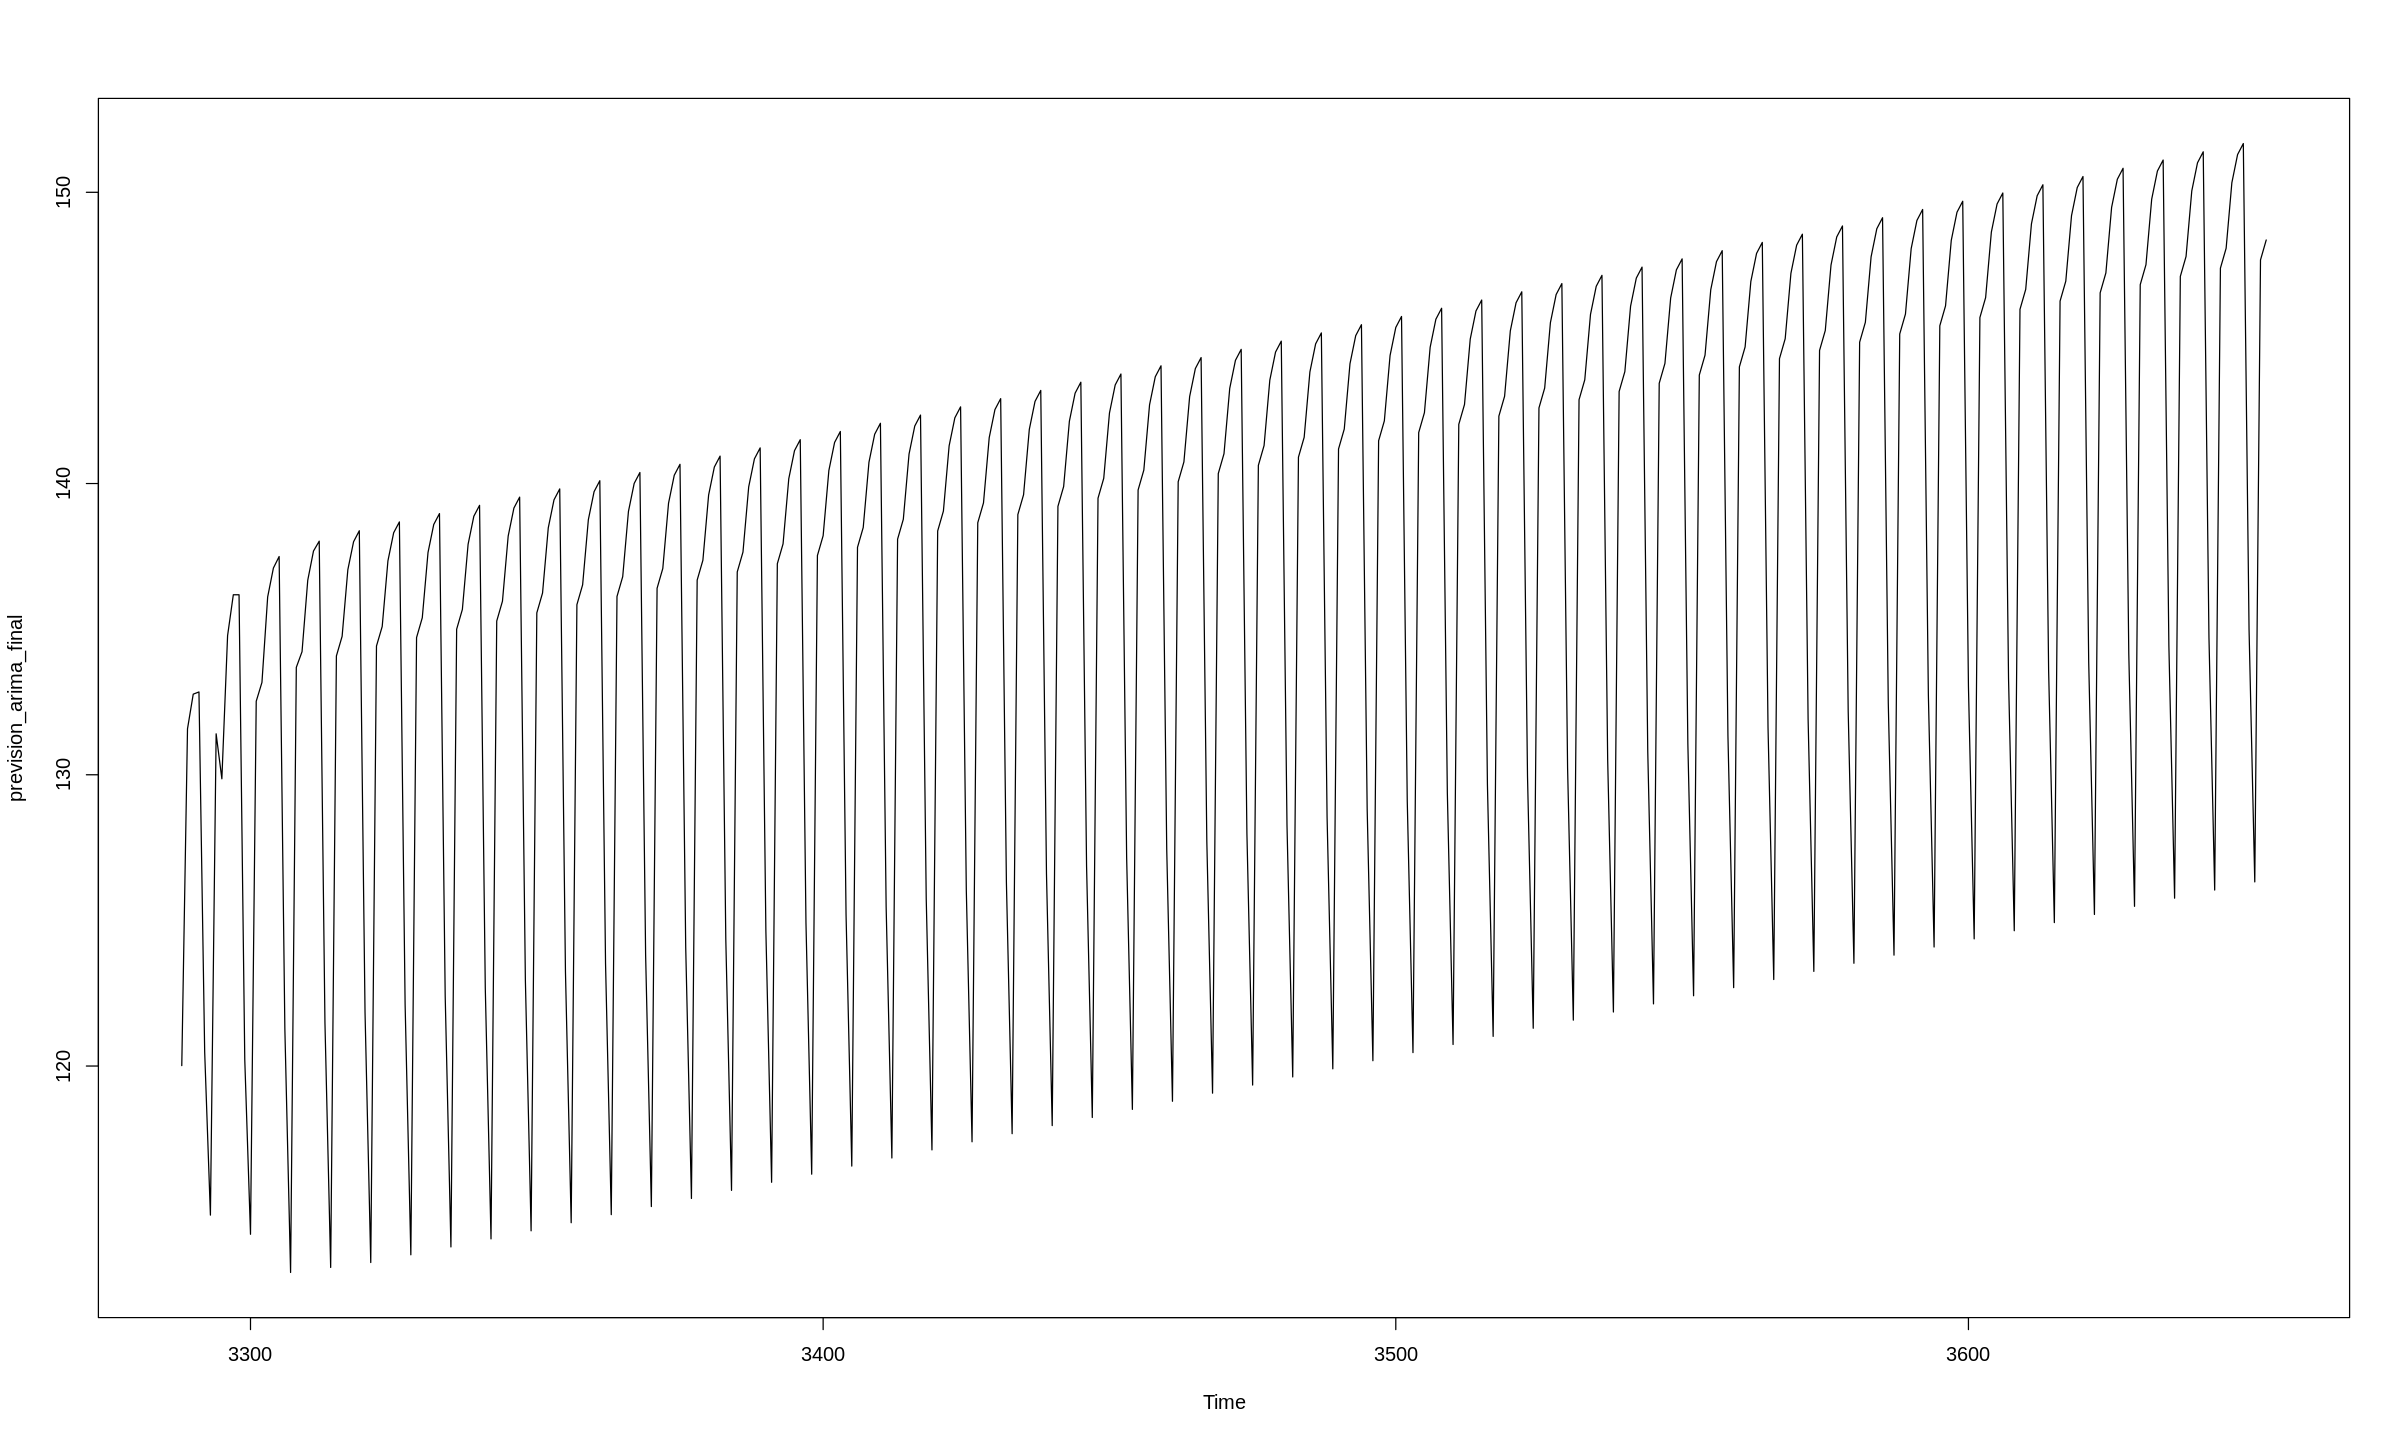

In [ ]:
mse(df$value, fitted(model_arima_final))
mape(df$value, fitted(model_arima_final))
prevision_arima_final=forecast(model_arima_final, h=365)$mean
plot(prevision_arima_final, type="l")

UCM

[1] 0


[1] 0.07239136

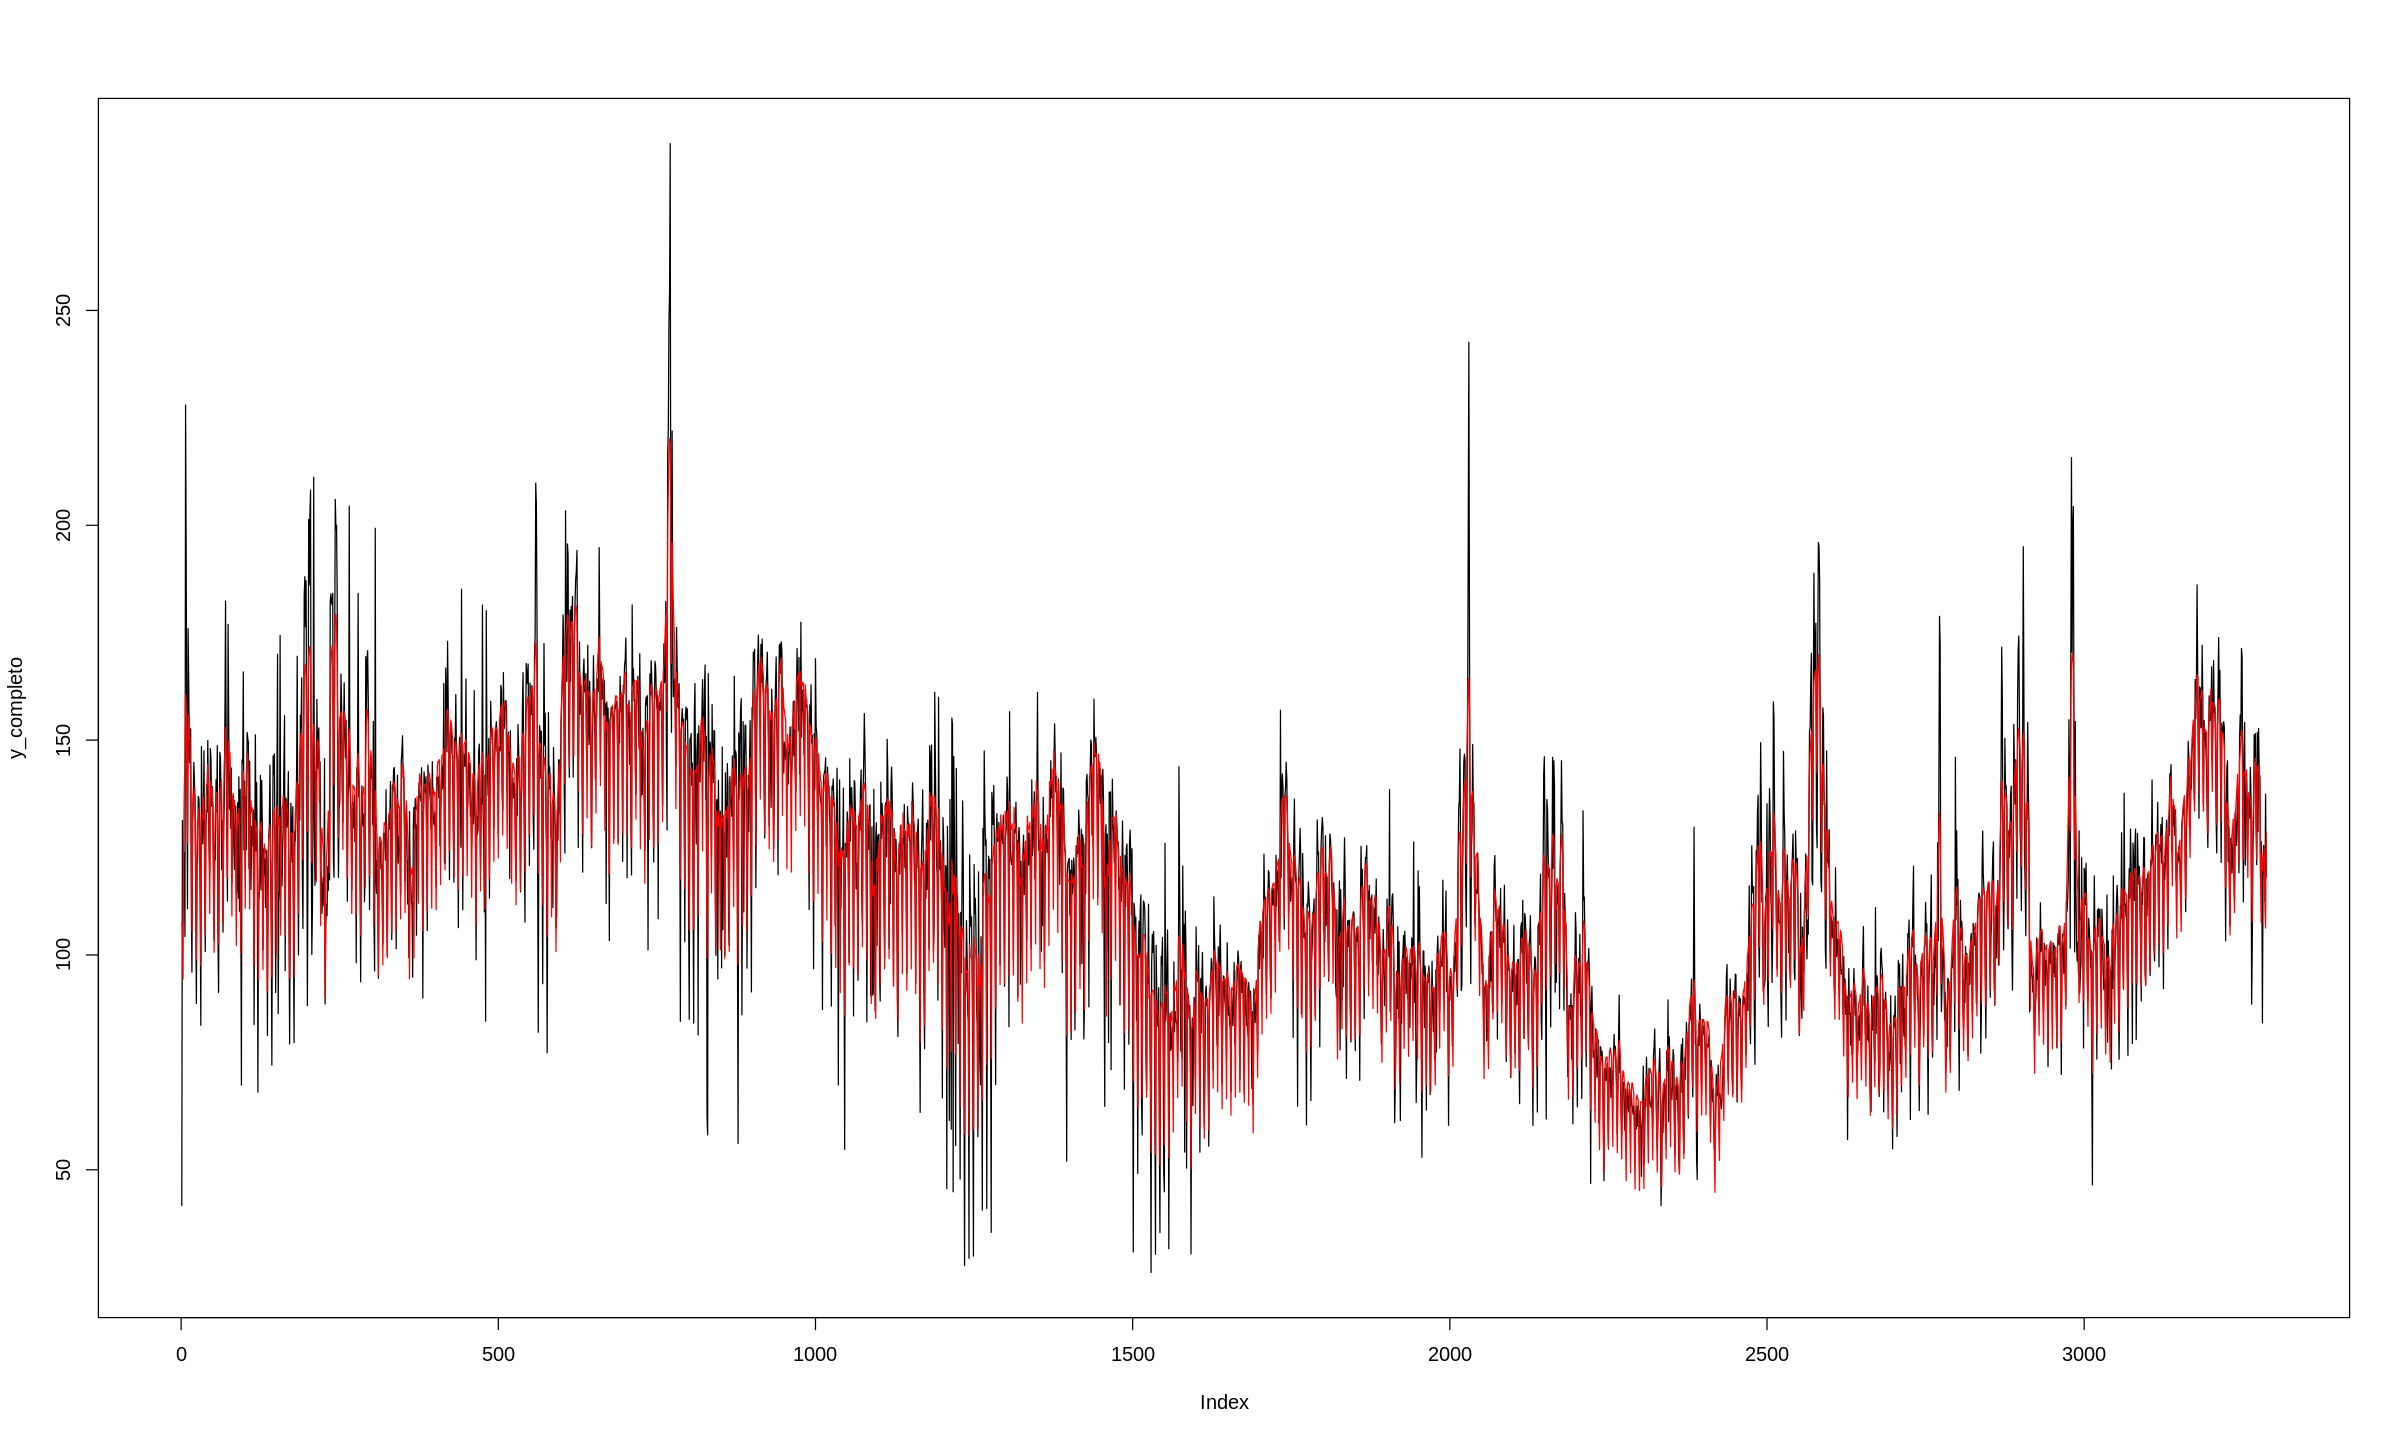

In [ ]:
y_completo=as.numeric(dataset_ordered)
ucm_last <- SSModel(y_completo ~ SSMtrend(1, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                    H = NA)

vary <- var(y_completo)
ucm_last$P1inf <- ucm_last$P1inf * 0
ucm_last$a1[1] <- mean(y_completo)
diag(ucm_last$P1) <- vary

param <- numeric(4)
param[1] <- log(vary/10) 
param[2] <- log(vary/10) 
param[3] <- log(vary/100)
param[4] <- log(vary/10) 

updater <- function(initial, model){
  model$Q[1, 1, 1] <- exp(initial[1])
  model$Q[2, 2, 1] <- exp(initial[2])
  diag(model$Q[3:50, 3:50, 1]) <- exp(initial[3])
  model$H[1, 1, 1] <- exp(initial[4])
  model
}

fit_last_ucm <- fitSSM(ucm_last, param, updater)
print(fit_last_ucm$optim.out$convergence)
smo_last <- KFS(fit_last_ucm$model, smoothing = c("state", "mean"), maxiter=200)

plot(y_completo, type="l")
lines(smo_last$muhat, col="red")
mape(y_completo, smo_last$muhat)

In [ ]:
y_tot <- c(y_completo, rep(NA, 365))

ucm_appl_last <- SSModel(y_tot ~  SSMtrend(1, list(fit_last_ucm$model$Q[1,1,1])) +
                       SSMseasonal(7, fit_last_ucm$model$Q[2,2,1], "dummy") +
                       SSMseasonal(365, fit_last_ucm$model$Q[3, 3, 1], "trig",
                                   harmonics = 1:24),
                     H = fit_last_ucm$model$H)
ucm_appl_last$a1 <- ucm_last$a1
ucm_appl_last$P1 <- ucm_last$P1
ucm_appl_last$P1inf <- ucm_last$P1inf


prevision_ucm <- predict(fit_last_ucm$model, newdata=ucm_appl_last)[(length(y_completo)+1):(length(y_completo)+365)]
smo_last_2 <- KFS(ucm_appl_last, smoothing = "state", filter = "signal")
smoothed_last_2<-smo_last_2$m[(length(y_completo)+1):(length(y_completo)+365)]

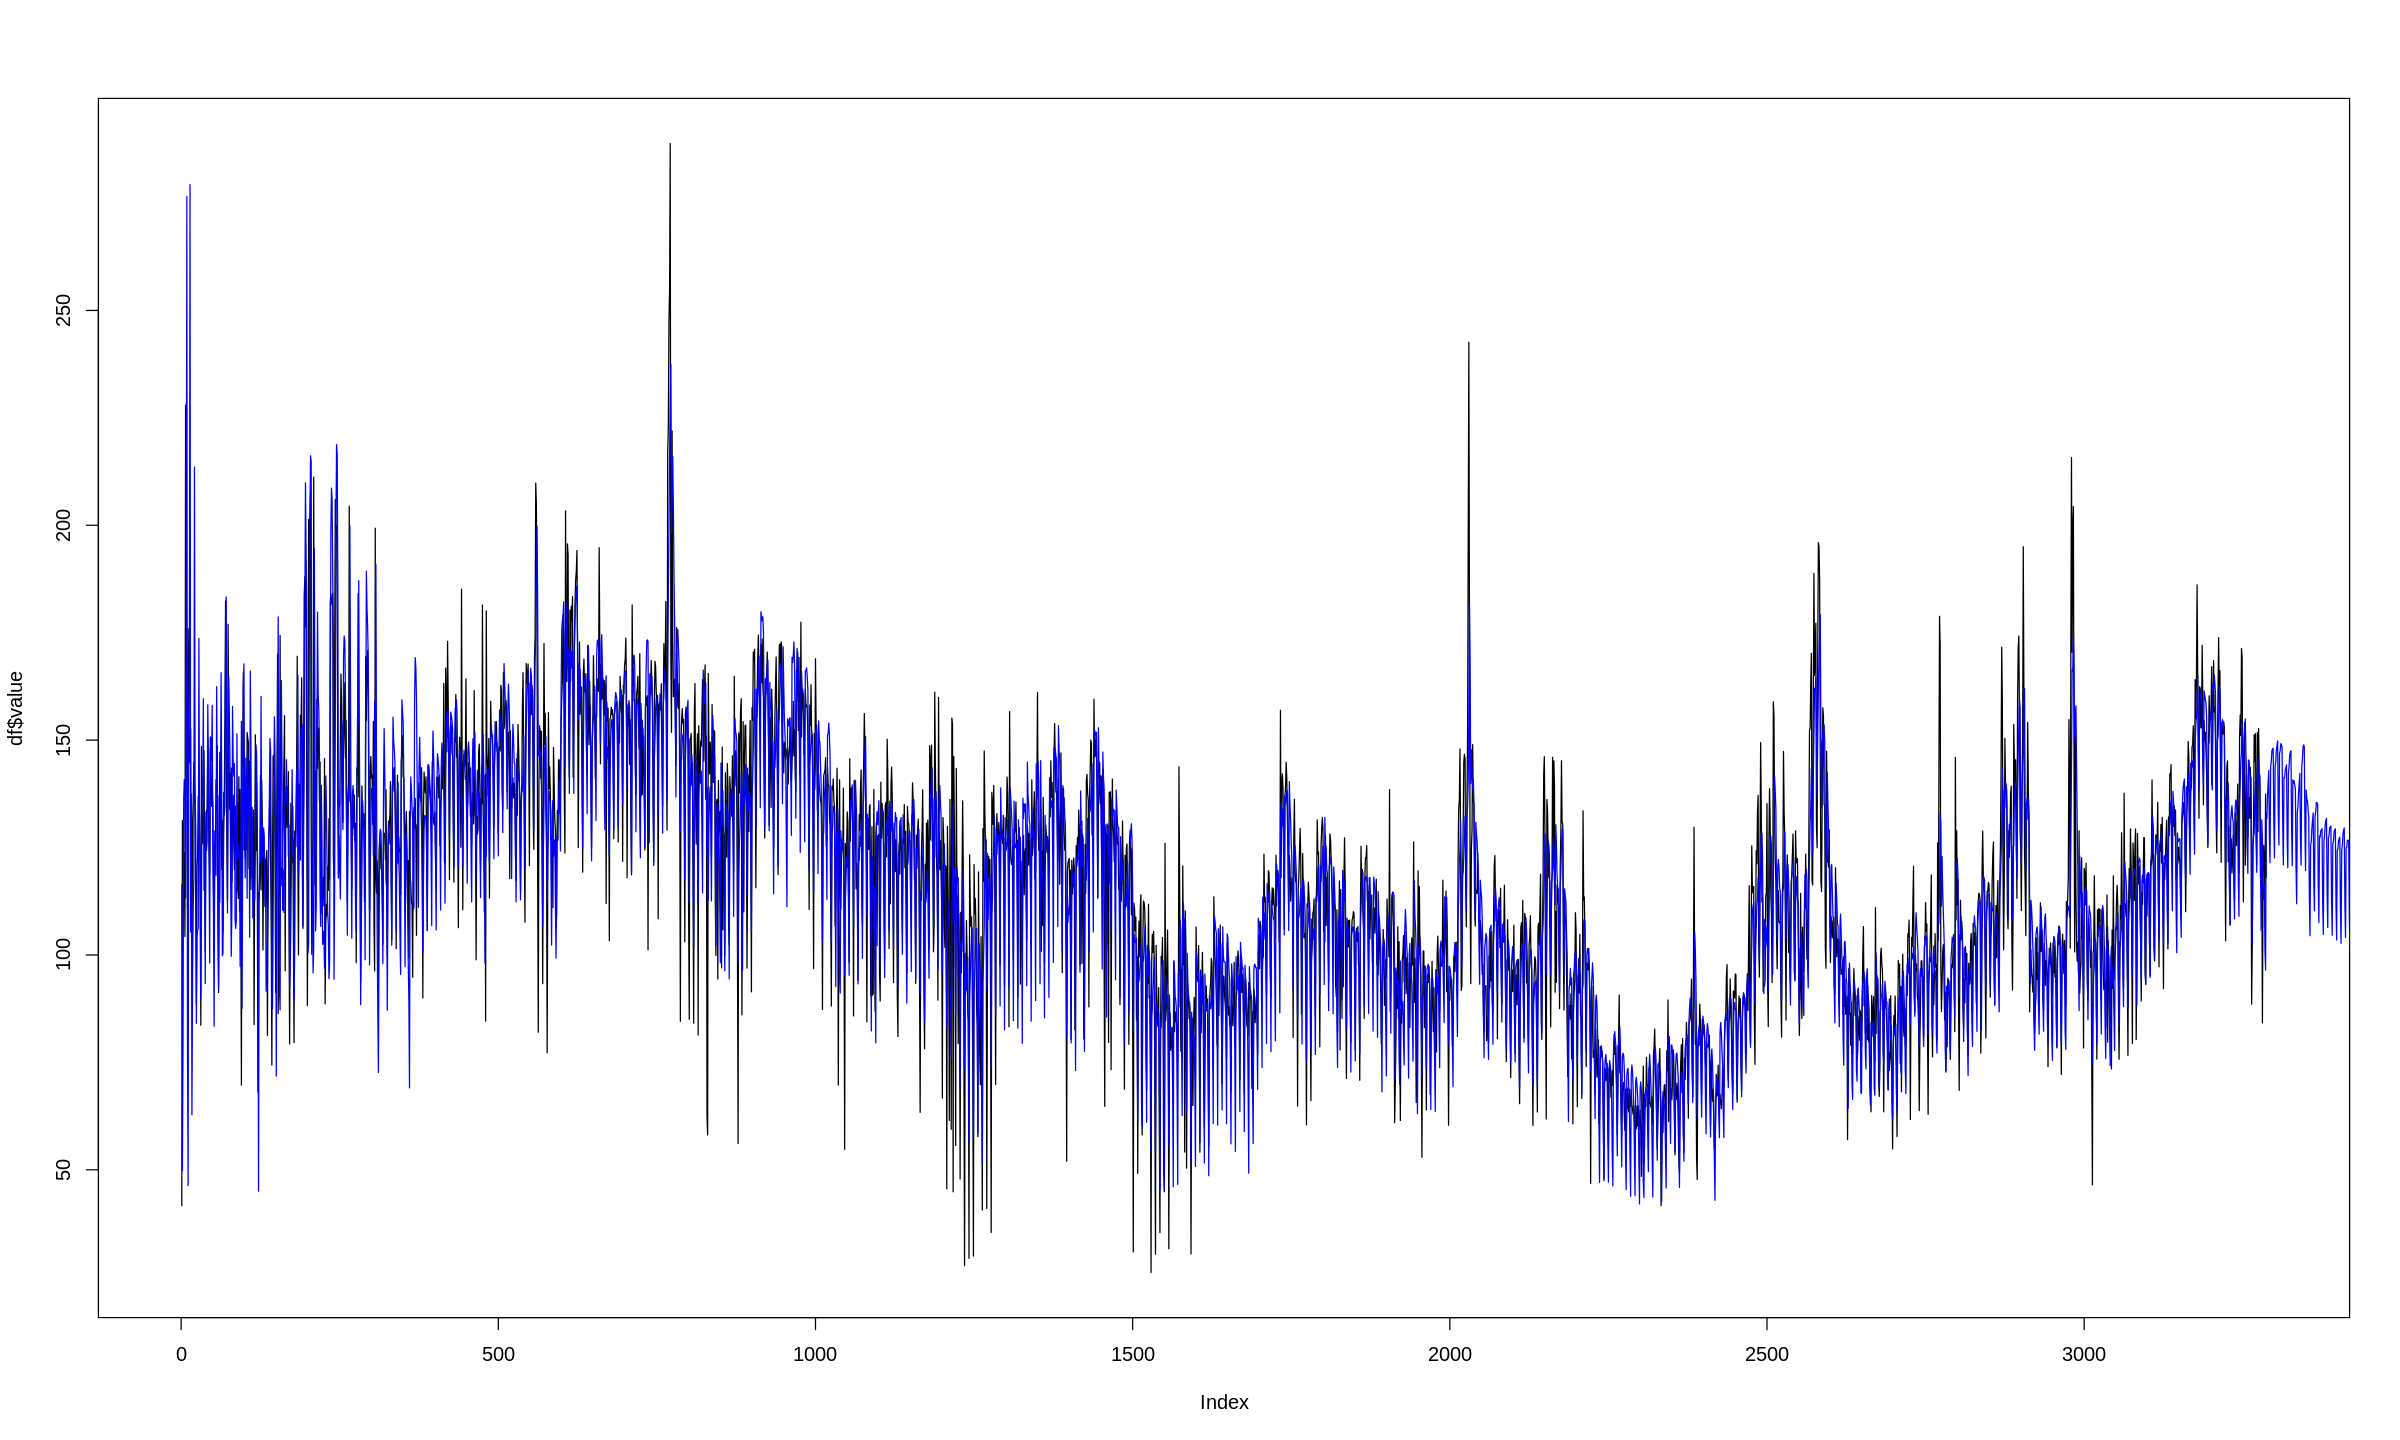

In [ ]:
plot(df$value, type="l")
lines(smo_last_2$m, col="blue")
#mape(test_data$value, smoothed2)
#mape(test_data$value, prevision_ucm)

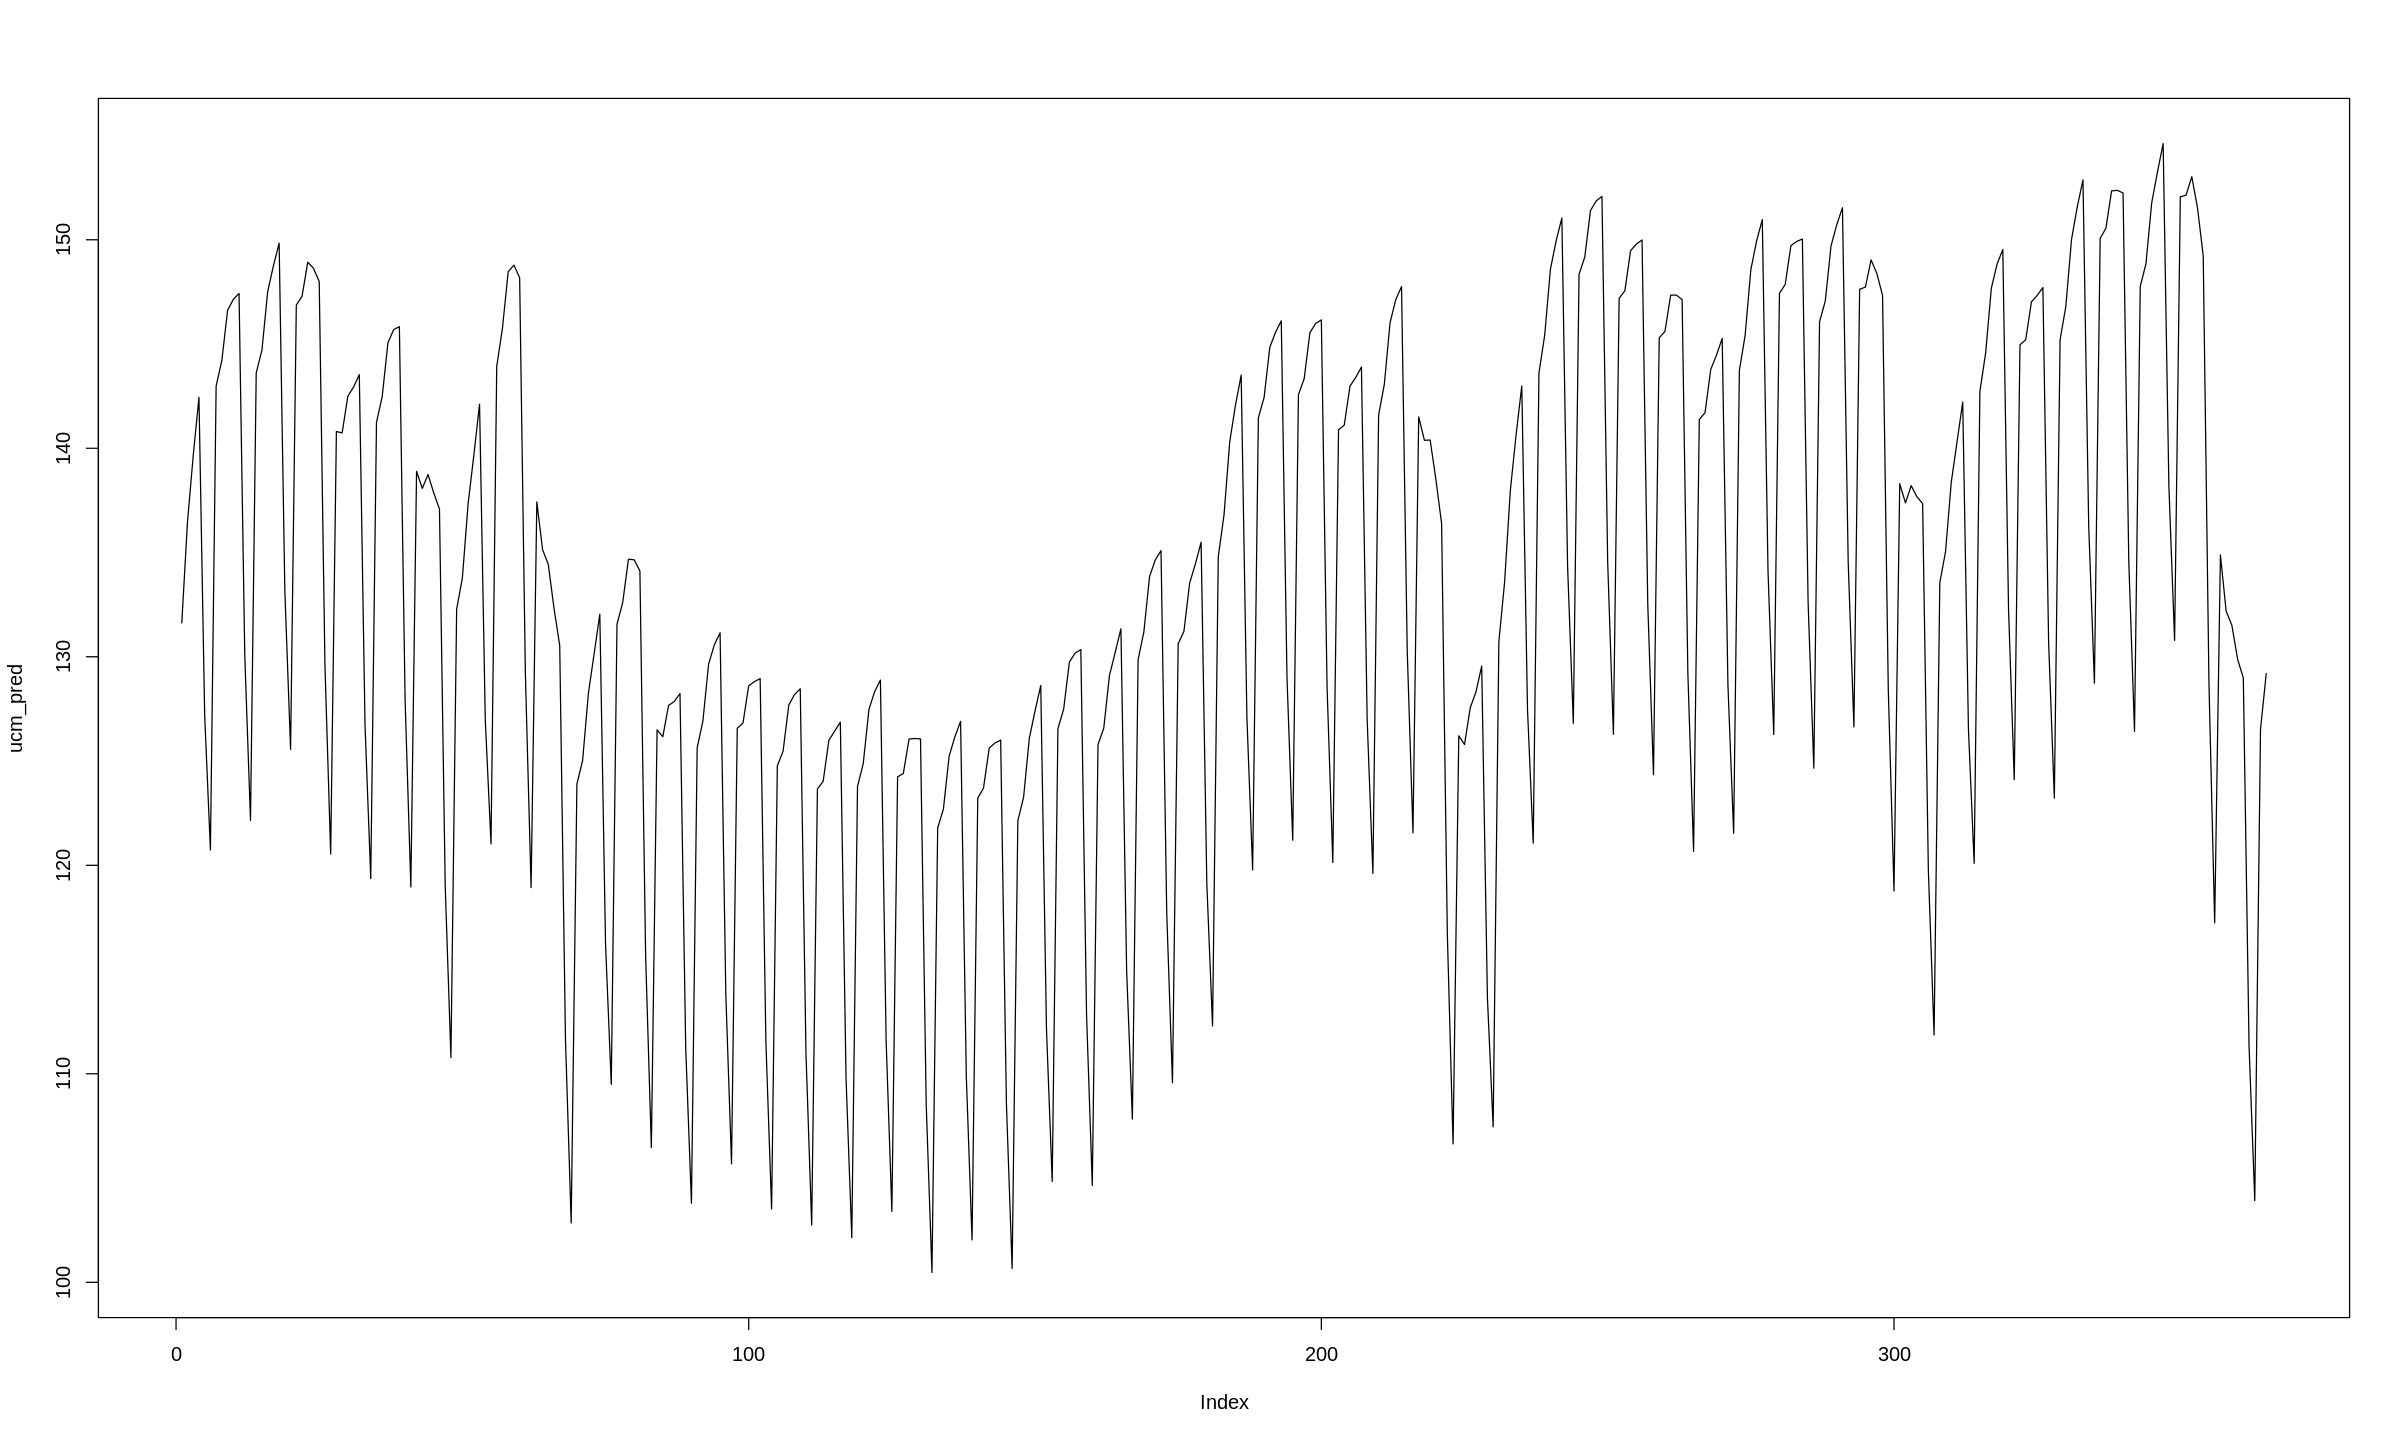

In [ ]:
plot(prevision_ucm,type="l")

In [ ]:
write.csv(prevision_arima_final,"File_arima.csv", row.names = FALSE)
write.csv(prevision_ucm,"File_ucm.csv", row.names = FALSE)

In [ ]:
# MACHINE LEARNING

**RNN**

In [ ]:
import math
import csv
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout,Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv("/content/time_series_dataset.csv", sep = ';')
data['date'] = pd.to_datetime(data['Data'])
df = data.loc[:, ['value']]
df = df.set_index(data.date)
df.head()

value
date                  
2010-01-01   41.651044
2010-01-02  131.286604
2010-01-03  117.388117
2010-01-04  116.461280
2010-01-05  123.823765

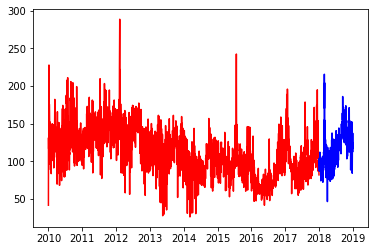

In [ ]:
training_data = df[df.index <= ('2017-12-31')]
val_data = df[df.index > ('2017-12-31')]
import matplotlib.pyplot as plt
fig = plt.figure()
fig.show()
ax = fig.add_subplot()
ax.plot(training_data, color='red')
ax.plot(val_data, color='blue')
plt.show()

Trasformo il dataset a valori tra 0 e 1


In [ ]:
scale_transformation = MinMaxScaler(feature_range=(0, 1))

dataset = np.array(df)
df_scaled = scale_transformation.fit_transform(dataset.reshape(-1,1))
train_df_scaled, val_df_scaled = df_scaled[0:(len(dataset) - 365),:], df_scaled[(len(dataset) - 365):len(df_scaled),:]

train_X = []
train_Y = []
for i in range(365,2922):
    train_X.append(train_df_scaled[i-365:i,0])
    train_Y.append(train_df_scaled[i,0])
train_X, train_Y = np.array(train_X), np.array(train_Y)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))

Genero il mio modello LSTM


In [ ]:
model = Sequential()
model.add(LSTM(8, dropout = 0.1, recurrent_dropout = 0.3, input_shape=(1, 365), return_sequences=True))
model.add(LSTM(16, dropout = 0.1, recurrent_dropout = 0.3,activation="relu"))
model.add(Dense(1, activation = 'sigmoid'))
print(model.summary())
model.compile(loss='mean_squared_error', optimizer='Adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 8)              11968     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 13,585
Trainable params: 13,585
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.0132
Epoch 2/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.0088
Epoch 3/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.0071
Epoch 4/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.0063
Epoch 5/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0058
Epoch 6/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0055
Epoch 7/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0051
Epoch 8/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0053
Epoch 9/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0050
Epoch 10/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0050
Epoch 11/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.0049
Epoch 12/100
2557/2557 [==============================] - 5s 2ms/step - lo

Valuto la bontà del mio training set


In [ ]:
prediction_scaled = model.predict(train_X, batch_size=1)
prediction1 = scale_transformation.inverse_transform(prediction_scaled)

def mape(pred, y_train_): 
  return np.mean(list(map(np.mean,np.abs(np.array(pred) - np.array(y_train_))/np.abs(np.array(y_train_)))))

mape(training_data[365:],prediction1)

0.10064721452568517

In [ ]:
temp_validation_X = train_X[len(train_X)-1]
prediction_y_testset = []
for i in range(365):
  dummy_validation = temp_validation_X[-365:].reshape(1,1,-1)
  predicted_value = model.predict(dummy_validation, batch_size=1)
  temp_validation_X = np.append(dummy_validation, predicted_value)
  prediction_y_testset.append(predicted_value)
test_set = val_data.iloc[:,0:1].values
prediction_y_testset_norm=np.array(prediction_y_testset).tolist()
newest = [i[0] for i in prediction_y_testset_norm]

y_test_prediction_unscaled = scale_transformation.inverse_transform(newest)
mape(y_test_prediction_unscaled,test_set[0:365])

0.14693491862590877

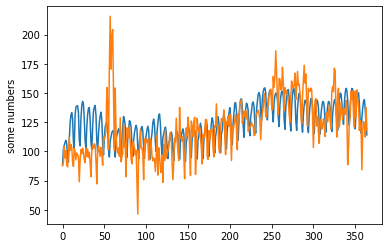

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test_prediction_unscaled)
plt.plot(test_set[0:365])
plt.ylabel('some numbers')
plt.show()

ora faccio la previsione con il dataset completo per l'anno seguente


In [ ]:
temp_validation_X = val_df_scaled[:]
prediction_y_testset = []
for i in range(365):
  dummy_validation = temp_validation_X[-365:].reshape(1,1,-1)
  predicted_value = model.predict(dummy_validation, batch_size=1)
  temp_validation_X = np.append(dummy_validation, predicted_value)
  prediction_y_testset.append(predicted_value)
test_set = val_data.iloc[:,0:1].values
prediction_y_testset_norm=np.array(prediction_y_testset).tolist()
newest = [i[0] for i in prediction_y_testset_norm]

y_test_prediction_unscaled = scale_transformation.inverse_transform(newest)
#mape(y_test_prediction_unscaled,test_set[0:365])

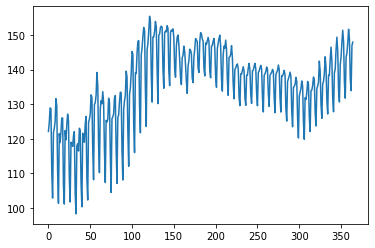

In [ ]:
plt.plot(y_test_prediction_unscaled)

In [ ]:
np.savetxt("LSTM.csv", y_test_prediction_unscaled, delimiter=",")